# TP Integrador Aprendizaje Automático I: Predicción de lluvia en Australia

Integrante: García Julián.

### 1.Introducción y objetivos

Durante el trabajo se utilizará un dataset llamado weatherAUS.csv que contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia en las columnas ‘RainTomorrow’ y ‘RainfallTomorrow’ respectivamente.

El objetivo es la predicción de estas dos variables en función del resto de las características que se consideren adecuadas. 

Para ello nos valdremos de la biblioteca scikit-learn y las herramientas que brinda para el pre-procesamiento de datos, la implementación de modelos y la evaluación de métricas, con TensorFlow para el entrenamiento de redes neuronales y con streamlit para la puesta en producción del modelo seleccionado como el más adecuado, entre otras.

Consideración: el dataset contiene informeción sobre distintas ciudades, las cuales se encuentran en la columna ‘Location’. Solamente se utilizarán para las predicciones las siguientes: Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport.

### 2.Dependencias utilizadas

In [15]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random

from geopy.distance import geodesic
import folium

import shap

# Preprocesado y modelado
from sklearn.preprocessing import StandardScaler

# Evaluación de modelos
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn import metrics

# Modelos de regresión
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

# Validación cruzada y búsqueda de hiperparámetros
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from keras.losses import MeanSquaredError, BinaryCrossentropy
from keras.metrics import MeanSquaredError as MSE

from joblib import Parallel, delayed

# Importaciones de funciones personalizadas
from funciones import *

### 3.Preprocesamiento de datos

#### Carga de datos

In [16]:
#Carga del csv
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')
### Vista de datos
df.head()

Unnamed: 0        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0           0  2008-12-01   Albury     13.4     22.9       0.6          NaN   
1           1  2008-12-02   Albury      7.4     25.1       0.0          NaN   
2           2  2008-12-03   Albury     12.9     25.7       0.0          NaN   
3           3  2008-12-04   Albury      9.2     28.0       0.0          NaN   
4           4  2008-12-05   Albury     17.5     32.3       1.0          NaN   

   Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm Pressure9am  \
0       NaN           W           44.0  ...        22.0      1007.7   
1       NaN         WNW           44.0  ...        25.0      1010.6   
2       NaN         WSW           46.0  ...        30.0      1007.6   
3       NaN          NE           24.0  ...        16.0      1017.6   
4       NaN           W           41.0  ...        33.0      1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8         No            No   
1       1007.8       NaN       NaN     17.2     24.3         No            No   
2       1008.7       NaN       2.0     21.0     23.2         No            No   
3       1012.8       NaN       NaN     18.1     26.5         No            No   
4       1006.0       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.2  

[5 rows x 25 columns]

In [17]:
# Se elimina la primer columna con el índice
df = df.drop('Unnamed: 0', axis=1)

In [18]:
# Se analizan los tipos de datos que conforman el dataset
df.dtypes

Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object

In [19]:
# Se comprueba la cantidad de nulos
df.isnull().sum()

Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

Transformación de RainToday y RainTomorrow: se convierten a tipo booleano.

In [20]:
#Se reemplaza 'Yes' por 1 y 'No' por 0 en las columnas RainToday y RainTomorrow
# errors='coerce' permite conservar los nan aún cambiando el tipo de datos a booleano
df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')

Transformación de WindGustDir, WindDir9am y WindDir3pm

Se reemplazan las tres variables categóricas en dos nuevas columnas, que indican el seno y coseno para cada variable, considerando a las direcciones de viento como ángulos, siendo N=0°, e incrementando los ángulos en el sentido de las agujas del reloj.

In [21]:
def calcular_componentes_viento(df, columna):
    # Diccionario con las direcciones del viento y sus correspondientes ángulos
    direcciones = {
        'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
        'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
        'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
        'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
    }
    # Convertir las direcciones a ángulos en radianes
    df[f'Ángulo_{columna}'] = df[columna].map(direcciones) * (np.pi / 180)

    # Calcular el seno y el coseno y anteponer el nombre de la columna a 'seno' y 'coseno'
    df[f'{columna}_sen'] = np.sin(df[f'Ángulo_{columna}'])
    df[f'{columna}_cos'] = np.cos(df[f'Ángulo_{columna}'])

    # Eliminar la columna de ángulo y la columna original, ya que no se necesita más
    df.drop(columns=[f'Ángulo_{columna}', columna], inplace=True)
    # Retornar el DataFrame con las nuevas columnas de seno y coseno
    return df

In [22]:
# Usar la función para calcular las componentes seno y coseno
df = calcular_componentes_viento(df, 'WindGustDir')
df = calcular_componentes_viento(df, 'WindDir9am')
df = calcular_componentes_viento(df, 'WindDir3pm')
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145407  2017-06-20    Uluru      3.5     21.8       0.0          NaN   
145408  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145409  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145410  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145411  2017-06-24    Uluru      7.8     27.0       0.0          NaN   

        Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  ...  Temp3pm  \
0            NaN           44.0          20.0          24.0  ...     21.8   
1            NaN           44.0           4.0          22.0  ...     24.3   
2            NaN           46.0          19.0          26.0  ...     23.2   
3            NaN           24.0          11.0           9.0  ...     26.5   
4            NaN           41.0           7.0          20.0  ...     29.7   
...          ...            ...           ...           ...  ...      ...   
145407       NaN           31.0          15.0          13.0  ...     20.9   
145408       NaN           31.0          13.0          11.0  ...     22.4   
145409       NaN           22.0          13.0           9.0  ...     24.5   
145410       NaN           37.0           9.0           9.0  ...     26.1   
145411       NaN           28.0          13.0           7.0  ...     26.0   

        RainToday  RainTomorrow  RainfallTomorrow  WindGustDir_sen  \
0           False         False               0.0        -1.000000   
1           False         False               0.0        -0.923880   
2           False         False               0.0        -0.923880   
3           False         False               1.0         0.707107   
4           False         False               0.2        -1.000000   
...           ...           ...               ...              ...   
145407      False         False               0.0         1.000000   
145408      False         False               0.0         1.000000   
145409      False         False               0.0        -0.382683   
145410      False         False               0.0         0.000000   
145411      False         False               0.0         0.707107   

        WindGustDir_cos  WindDir9am_sen  WindDir9am_cos  WindDir3pm_sen  \
0         -1.836970e-16       -1.000000   -1.836970e-16       -0.923880   
1          3.826834e-01       -0.382683    9.238795e-01       -0.923880   
2         -3.826834e-01       -1.000000   -1.836970e-16       -0.923880   
3          7.071068e-01        0.707107   -7.071068e-01        1.000000   
4         -1.836970e-16        0.923880    3.826834e-01       -0.707107   
...                 ...             ...             ...             ...   
145407     6.123234e-17        0.923880   -3.826834e-01        1.000000   
145408     6.123234e-17        0.707107   -7.071068e-01        0.923880   
145409     9.238795e-01        0.707107   -7.071068e-01        0.000000   
145410     1.000000e+00        0.707107   -7.071068e-01       -0.923880   
145411    -7.071068e-01        0.382683   -9.238795e-01        0.000000   

        WindDir3pm_cos  
0         3.826834e-01  
1        -3.826834e-01  
2        -3.826834e-01  
3         6.123234e-17  
4         7.071068e-01  
...                ...  
145407    6.123234e-17  
145408    3.826834e-01  
145409    1.000000e+00  
145410    3.826834e-01  
145411    1.000000e+00  

[145412 rows x 27 columns]

Transformación de Date

In [23]:
def calcular_componentes_fecha(df, columna_fecha):
    # Convertir la columna a formato de fecha si aún no lo está
    df[columna_fecha] = pd.to_datetime(df[columna_fecha])
    
    # Calcular el día del año para cada fecha
    df['Día del año'] = df[columna_fecha].dt.dayofyear
    
    # Asumiendo que cada año tiene 360 días para el cálculo de ángulos
    # Calcular el ángulo correspondiente para cada fecha
    df[f'Ángulo_{columna_fecha}'] = (df['Día del año'] / 360) * 360
    
    # Calcular el seno y el coseno para cada ángulo
    # Convertir ángulos a radianes
    radianes = np.deg2rad(df[f'Ángulo_{columna_fecha}'])
    df[f'{columna_fecha}_sen'] = np.sin(radianes)
    df[f'{columna_fecha}_cos'] = np.cos(radianes)
    
    # Eliminar las columnas intermedias y la columna de fecha original si no la necesita más
    df.drop(columns=['Día del año', f'Ángulo_{columna_fecha}'], inplace=True)
    
    # Devolver solo las columnas de seno y coseno
    return df

In [24]:
# Usar la función para calcular las componentes seno y coseno basadas en la fecha
df = calcular_componentes_fecha(df, 'Date')
df.dtypes

Date                datetime64[ns]
Location                    object
MinTemp                    float64
MaxTemp                    float64
Rainfall                   float64
Evaporation                float64
Sunshine                   float64
WindGustSpeed              float64
WindSpeed9am               float64
WindSpeed3pm               float64
Humidity9am                float64
Humidity3pm                float64
Pressure9am                float64
Pressure3pm                float64
Cloud9am                   float64
Cloud3pm                   float64
Temp9am                    float64
Temp3pm                    float64
RainToday                  boolean
RainTomorrow               boolean
RainfallTomorrow           float64
WindGustDir_sen            float64
WindGustDir_cos            float64
WindDir9am_sen             float64
WindDir9am_cos             float64
WindDir3pm_sen             float64
WindDir3pm_cos             float64
Date_sen                   float64
Date_cos            

Se agregan los deltas de temperatura, presión, humedad y velocidad del viento.

In [25]:
df['DTemp'] = df['Temp3pm'] - df['Temp9am']
df['DPressure'] = df['Pressure3pm'] - df['Pressure9am']
df['DHumidity'] = df['Humidity3pm'] - df['Humidity9am']
df['DWindSpeed'] = df['WindSpeed3pm'] - df['WindSpeed9am']

Se genera un dataframe reducido para las ciudades del análisis (df), pero se conserva el df original (ahora df_49).

In [26]:
#Se conserva el df original para las 49 ciudades
df_49=df

# Lista de ubicaciones permitidas
allowed_locations = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Eliminar las demás ubicaciones del DataFrame original
df = df[df['Location'].isin(allowed_locations)]

#### Partición del Dataframe

Se particiona el df en df_train y df_test en una proporción aproximada de 80% 20%, correspondiendo los del df_train a los datos cronológicamente más antiguos.

In [27]:
# Ordenamiento por la columna 'Date'
df = df.sort_values('Date')

# Calcular el índice que corresponde al 80% del DataFrame
index_at_80_percent = int(len(df) * 0.8)

# Usar el índice para obtener la fecha en ese punto
date_at_80_percent = df.iloc[index_at_80_percent]['Date']

# Crear df_train y df_test basado en esta fecha
df_train = df[df['Date'] <= date_at_80_percent]
df_test = df[df['Date'] > date_at_80_percent]

# Se almacenan los largos de df_train_len y df_test_len
df_train_len=len(df_train)
df_test_len=len(df_test)

# Mostrar el número de registros en cada conjunto
print(f"Entrenamiento: {df_train_len} registros")
print(f"Prueba: {df_test_len} registros")
print(f"Suma de registro Entrenamiento y Prueba: {df_train_len+df_test_len} registros")
print(f"Cantidad total de registros en df original: {df.shape[0]} registros")

Entrenamiento: 22590 registros
Prueba: 5643 registros
Suma de registro Entrenamiento y Prueba: 28233 registros
Cantidad total de registros en df original: 28233 registros


#### Exploración de los datos en df_train

Se describen las principales métricas de cada variable:

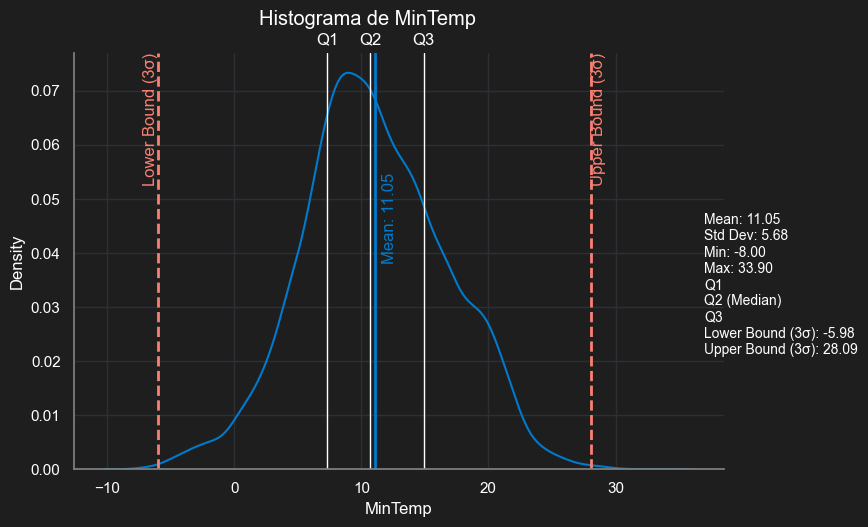

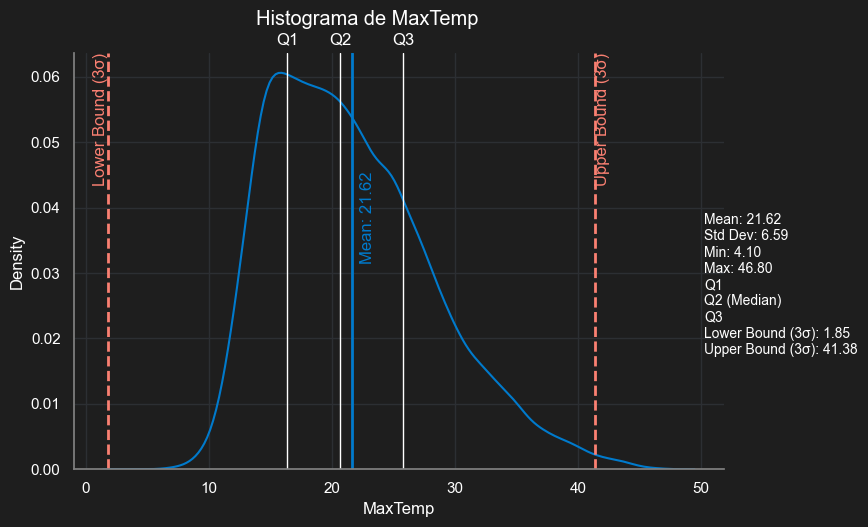

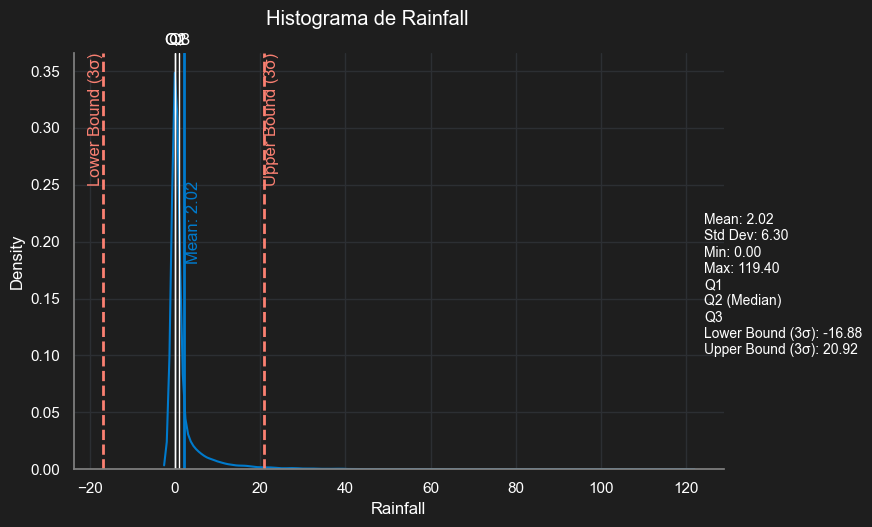

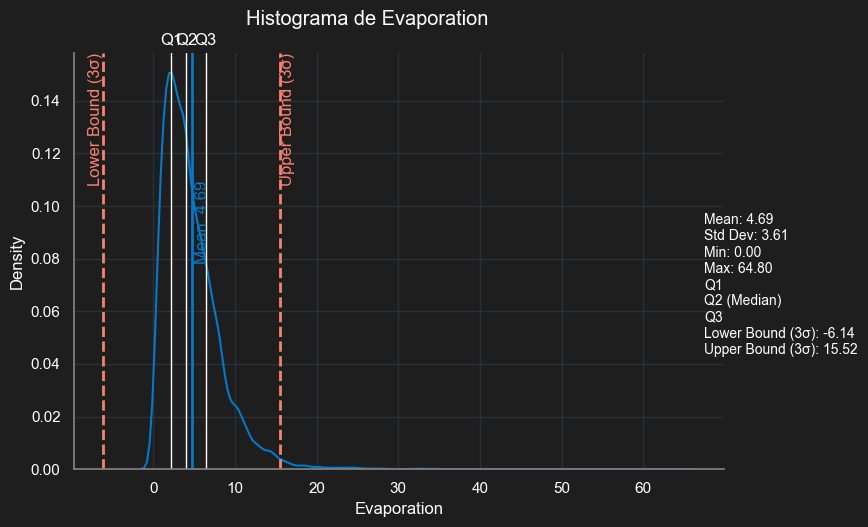

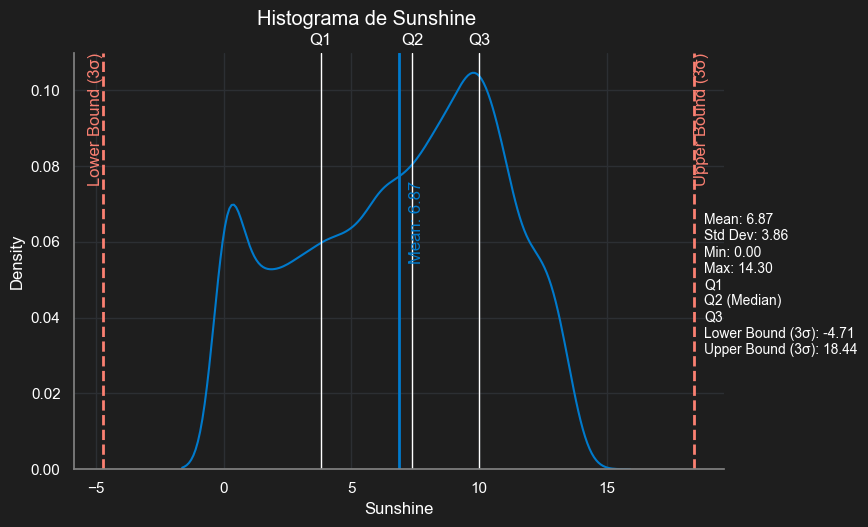

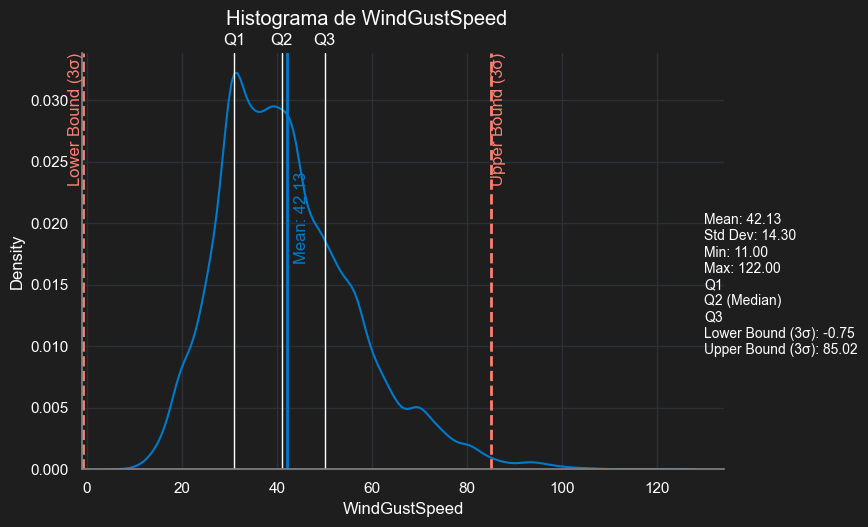

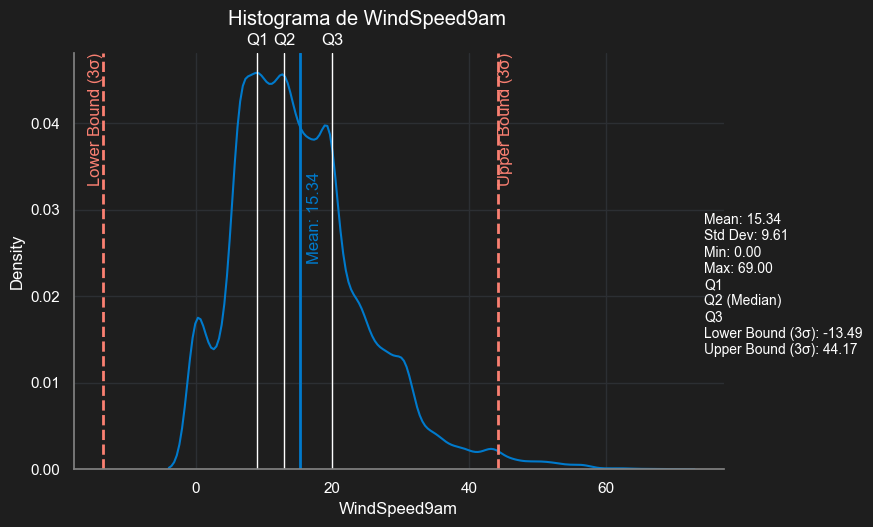

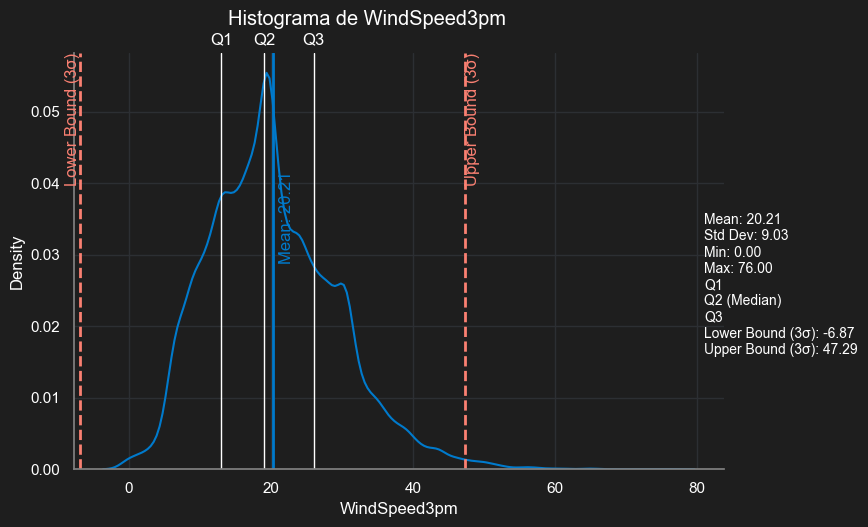

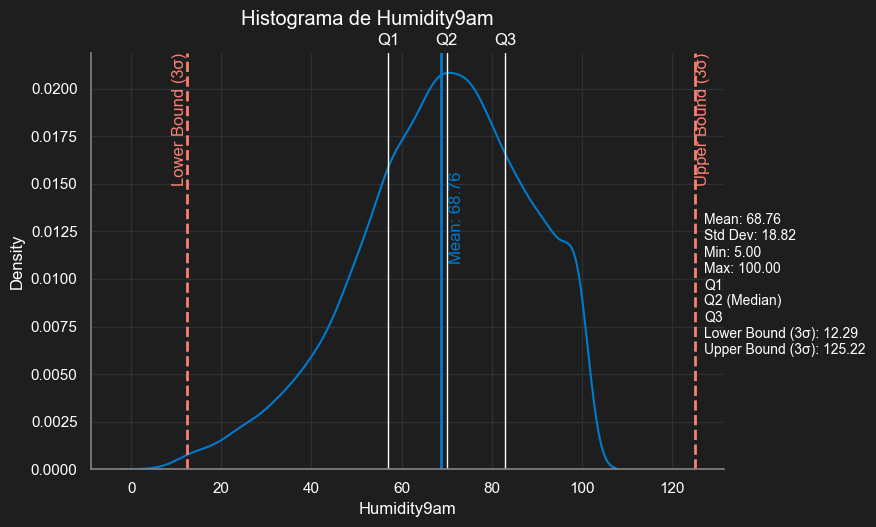

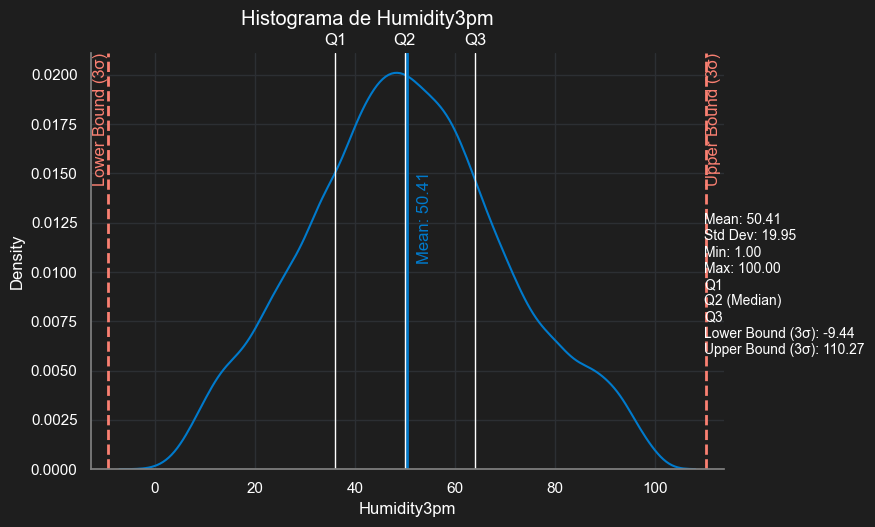

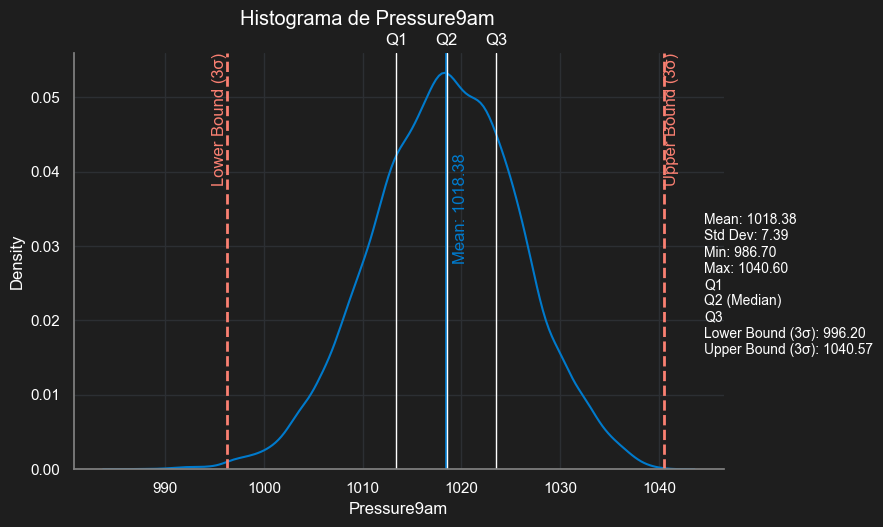

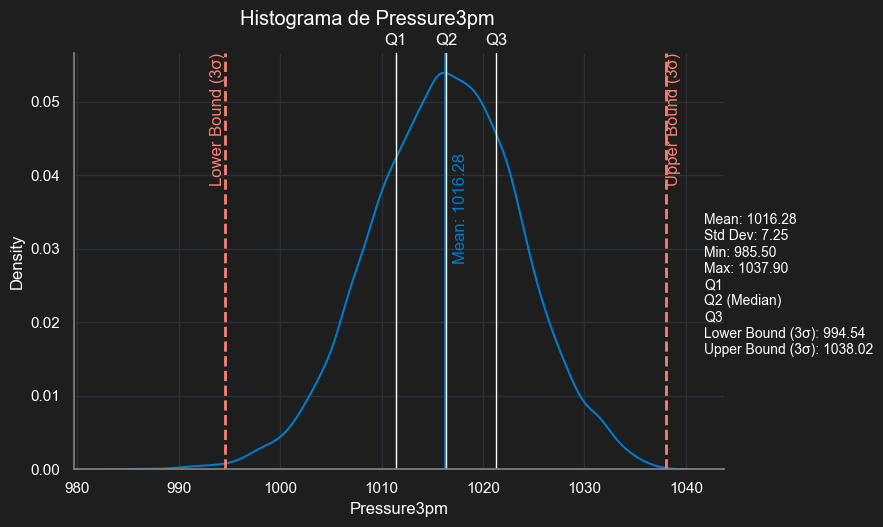

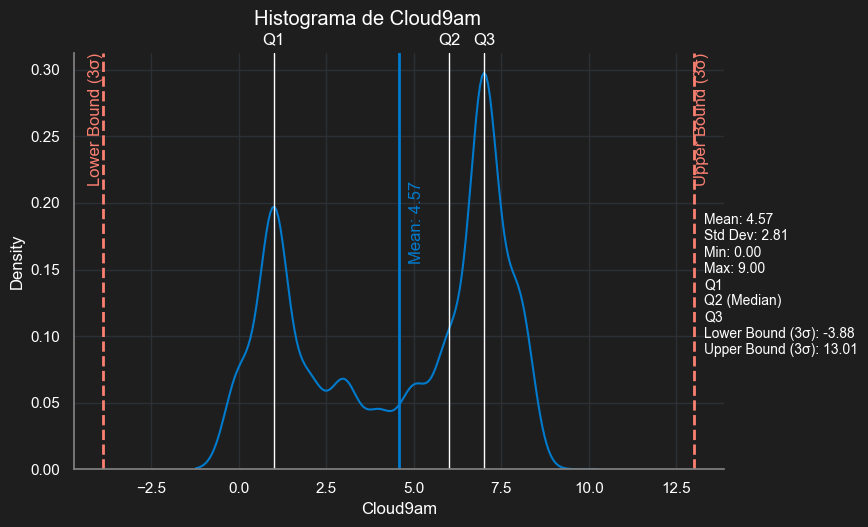

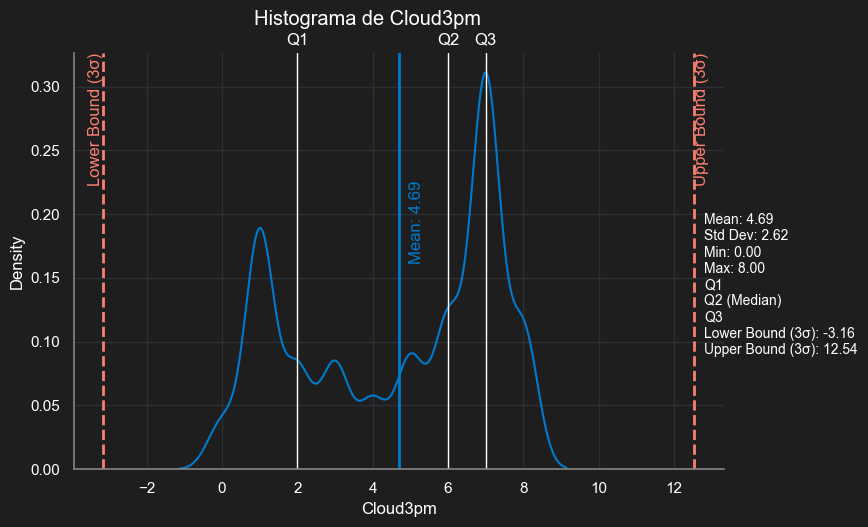

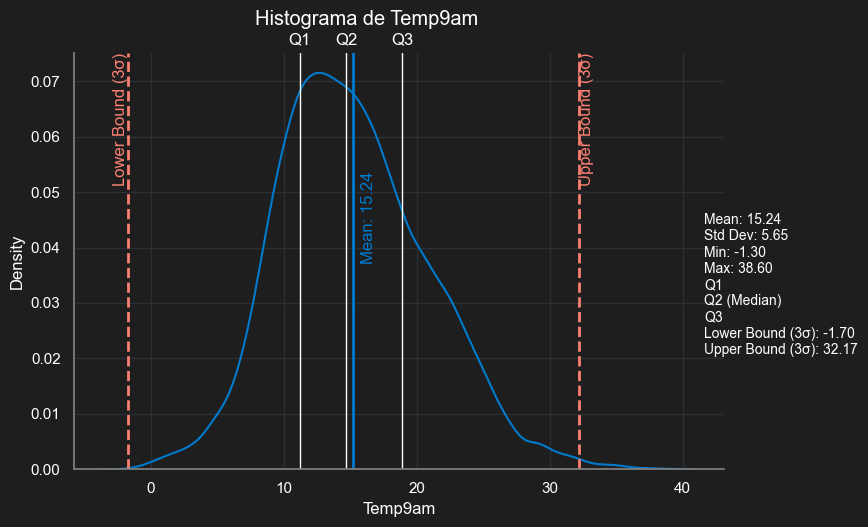

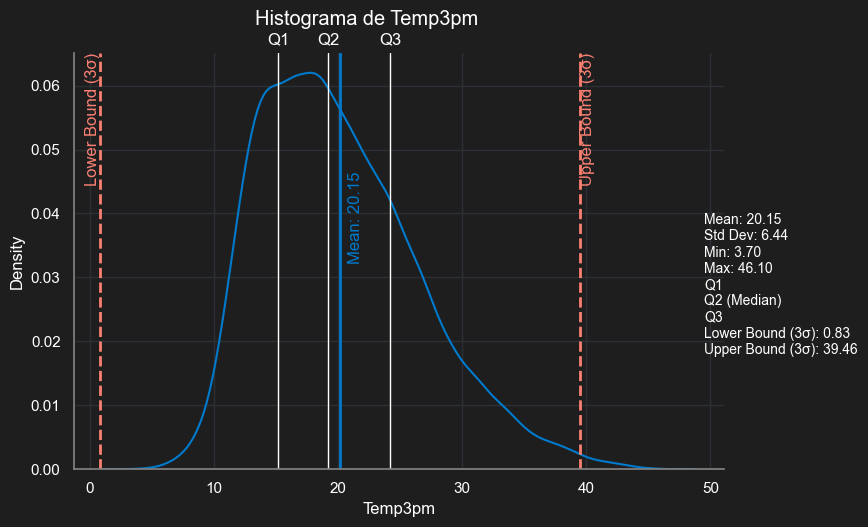

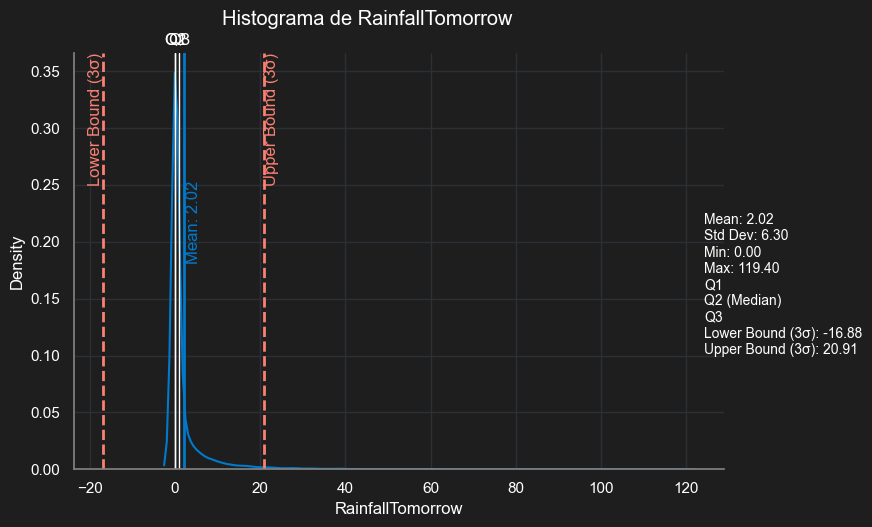

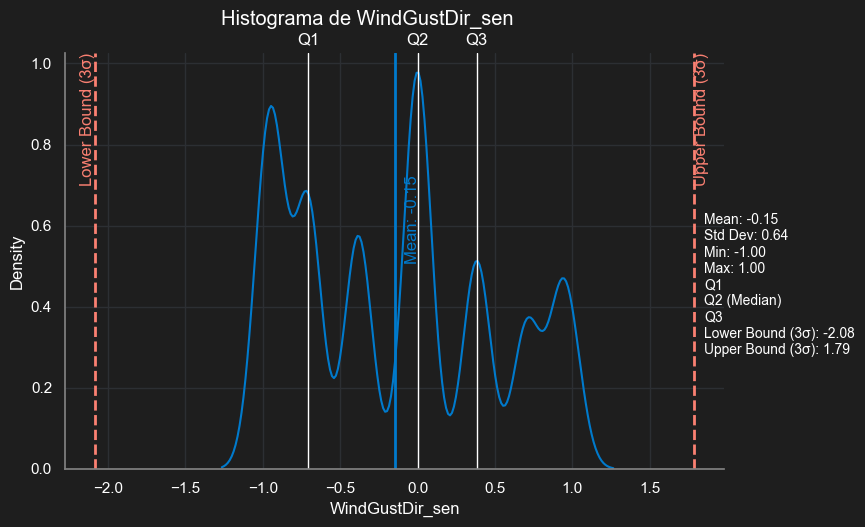

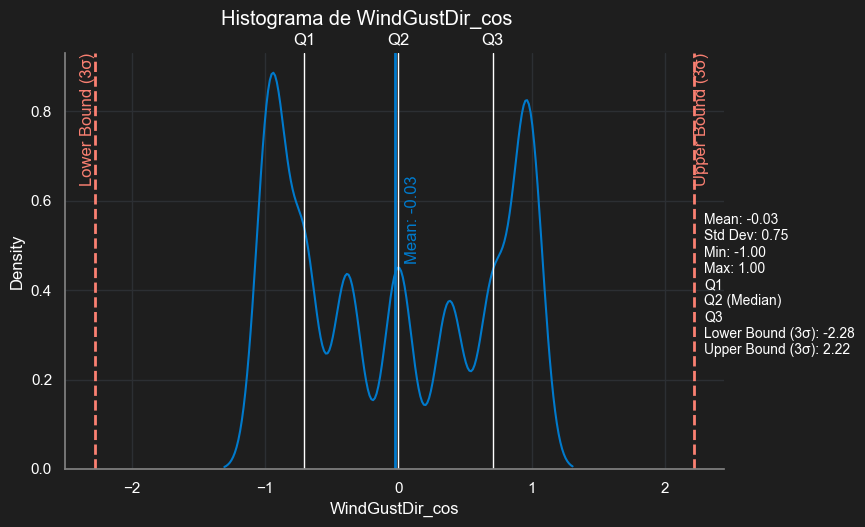

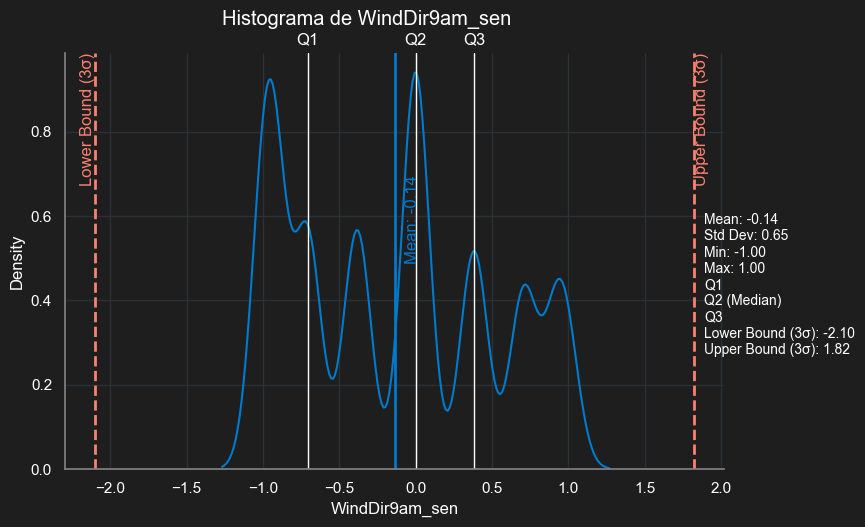

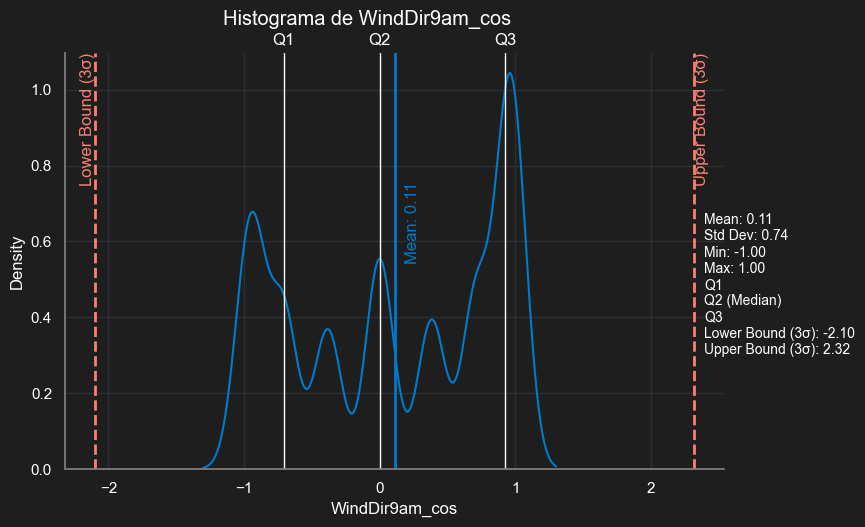

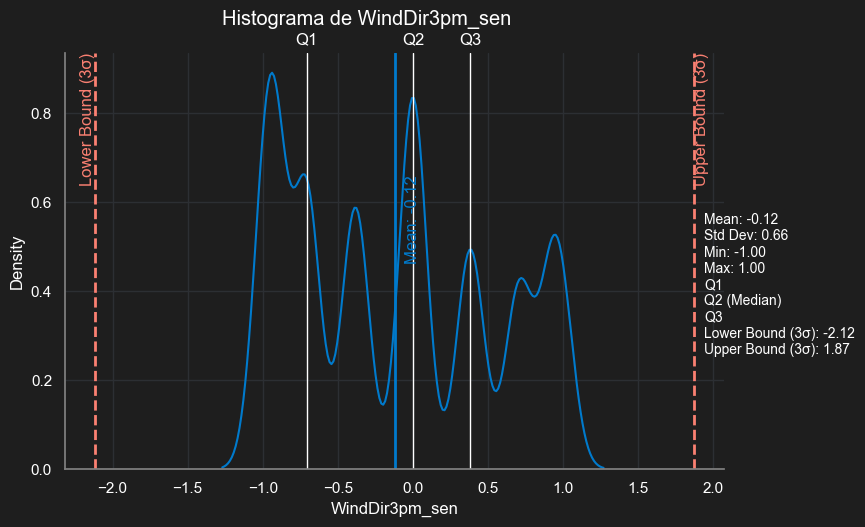

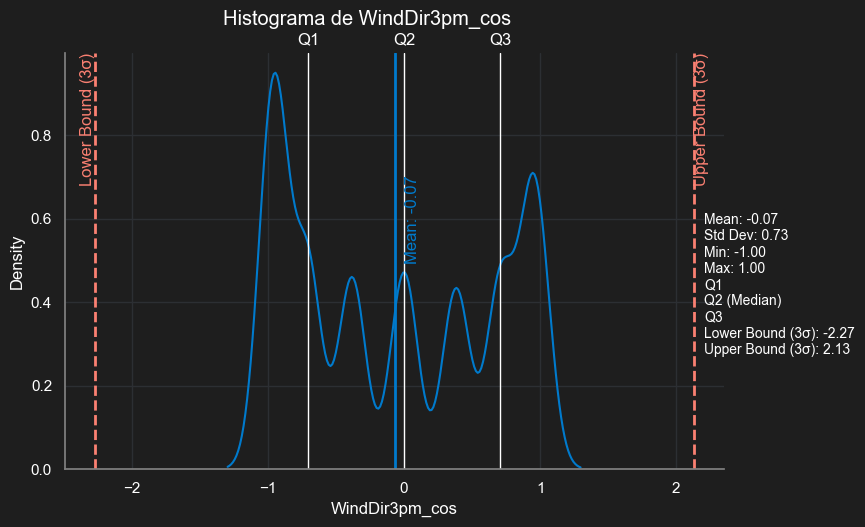

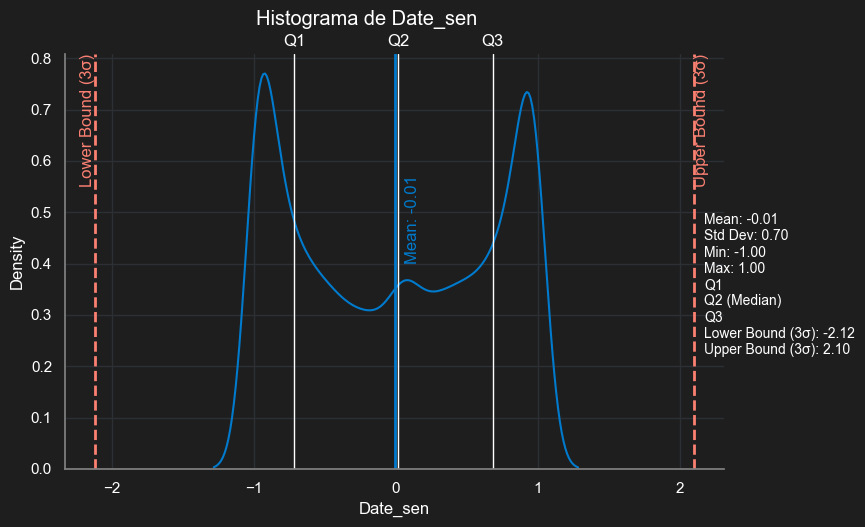

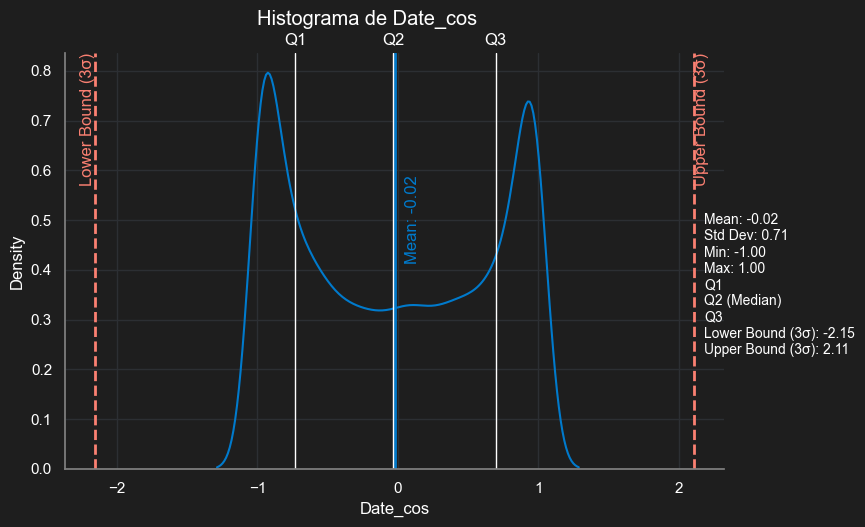

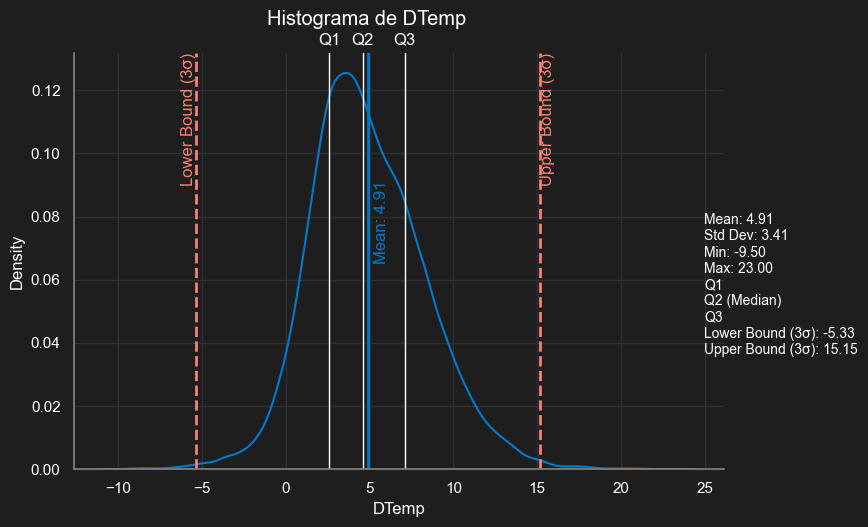

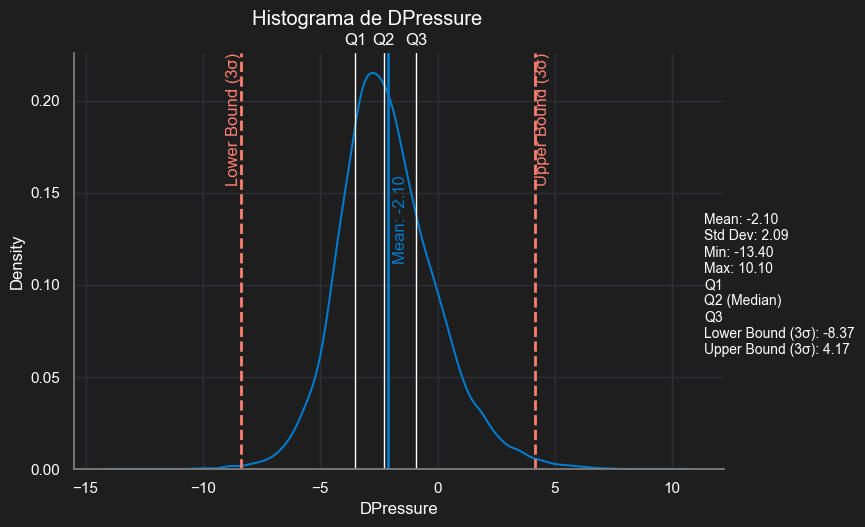

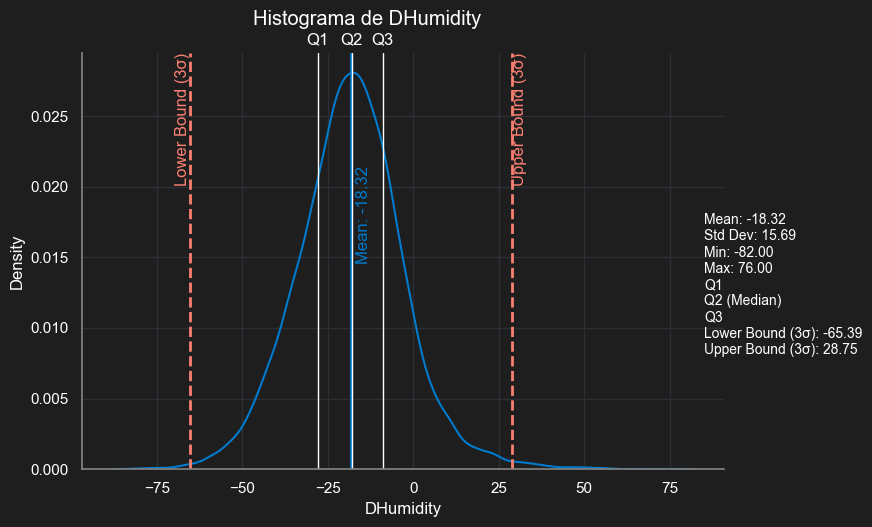

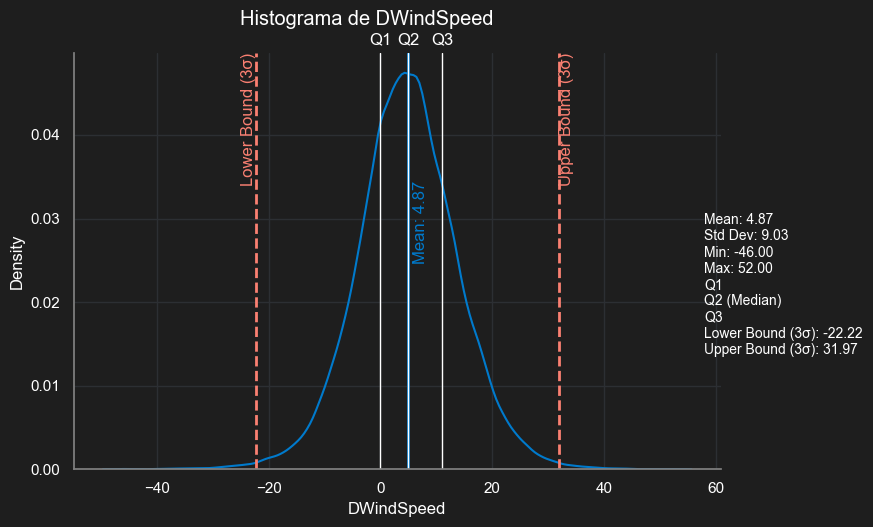

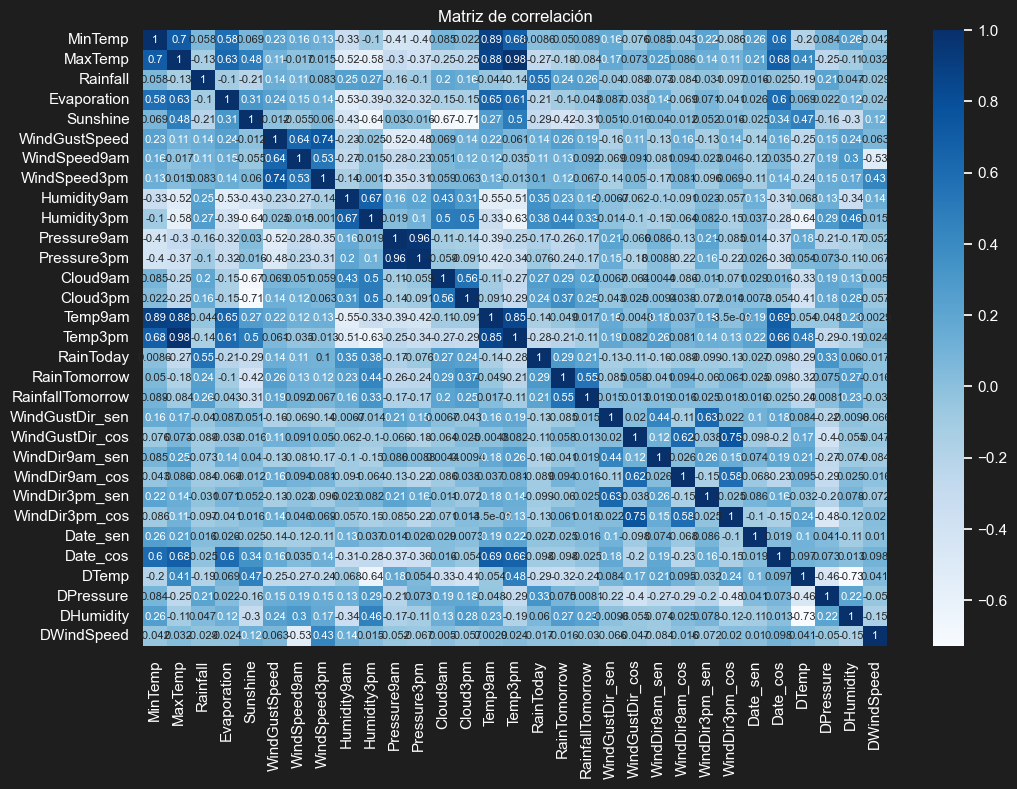

In [28]:
explorar(df_train)

Se encuentran correlaciones muy altas entre MinTemp y Temp9am, y MaxTemp y Temp3pm, que permiten eliminar MinTemp y MaxTemp:

In [29]:
df_train = df_train.drop(columns=['MinTemp'])
df_train = df_train.drop(columns=['MaxTemp'])

#### Balance de los datos objetivo

In [30]:
# Contar el número de ocurrencias de cada categoría en la columna 'RainTomorrow'
conteo_categorias = df_train['RainTomorrow'].value_counts()

# Imprimir los resultados
print("Proporción de 'RainTomorrow' igual a 0(No):", conteo_categorias[0] / len(df_train))
print("Proporción de 'RainTomorrow' igual a 1(Yes):", conteo_categorias[1] / len(df_train))


Proporción de 'RainTomorrow' igual a 0(No): 0.7373173970783532
Proporción de 'RainTomorrow' igual a 1(Yes): 0.22983621071270474


Se observa una gran disparidad en el número de muestras entre las clases 0 y 1 para la variable objetivo RainToday, es decir que la muestra se considera desbalanceado.

Esta situación puede afectar el rendimiento y la interpretación de los modelos de machine learning ya que pueden estar sesgados hacia las clases mayoritarias en datasets desbalanceados, lo que puede llevar a una predicción incorrecta para las clases minoritarias.

#### Tratamiento de valores atípicos en df_train

Se analizan los valores atípicos de Rainfall y Evaporation.

Importante: se considera un total de 5% de datos para poder eliminar tanto por tener valore atípicos como valores nulos.

##### Rainfall

Para la variable Rainfall, se calcula la proporción de valores que superan a la media más 3 desviaciones standard:

In [31]:
# Calcula el límite superior, que es la media más 3 desviaciones estándar
upper_limit = df_train['Rainfall'].mean() + 3 * df_train['Rainfall'].std()
# Usa este límite para contar cuántos valores están por encima de él
count_above_upper_limit = (df_train['Rainfall'] > upper_limit).sum()
print(f"Proporción de valores sobre 3 desviaciones stantard para 'Rainfall': {count_above_upper_limit/df_train_len}")

Proporción de valores sobre 3 desviaciones stantard para 'Rainfall': 0.019167773351040283


Se remueve sólo el 1% de los datos y no el 1,9%, para dejar un margen disponible de 4% de datos a borrar.

In [32]:
# Filtrar el DataFrame para mantener solo las filas donde los valores de 'Rainfall' son menores o iguales al límite superior
#df_train_temp = df_train[df_train['Rainfall'] <= upper_limit]
# Filtrar el DataFrame para mantener solo las filas por debajo del valor del último percentil
df_train_temp = df_train[df_train['Rainfall'] < df_train['Rainfall'].quantile(0.99)]
print(f"Número de filas luego de remover atípicos: {len(df_train_temp)}")

Número de filas luego de remover atípicos: 21629


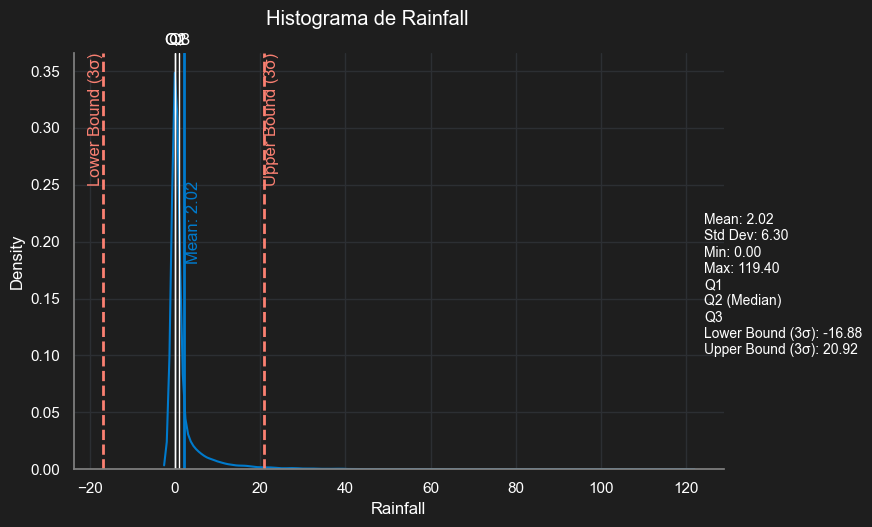

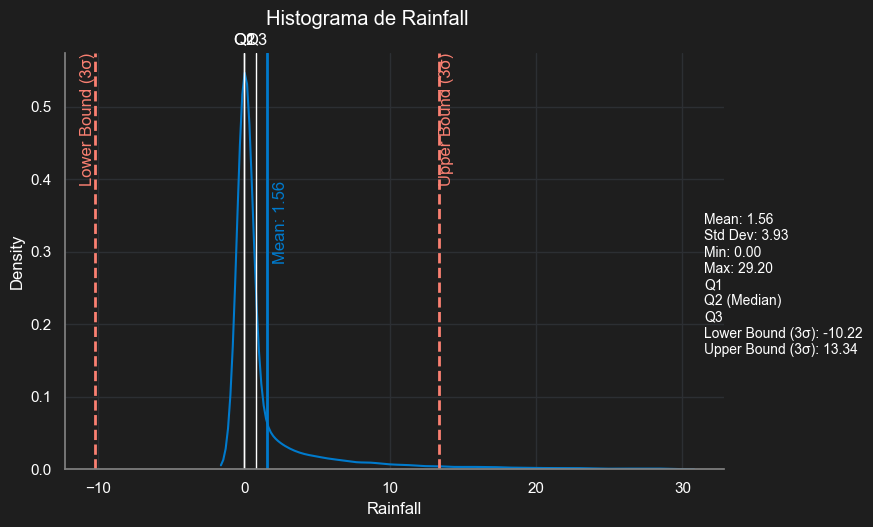

In [33]:
histograma(df_train,'Rainfall')
histograma(df_train_temp,'Rainfall')

Comparando ambos histogramas, se observa una mejora en la distribución de los datos.

In [34]:
#Se actualiza df_train
df_train=df_train_temp

##### Evaporation

In [35]:
# Calcula el límite superior, que es la media más 3 desviaciones estándar
upper_limit = df_train['Evaporation'].mean() + 3 * df_train['Evaporation'].std()
# Usa este límite para contar cuántos valores están por encima de él
count_above_upper_limit = (df['Evaporation'] > upper_limit).sum()
print(f"Proporción de valores sobre 3 desviaciones stantard para 'Evaporation': {count_above_upper_limit/df_train_len}")

Proporción de valores sobre 3 desviaciones stantard para 'Evaporation': 0.013235945108455069


Se remueve sólo el 1% de los datos y no el 1,3%, para dejar un margen disponible de 3% de datos a borrar.

In [36]:
# Filtrar el DataFrame para mantener solo las filas donde los valores de 'Evaporation' son menores o iguales al límite superior
#df_train_temp = df_train[df_train['Evaporation'] <= upper_limit]
# Filtrar el DataFrame para mantener solo las filas por debajo del valor del último percentil
df_train_temp = df_train[df_train['Evaporation'] < df_train['Evaporation'].quantile(0.99)]
print(f"Número de filas luego de remover atípicos: {len(df_train_temp)}")

Número de filas luego de remover atípicos: 19580


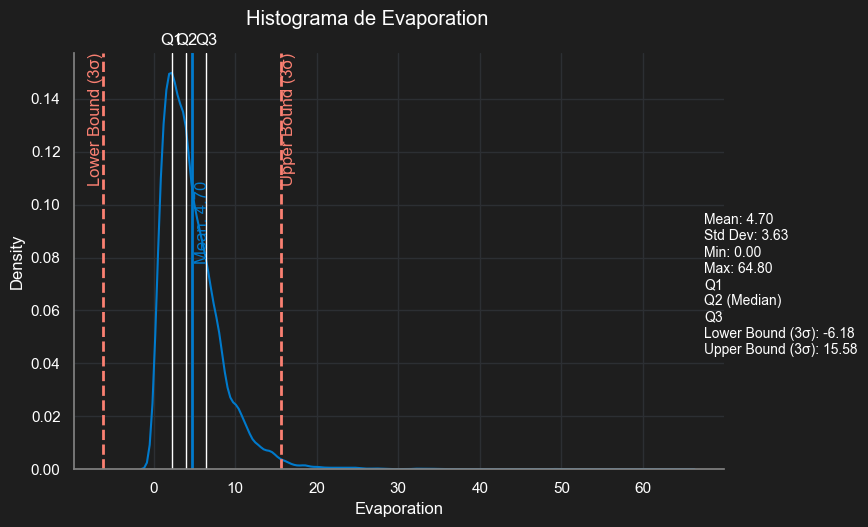

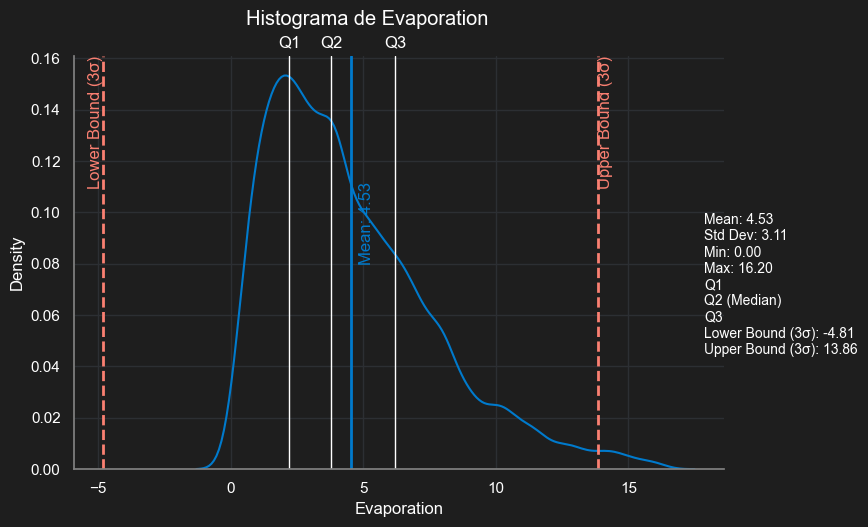

In [37]:
histograma(df_train,'Evaporation')
histograma(df_train_temp,'Evaporation')

Comparando ambos histogramas, se observa una mejora en la distribución de los datos.

In [38]:
#Se actualiza df_train
df_train=df_train_temp

#### Imputación de nulos en df_train

##### Primeros análisis

Se cuenta la cantidad de filas con al menos un valor nan. Dicho valor debe ser menor al 3% del total de registros. Se observa que el segundo valor supera al primero, por lo que deberá analizarse el tratamiento a dar a los valores nan para su reemplazo.

In [39]:
print(int(df_train_len*.03))

677


In [40]:
# Contar filas que contienen al menos un valor NaN
print(f'Número de filas con al menos un valor NaN: {df_train.isna().any(axis=1).sum()}')

Número de filas con al menos un valor NaN: 8645


In [41]:
# Cantidad de valores faltantes.
df_train.isna().sum().sort_values(ascending=False)

Cloud3pm            5271
Cloud9am            4960
Sunshine            2540
WindGustDir_cos     1435
WindGustDir_sen     1435
WindGustSpeed       1432
WindDir9am_cos      1146
WindDir9am_sen      1146
WindDir3pm_sen       334
WindDir3pm_cos       334
DPressure            311
DWindSpeed           302
DHumidity            288
Pressure9am          276
WindSpeed9am         276
Pressure3pm          272
WindSpeed3pm         262
Humidity9am          255
Humidity3pm          216
RainTomorrow         206
RainfallTomorrow     206
DTemp                 52
Temp9am               31
Temp3pm               26
RainToday              0
Date_sen               0
Date_cos               0
Location               0
Evaporation            0
Rainfall               0
Date                   0
dtype: int64

Se analiza a continuación cada variable, con su variable más correlacionada, y la cantidad de nulos de cada una:

#### Matriz de distancias geodésicas

Se construye una matriz con las distancias entre todas las ciudades del df original, que ayudará a comprender la posibilidad de adoptar valores de ciudades aledañas:

In [42]:
# Coordenadas de las ciudades
cities_coords_9 = {
    'Adelaide': (-34.9285, 138.6007),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'Dartmoor': (-37.9225, 141.2760),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'MountGambier': (-37.8284, 140.7804),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753)
}

cities_coords = {
    'Adelaide': (-34.9285, 138.6007),
    'Albany': (-35.0228, 117.8814),
    'AliceSprings': (-23.6980, 133.8807),
    'Albury': (-36.0737, 146.9135),
    'BadgerysCreek': (-33.8817, 150.7440),
    'Ballarat': (-37.5622, 143.8503),
    'Bendigo': (-36.7570, 144.2784),
    'Brisbane': (-27.4698, 153.0251),
    'Cairns': (-16.9186, 145.7781),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'CoffsHarbour': (-30.2963, 153.1157),
    'Darwin': (-12.4634, 130.8456),
    'Dartmoor': (-37.9225, 141.2760),
    'GoldCoast': (-28.0167, 153.4000),
    'Hobart': (-42.8821, 147.3272),
    'Katherine': (-14.4646, 132.2635),
    'Launceston': (-41.4341, 147.1374),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'Mildura': (-34.1847, 142.1625),
    'Moree': (-29.4658, 149.8407),
    'MountGambier': (-37.8284, 140.7804),
    'MountGinini': (-35.5294, 148.7744),
    'Newcastle': (-32.9272, 151.7765),
    'Nhil': (-36.3348, 141.6503),
    'NorahHead': (-33.2821, 151.5671),
    'NorfolkIsland': (-29.0408, 167.9547),
    'Nuriootpa': (-34.4694, 138.9939),
    'Penrith': (-33.7511, 150.6942),
    'Perth': (-31.9505, 115.8605),
    'PerthAirport': (-31.9403, 115.9672),
    'PearceRAAF': (-31.6736, 116.0174),
    'Portland': (-38.3463, 141.6042),
    'Richmond': (-33.5995, 150.7391),
    'Sale': (-38.1118, 147.0680),
    'SalmonGums': (-32.9815, 121.6438),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753),
    'Townsville': (-19.2580, 146.8169),
    'Tuggeranong': (-35.4244, 149.0888),
    'Uluru': (-25.3455, 131.0369),
    'WaggaWagga': (-35.1082, 147.3598),
    'Walpole': (-34.9777, 116.7338),
    'Watsonia': (-37.7110, 145.0830),
    'Williamtown': (-32.8150, 151.8428),
    'Witchcliffe': (-34.0261, 115.1003),
    'Wollongong': (-34.4278, 150.8931),
    'Woomera': (-31.1994, 136.8253)
}
# Crear un DataFrame vacío
dist_matrix = pd.DataFrame(index=cities_coords.keys(), columns=cities_coords.keys())
# Calcular las distancias y llenar la matriz
for city1 in cities_coords:
    for city2 in cities_coords:
        dist = geodesic(cities_coords[city1], cities_coords[city2]).kilometers
        dist_matrix.at[city1, city2] = round(dist, 2)
# Mostrar la matriz de distancias
print(dist_matrix)


                 Adelaide   Albany AliceSprings   Albury BadgerysCreek  \
Adelaide              0.0   1888.6      1326.08   764.58       1121.82   
Albany             1888.6      0.0      1992.48  2625.31       3008.83   
AliceSprings      1326.08  1992.48          0.0  1858.21       1991.62   
Albury             764.58  2625.31      1858.21      0.0        425.94   
BadgerysCreek     1121.82  3008.83      1991.62   425.94           0.0   
Ballarat           554.88   2342.2       1807.3   319.32        745.19   
Bendigo            551.48  2383.56      1757.34   248.19        668.67   
Brisbane           1601.7   3431.8      1966.04   1115.3        743.63   
Cairns            2119.21  3418.42      1450.56  2125.39       1943.74   
Canberra           960.32  2835.57      1953.86   219.08        214.52   
Cobar              773.97  2625.02      1461.11   517.23        530.79   
CoffsHarbour      1454.23  3329.19      2040.92   862.77        456.25   
Darwin            2608.53  2820.24    

In [43]:
# Crear un mapa centrado en Australia
mapa = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)  # zoom_start ajustable según la necesidad
# Añadir marcadores naranjas para las ciudades en cities_coords_9
for city, coords in cities_coords_9.items():
    folium.Marker(
        location=coords,
        popup=city,
        icon=folium.Icon(color='orange')
    ).add_to(mapa)
# Añadir marcadores azules para las ciudades que están en cities_coords pero no en cities_coords_9
for city, coords in cities_coords.items():
    if city not in cities_coords_9:
        folium.Marker(
            location=coords,
            popup=city,
            icon=folium.Icon(color='blue')
        ).add_to(mapa)

In [44]:
# Mostrar el mapa
mapa

#### Análisis nan por distancias

Se crea la función general procesar_geo_nan, que permite analizar y reemplazar los datos nulos por aquellos del mismo día para ciudades vecinas, con un radio de km a definir.

Luego, se hace un análisis pormenorizado de los demás valores nulos, reemplazando con datos de ciudades más lejanas pero en donde se observa una buena correlación de los datos, utilizando gráficos de dispersión para comparar entre ciudades.

In [45]:
df_train = procesar_geo_nan(df_train, df_49, dist_matrix, cities_coords, 350)

Procesando las siguientes columnas: ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_sen', 'WindGustDir_cos', 'WindDir9am_sen', 'WindDir9am_cos', 'WindDir3pm_sen', 'WindDir3pm_cos', 'Date_sen', 'Date_cos', 'DTemp', 'DPressure', 'DHumidity', 'DWindSpeed']
El rango fijado para ciudades cercanas es (km): 350
Analizando la variable: Rainfall
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, Rainfall NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Evaporation
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, Evaporation NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Sunshine
Resultado del análisis geográfico:
            Location  Sunshine NaN Count   Nearest City Distance (km)
0             Cobar                1699     Wagga

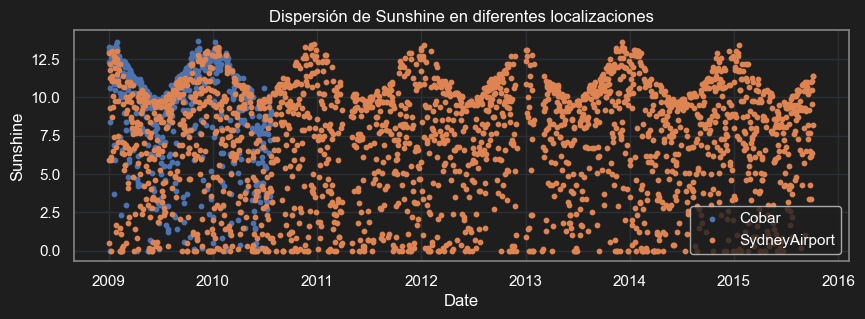

Location  Sunshine NaN Count   Nearest City Distance (km)
0          Cobar                1699     WaggaWagga        424.81
1   MountGambier                  11       Dartmoor         44.84
2       Adelaide                   2      Nuriootpa         62.38
3         Sydney                   2  SydneyAirport          8.49
4  SydneyAirport                   2         Sydney          8.49

In [46]:
variable='Sunshine'
location='Cobar'
location_near='SydneyAirport'
graf_dispersion_comparativa(df_train, [location, location_near], 'Date',variable)
analisis_geo_nan(df_train, variable, dist_matrix, cities_coords)

In [47]:
df_train = recrear_geo_nan(df_train,df_49,'Cobar','SydneyAirport','Sunshine')

La cantidad de datos reemplazados fue 1694


In [48]:
nan_rows_count_filtered = df_train.drop(columns=['RainTomorrow', 'RainfallTomorrow']).isna().any(axis=1).sum()
print(f'Proporción de filas con al menos un valor NaN dentro de las variables predictivas: {nan_rows_count_filtered/df_train_len}')

Proporción de filas con al menos un valor NaN dentro de las variables predictivas: 0.011775121735281098


Se eliminan los registros con al menos un nan, ya que la suma total representa menos del 3% del total de datos.

In [49]:
df_train=df_train.dropna()
nan_rows_count_filtered = df_train.drop(columns=['RainTomorrow', 'RainfallTomorrow']).isna().any(axis=1).sum()
print(f'Número de filas con al menos un valor NaN dentro de las variables predictivas: {nan_rows_count_filtered}')

Número de filas con al menos un valor NaN dentro de las variables predictivas: 0


#### Ajuste df_test

Se realizan los ajustes de atípicos e imputación de nans respetando lo hecho en df_train.

In [50]:
df_test = df_test.drop(columns=['MinTemp'])
df_test = df_test.drop(columns=['MaxTemp'])

##### Atípicos Rainfall

Para la variable Rainfall, se calcula la proporción de valores que superan a la media más 3 desviaciones standard:

In [51]:
# Calcula el límite superior, que es la media más 3 desviaciones estándar
upper_limit = df_test['Rainfall'].mean() + 3 * df_test['Rainfall'].std()
# Usa este límite para contar cuántos valores están por encima de él
count_above_upper_limit = (df_test['Rainfall'] > upper_limit).sum()
print(f"Proporción de valores sobre 3 desviaciones stantard para 'Rainfall': {count_above_upper_limit/df_test_len}")

Proporción de valores sobre 3 desviaciones stantard para 'Rainfall': 0.023391812865497075


Se remueve sólo el 1% de los datos para dejar un margen disponible de 4% de datos a borrar.

In [52]:
# Filtrar el DataFrame para mantener solo las filas donde los valores de 'Rainfall' son menores o iguales al límite superior
#df_train_temp = df_train[df_train['Rainfall'] <= upper_limit]
# Filtrar el DataFrame para mantener solo las filas por debajo del valor del último percentil
df_test_temp = df_test[df_test['Rainfall'] < df_test['Rainfall'].quantile(0.99)]
print(f"Número de filas luego de remover atípicos: {len(df_test_temp)}")

Número de filas luego de remover atípicos: 5344


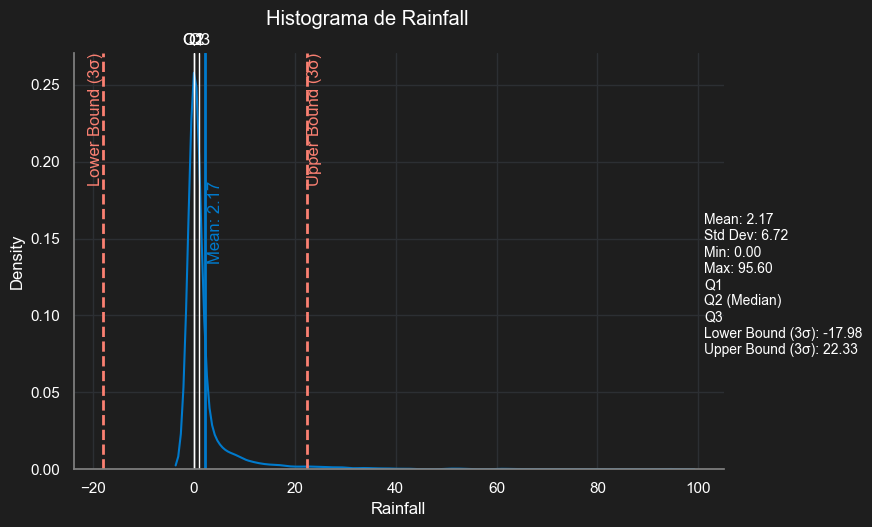

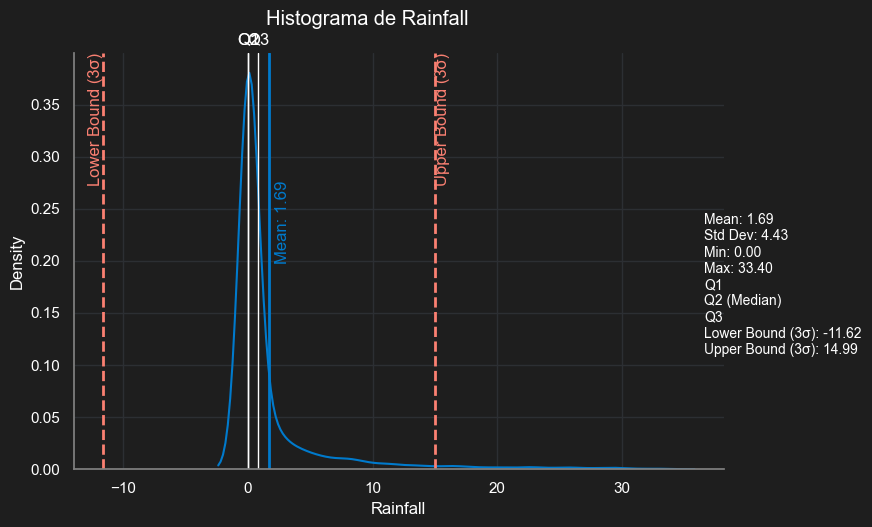

In [53]:
histograma(df_test,'Rainfall')
histograma(df_test_temp,'Rainfall')

Comparando ambos histogramas, se observa una mejora en la distribución de los datos.

In [54]:
#Se actualiza df_train
df_test=df_test_temp

##### Atípicos Evaporation

In [55]:
# Calcula el límite superior, que es la media más 3 desviaciones estándar
upper_limit = df_test['Evaporation'].mean() + 3 * df_test['Evaporation'].std()
# Usa este límite para contar cuántos valores están por encima de él
count_above_upper_limit = (df_test['Evaporation'] > upper_limit).sum()
print(f"Proporción de valores sobre 3 desviaciones stantard para 'Evaporation': {count_above_upper_limit/df_test_len}")

Proporción de valores sobre 3 desviaciones stantard para 'Evaporation': 0.003189792663476874


Se remueven los valores atípicos, los cuales representan menos del 1% de los datos, dejando un margen del 3.7% de datos a borrar.

In [56]:
# Filtrar el DataFrame para mantener solo las filas donde los valores de 'Evaporation' son menores o iguales al límite superior
df_test_temp = df_test[df_test['Evaporation'] <= upper_limit]
print(f"Número de filas luego de remover atípicos: {len(df_test_temp)}")

Número de filas luego de remover atípicos: 3046


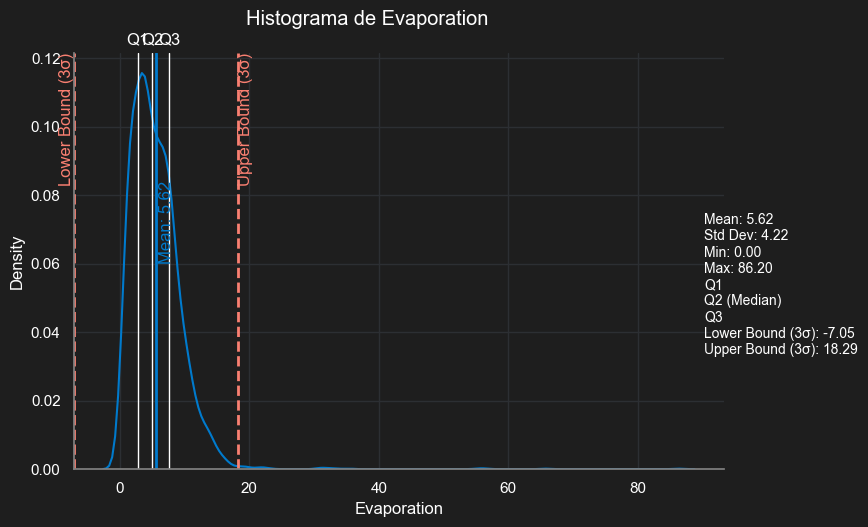

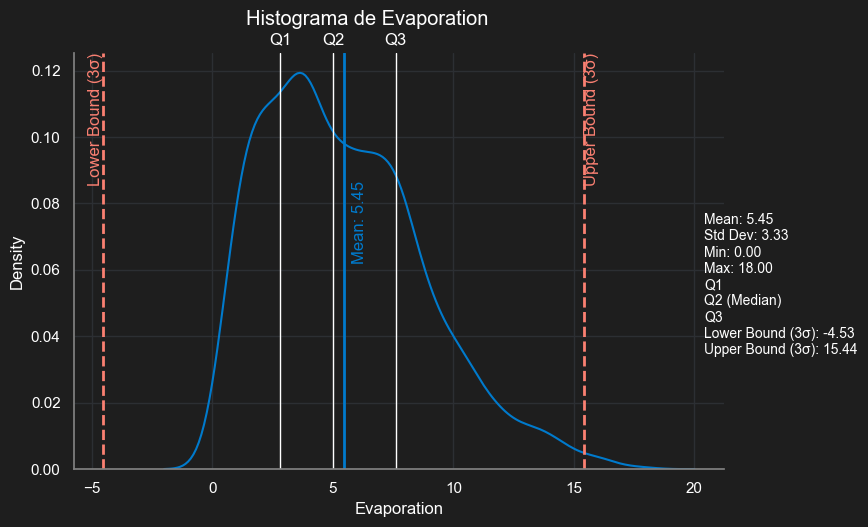

In [57]:
histograma(df_test,'Evaporation')
histograma(df_test_temp,'Evaporation')

Comparando ambos histogramas, se observa una mejora en la distribución de los datos.

In [58]:
#Se actualiza df_train
df_test=df_test_temp

##### Imputación de nulos

Se cuenta la cantidad de filas con al menos un valor nan. Dicho valor debe ser menor al 3.7% del total de registros.

In [59]:
print(int(df_test_len*.037))

208


In [60]:
# Contar filas que contienen al menos un valor NaN
print(f'Número de filas con al menos un valor NaN: {df_test.isna().any(axis=1).sum()}')

Número de filas con al menos un valor NaN: 693


In [61]:
# Cantidad de valores faltantes.
df_test.isna().sum().sort_values(ascending=False)

Sunshine            426
Cloud9am            346
Cloud3pm            306
DHumidity            51
Humidity3pm          50
Humidity9am          48
WindDir9am_cos       45
WindDir9am_sen       45
WindGustSpeed        21
WindGustDir_cos      21
WindGustDir_sen      21
WindDir3pm_cos       10
WindDir3pm_sen       10
RainTomorrow          8
RainfallTomorrow      8
DPressure             3
Pressure3pm           2
Pressure9am           2
WindSpeed3pm          1
WindSpeed9am          1
DWindSpeed            1
DTemp                 0
Date_cos              0
Date_sen              0
Date                  0
RainToday             0
Location              0
Temp9am               0
Evaporation           0
Rainfall              0
Temp3pm               0
dtype: int64

In [62]:
df_test = procesar_geo_nan(df_test, df_49, dist_matrix, cities_coords, 350)

Procesando las siguientes columnas: ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_sen', 'WindGustDir_cos', 'WindDir9am_sen', 'WindDir9am_cos', 'WindDir3pm_sen', 'WindDir3pm_cos', 'Date_sen', 'Date_cos', 'DTemp', 'DPressure', 'DHumidity', 'DWindSpeed']
El rango fijado para ciudades cercanas es (km): 350
Analizando la variable: Rainfall
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, Rainfall NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Evaporation
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, Evaporation NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Sunshine
Resultado del análisis geográfico:
         Location  Sunshine NaN Count   Nearest City Distance (km)
0          Cobar                 344     WaggaWagga 

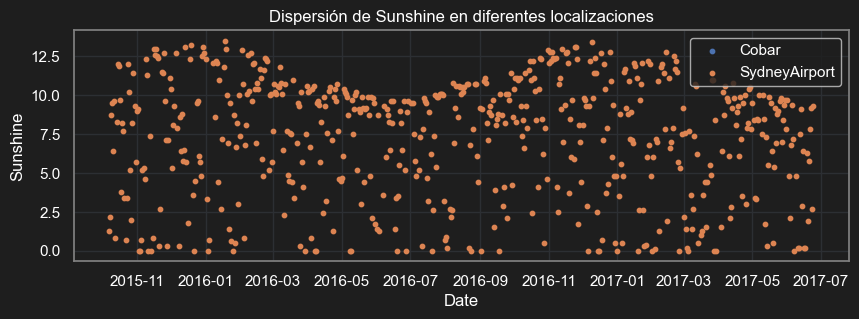

Location  Sunshine NaN Count   Nearest City Distance (km)
0          Cobar                 344     WaggaWagga        424.81
1   MountGambier                  35       Dartmoor         44.84
2  SydneyAirport                   5         Sydney          8.49
3         Sydney                   5  SydneyAirport          8.49

In [63]:
variable='Sunshine'
location='Cobar'
location_near='SydneyAirport'
graf_dispersion_comparativa(df_test, [location, location_near], 'Date',variable)
analisis_geo_nan(df_test, variable, dist_matrix, cities_coords)

In [64]:
df_test[df_test['Location'] == 'Cobar'].shape[0]

344

Se oberva que todas las filas de Cobar, en df_test tienen valores nulos para la variables Sunshine. Se reemplazan los valores por los de SydneyAirport, como se hizo en df_train.

In [65]:
df_test = recrear_geo_nan(df_test,df_49,'Cobar','SydneyAirport','Sunshine')

La cantidad de datos reemplazados fue 339


In [66]:
nan_rows_count_filtered = df_test.drop(columns=['RainTomorrow', 'RainfallTomorrow']).isna().any(axis=1).sum()
print(f'Proporción de filas con al menos un valor NaN dentro de las variables predictivas: {nan_rows_count_filtered/df_test_len}')

Proporción de filas con al menos un valor NaN dentro de las variables predictivas: 0.03189792663476874


Se eliminan los registros con al menos un nan, ya que la suma total representa menos del 3.7% del total de datos.

In [67]:
df_test=df_test.dropna()
nan_rows_count_filtered = df_test.drop(columns=['RainTomorrow', 'RainfallTomorrow']).isna().any(axis=1).sum()
print(f'Número de filas con al menos un valor NaN dentro de las variables predictivas: {nan_rows_count_filtered}')

Número de filas con al menos un valor NaN dentro de las variables predictivas: 0


#### División de datos X_train, y_train, X_test, y_test

Se aplicarán diversos modelos a los datos, los cuales se dividen en:
* X_train
* y_train 
* X_test
* y_test.

Se construye la función split para uso general.

In [68]:
def split(df_train, df_test,metodo='regresion'):
    if metodo == 'regresion':
        #Conjuntos de datos para entrenamiento
        X_train = df_train.drop(['Date', 'Location', 'RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_train = df_train[['RainfallTomorrow']]

        #Conjuntos de datos para testeo
        X_test = df_test.drop(['Date', 'Location', 'RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_test = df_test[['RainfallTomorrow']]

    elif metodo == 'clasificacion':
        #Conjuntos de datos para entrenamiento
        X_train = df_train.drop(['Date', 'Location', 'RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_train = df_train[['RainTomorrow']]

        #Conjuntos de datos para testeo
        X_test = df_test.drop(['Date', 'Location', 'RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_test = df_test[['RainTomorrow']]
    return X_train, y_train, X_test, y_test

### 4.Modelos de regresión lineal

In [69]:
X_train, y_train, X_test, y_test = split(df_train, df_test,metodo='regresion')

In [70]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19118, 27), (2860, 27), (19118, 1), (2860, 1))

#### Método de mínimos cuadrados (OLS)

In [71]:
# Se crea un pipeline para estandarizar los datos y aplicar luego un modelo de regresión lineal
model = make_pipeline(StandardScaler(), LinearRegression())

In [72]:
#Se ajusta el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

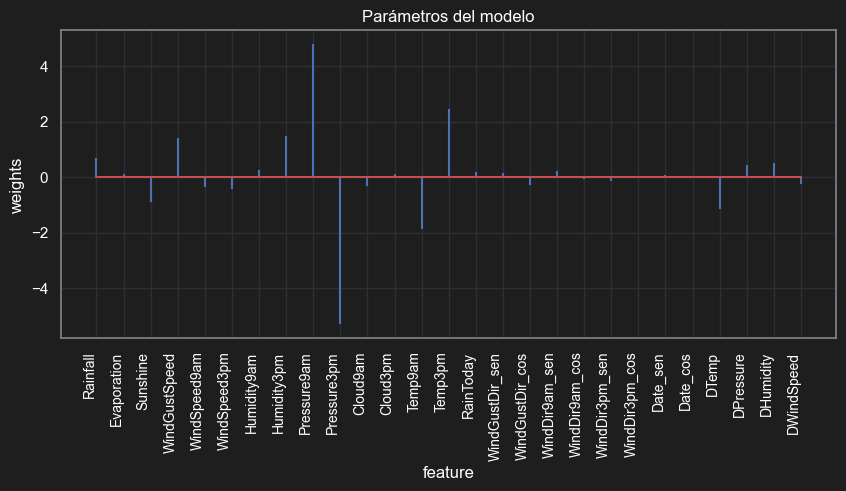

predictor      coef
0          Rainfall  0.708801
1       Evaporation  0.128045
2          Sunshine -0.874714
3     WindGustSpeed  1.414818
4      WindSpeed9am -0.350253
5      WindSpeed3pm -0.436393
6       Humidity9am  0.270969
7       Humidity3pm  1.489188
8       Pressure9am  4.796641
9       Pressure3pm -5.299605
10         Cloud9am -0.317110
11         Cloud3pm  0.122673
12          Temp9am -1.848409
13          Temp3pm  2.457846
14        RainToday  0.172323
15  WindGustDir_sen  0.146128
16  WindGustDir_cos -0.276222
17   WindDir9am_sen  0.218292
18   WindDir9am_cos -0.044273
19   WindDir3pm_sen -0.128623
20   WindDir3pm_cos  0.002062
21         Date_sen  0.064519
22         Date_cos  0.036929
23            DTemp -1.127247
24        DPressure  0.425701
25        DHumidity  0.512286
26       DWindSpeed -0.237381

In [73]:
# Se grafican los coeficientes del modelo del modelo
df_coeficientes = pd.DataFrame({'predictor': X_train.columns, 'coef': model.steps[1][1].coef_.flatten()})
fig, ax = plt.subplots(figsize=(10, 4))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo')
plt.show()

df_coeficientes[df_coeficientes.coef != 0]

Se observa que las variables de presión, temperatura, humedad a las 3pm y WindGustSpeed son las que mayor peso tienen en el modelo.

In [74]:
# Se guardan las predicciones del modelo
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Se calcula el error de train del modelo con rmse para mantener la misma escala que la variable a predecir
rmse_ols_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_ols_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"El error rmse_ols_train es: {rmse_ols_train}")
print(f"El error rmse_ols_test es: {rmse_ols_test}")

R2_ols_train = metrics.r2_score(y_train, y_pred_train)
print(f"El valor de R2_ols_train: {R2_ols_train}")
R2_ols_test = metrics.r2_score(y_test, y_pred_test)
print(f"El valor de R2_ols_test: {R2_ols_test}")

El error rmse_ols_train es: 5.379308724100758
El error rmse_ols_test es: 6.071117982786203
El valor de R2_ols_train: 0.21815716004020802
El valor de R2_ols_test: 0.20098594054107843


Se observa un bajo valor de R2, lo que determina que el modelo no logra explicar correctamente la variabilidad de los datos.

#### Gradiente descendente

Se aplica el método del Gradiente Descendente (GD), con sus variantes Gradiente Descendente Estocástico (GDE) y Gradiente Descendente Batch (GDB).
No se observan mejoras en los valores de rmse y R2 obtenidos, en comparación con los de Regresión Lineal.
Sí se observa un empeoramiento de las métricas para la variante Estocástica.
La variante GDB oscila entre ambos extremos, según el tamaño del batch.

In [75]:
# Se convierte y_train e y_test de dataframe a array:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [76]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

##### Gradiente descendente GD

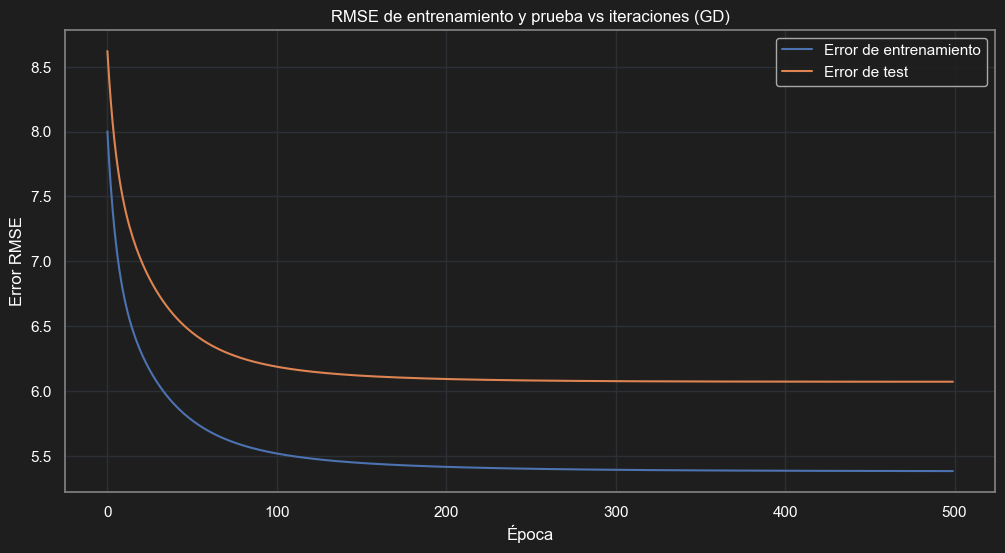

El error rmse_gd_train es: 5.381305407788843
El error rmse_gd_test es: 6.070565359682783
El valor de R2_gd_train: 0.21757664583389713
El valor de R2_gd_test: 0.2011313943221683


In [77]:
resultados_gd=gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=500, lr=0.01)

rmse_gd_train=resultados_gd['train_rmse']
rmse_gd_test=resultados_gd['test_rmse']
R2_gd_train=resultados_gd['train_r2']
R2_gd_test=resultados_gd['test_r2']

print(f"El error rmse_gd_train es: {rmse_gd_train}")
print(f"El error rmse_gd_test es: {rmse_gd_test}")
print(f"El valor de R2_gd_train: {R2_gd_train}")
print(f"El valor de R2_gd_test: {R2_gd_test}")

##### Gradiente descendente Estocástico GDE

Training Epochs: 100%|██████████| 100/100 [03:14<00:00,  1.95s/epoch]


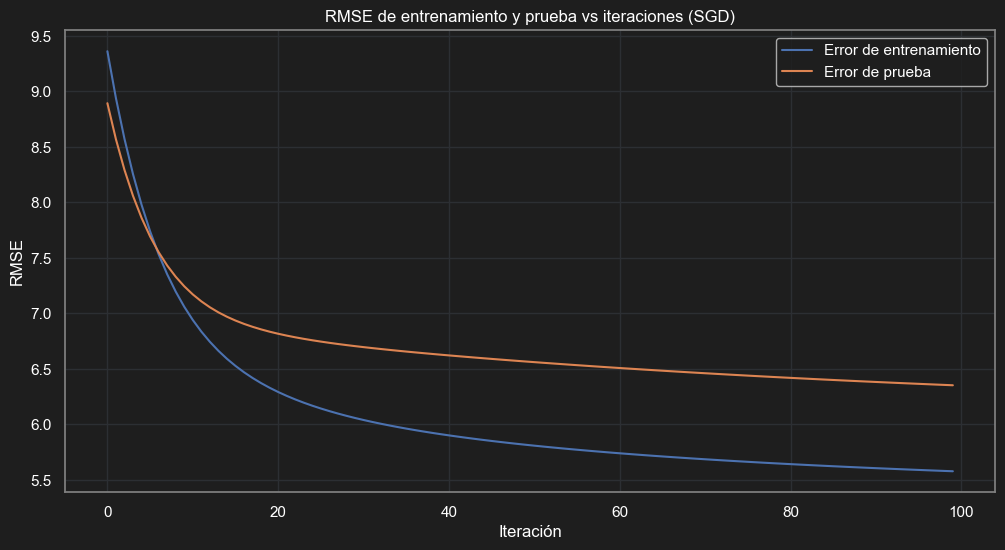

In [78]:
# Se considera un menor número de épocas para el entrenamiento de GDE
resultados_gde=stochastic_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=100, lr=0.01)

rmse_gde_train=resultados_gde['train_rmse']
rmse_gde_test=resultados_gde['test_rmse']
R2_gde_train=resultados_gde['train_r2']
R2_gde_test=resultados_gde['test_r2']

In [79]:
print(f"El error rmse_gde_train es: {rmse_gde_train}")
print(f"El error rmse_gde_test es: {rmse_gde_test}")
print(f"El valor de R2_gde_train: {R2_gde_train}")
print(f"El valor de R2_gde_test: {R2_gde_test}")

El error rmse_gde_train es: 5.5755763715122955
El error rmse_gde_test es: 6.353017406940649
El valor de R2_gde_train: 0.16006425863592788
El valor de R2_gde_test: 0.1250622273795141


##### Gradiente descendente Batch GDB

Training Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]
                                               

Training Epochs: 100%|██████████| 300/300 [00:08<00:00, 33.95epoch/s]


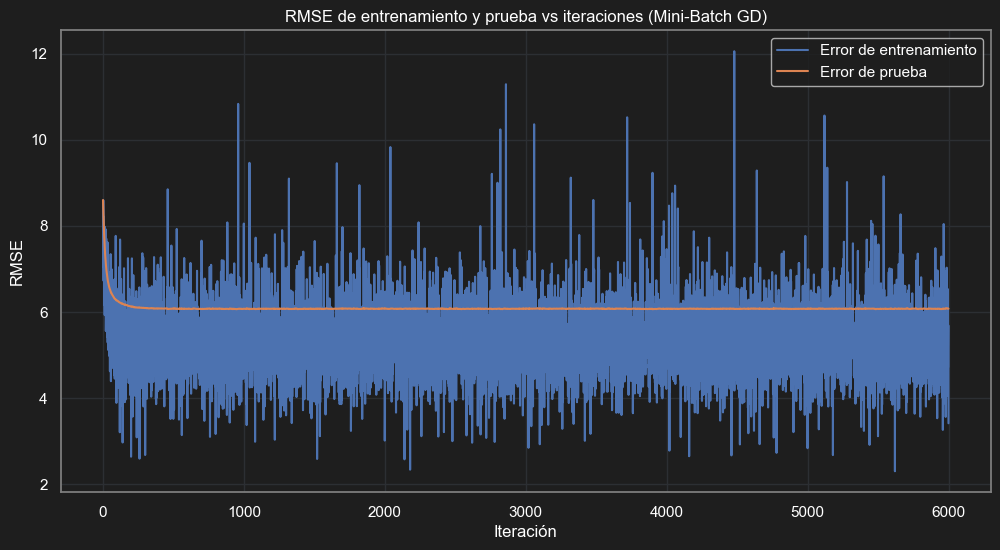

El error rmse_gdb_train es: 5.37996832592269
El error rmse_gdb_test es: 6.075077607651645
El valor de R2_gdb_train: 0.2179654117671147
El valor de R2_gdb_test: 0.19994335574158362


In [80]:
# Se considera un valor de épocas intermedio entre GD y GDE
resultados_gdb=mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=300, lr=0.01, batch_size=1000)

rmse_gdb_train=resultados_gdb['train_rmse']
rmse_gdb_test=resultados_gdb['test_rmse']
R2_gdb_train=resultados_gdb['train_r2']
R2_gdb_test=resultados_gdb['test_r2']

print(f"El error rmse_gdb_train es: {rmse_gdb_train}")
print(f"El error rmse_gdb_test es: {rmse_gdb_test}")
print(f"El valor de R2_gdb_train: {R2_gdb_train}")
print(f"El valor de R2_gdb_test: {R2_gdb_test}")

#### Ridge Regression

In [81]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha.
# Previamente se estandarizan los datos.
modelo = make_pipeline(StandardScaler(), 
                        RidgeCV(
                           alphas          = np.logspace(-10, 10, 200),
                           fit_intercept   = True,
                           store_cv_values = True
                        )
         )
_ = modelo.fit(X_train, y_train)

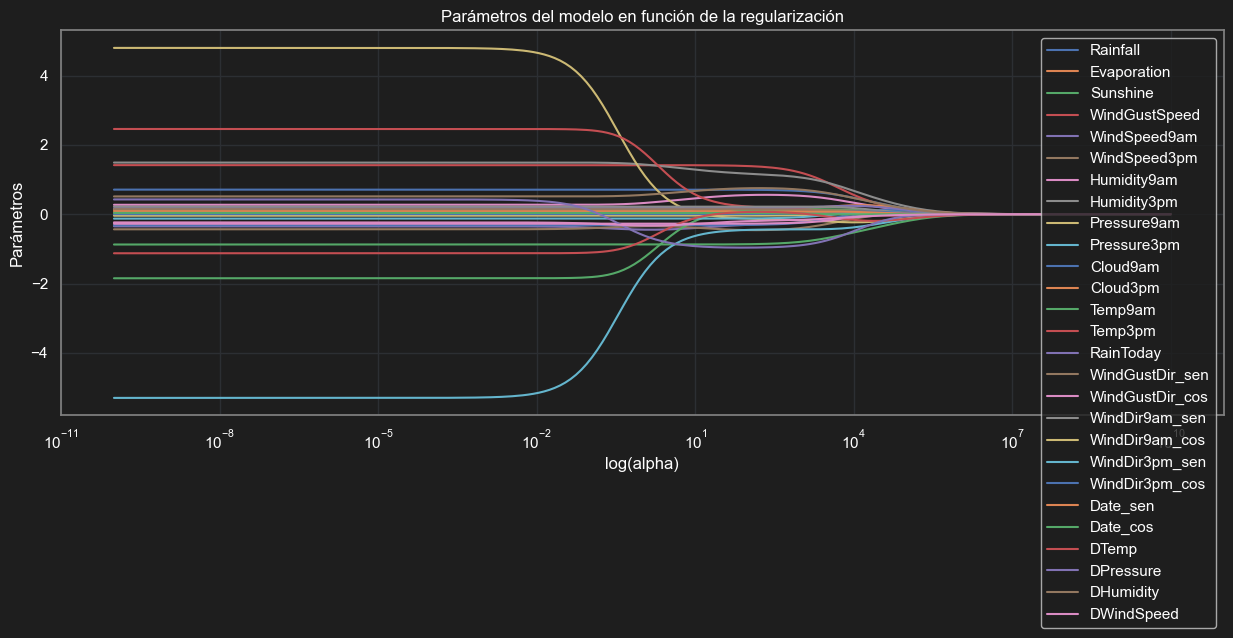

In [82]:
# Evolución de los parámetros en función de alpha
alphas = modelo.steps[1][1].alphas
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

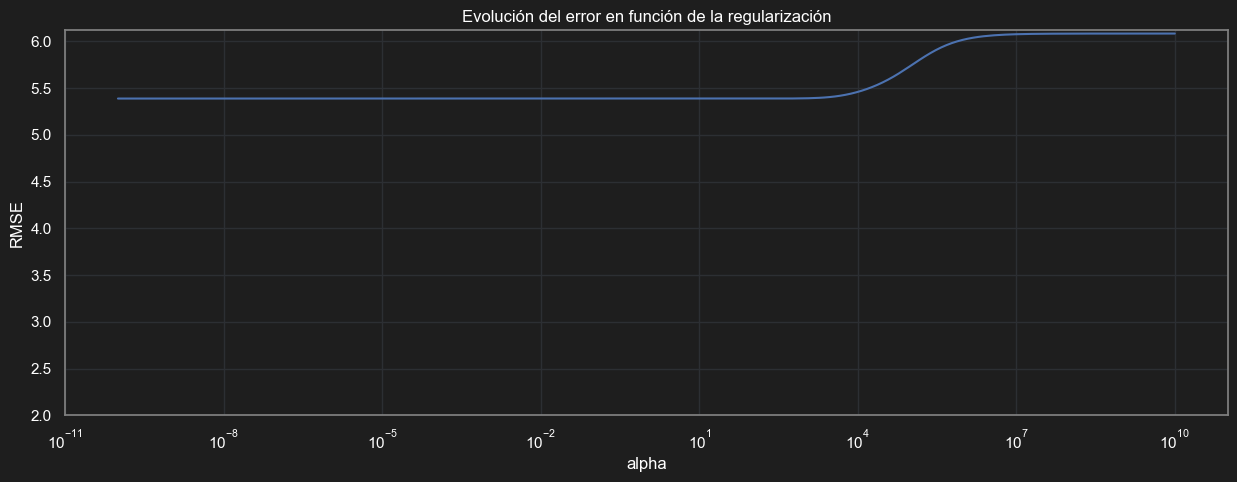

In [83]:
# Evolución del error de validación cruzada en función de alpha
mod = modelo.steps[1][1]
mse_cv = mod.cv_values_.reshape((-1, 200)).mean(axis=0)
# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = mod.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [84]:
# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 114.89510001873109


predictor      coef
0          Rainfall  0.703831
1       Evaporation  0.126203
2          Sunshine -0.864539
3     WindGustSpeed  1.384823
4      WindSpeed9am -0.303299
5      WindSpeed3pm -0.460022
6       Humidity9am  0.554675
7       Humidity3pm  1.163596
8       Pressure9am -0.130972
9       Pressure3pm -0.450329
10         Cloud9am -0.307674
11         Cloud3pm  0.128786
12          Temp9am  0.113031
13          Temp3pm  0.211949
14        RainToday  0.175655
15  WindGustDir_sen  0.143236
16  WindGustDir_cos -0.271777
17   WindDir9am_sen  0.218462
18   WindDir9am_cos -0.042451
19   WindDir3pm_sen -0.122872
20   WindDir3pm_cos  0.004710
21         Date_sen  0.064855
22         Date_cos  0.033895
23            DTemp  0.065667
24        DPressure -0.964292
25        DHumidity  0.750325
26       DWindSpeed -0.197843

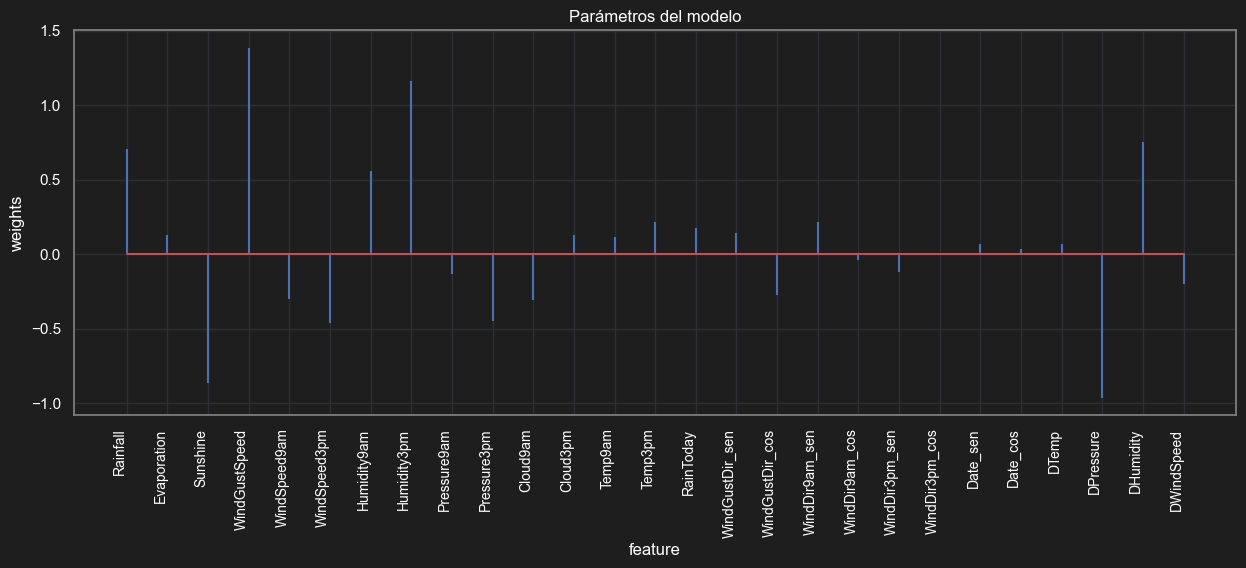

In [85]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame({'predictor': X_train.columns,'coef': mod.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

df_coeficientes[df_coeficientes.coef != 0]

In [86]:
# Se guardan las predicciones del modelo
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Se calcula el error de train del modelo con rmse para mantener la misma escala que la variable a predecir
rmse_ridge_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_ridge_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"El error rmse_ridge_train es: {rmse_ridge_train}")
print(f"El error rmse_ridge_test es: {rmse_ridge_test}")

R2_ridge_train = metrics.r2_score(y_train, y_pred_train)
print(f"El valor de R2_ridge_train: {R2_ridge_train}")
R2_ridge_test = metrics.r2_score(y_test, y_pred_test)
print(f"El valor de R2_ridge_test: {R2_ridge_test}")

El error rmse_ridge_train es: 5.379308724100758
El error rmse_ridge_test es: 6.071117982786203
El valor de R2_ridge_train: 0.21815716004020802
El valor de R2_ridge_test: 0.20098594054107843


#### Lasso Regression

In [87]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha.
# Previamente se estandarizan los datos.
modelo = make_pipeline(StandardScaler(), 
                        LassoCV(
                           alphas=np.logspace(-10, 10, 200),
                           cv=10
                        )
         )

_ = modelo.fit(X_train, y_train)

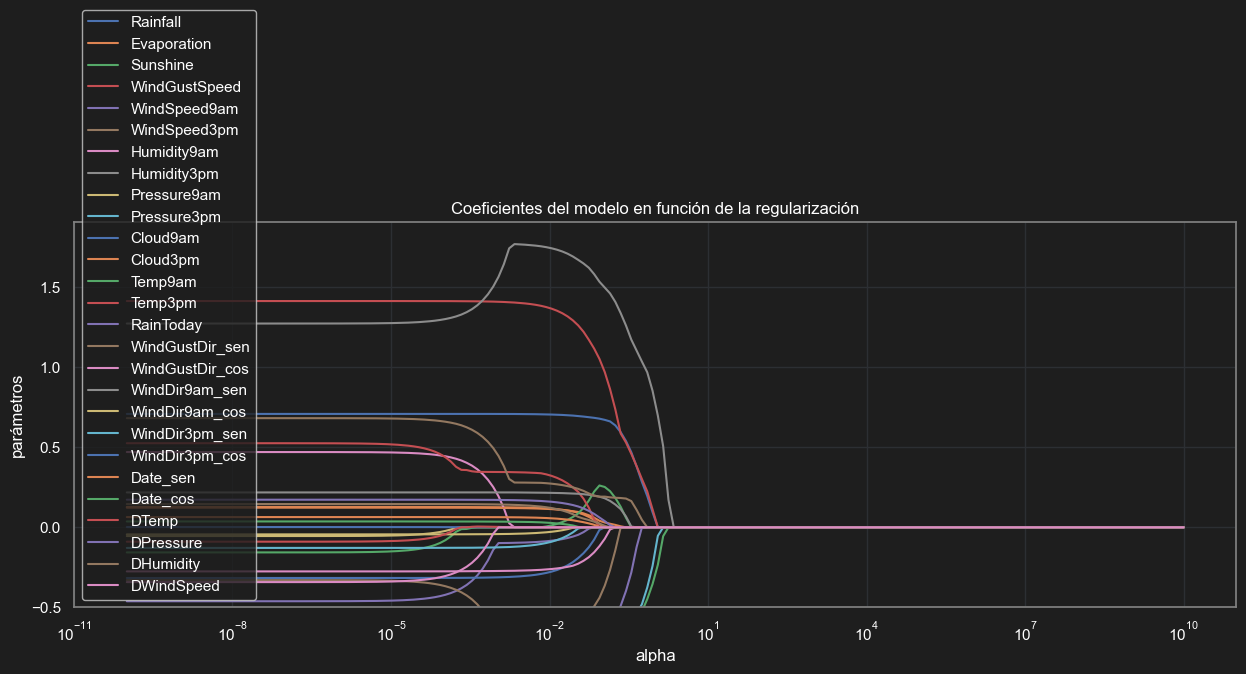

In [88]:
# Evolución de los parámetros en función de alpha
mod = modelo.steps[1][1]
alphas = mod.alphas_

# Usar joblib para paralelizar el ajuste de modelos y reducir los tiempos de ejecución
# Definir una función para ajustar un modelo Lasso con un valor específico de alpha
def fit_lasso(alpha, X_train, y_train):
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    return modelo_aux.steps[1][1].coef_.flatten()
coefs = Parallel(n_jobs=-1)(delayed(fit_lasso)(alpha, X_train, y_train) for alpha in alphas)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

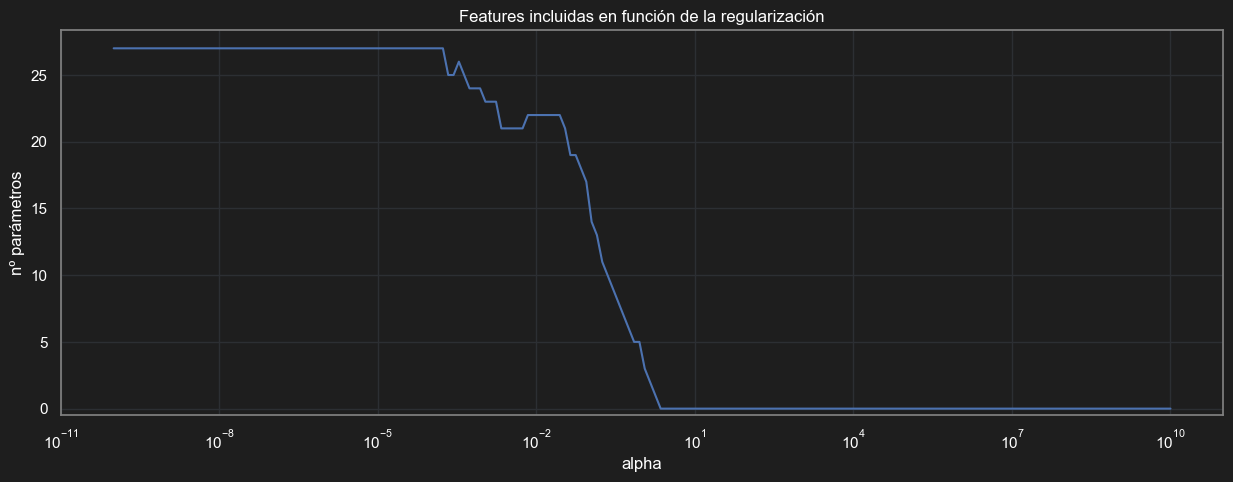

In [89]:
# Definir la función para contar coeficientes no nulos
def count_non_zero_coefs(alpha, X_train, y_train):
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_aux.steps[1][1].coef_.flatten() != 0)
    return coef_no_cero

# Número de features incluidas (parámetros !=0) en función de alpha
alphas = mod.alphas_

# Paralelizar el cálculo
n_predictores = Parallel(n_jobs=-1)(delayed(count_non_zero_coefs)(alpha, X_train, y_train) for alpha in alphas)

# Graficar los resultados
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5, None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')
plt.show()

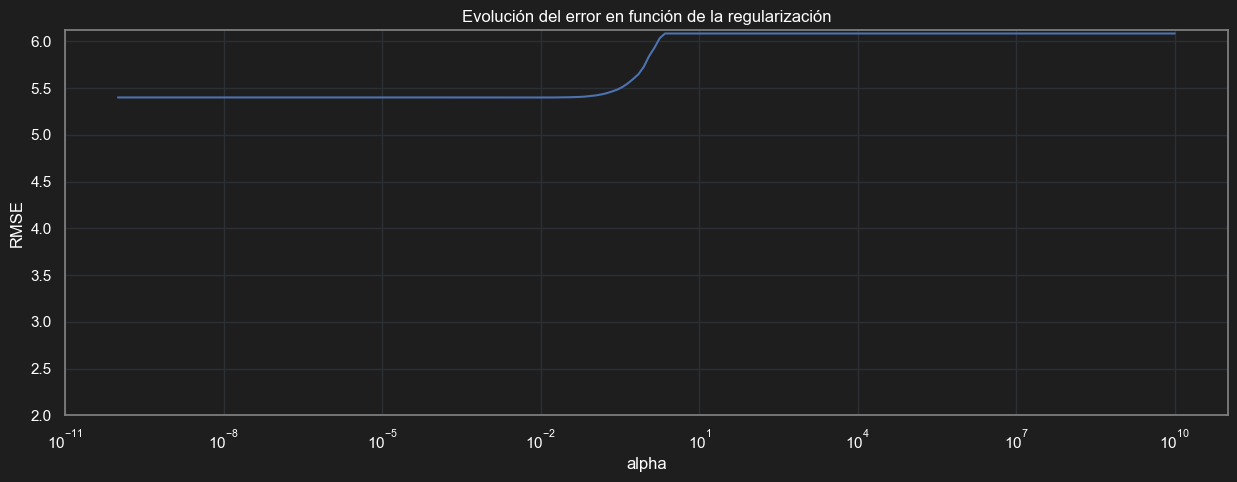

In [90]:
# Evolución del error de validación cruzada en función de alpha
# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mod.mse_path_.mean(axis=1))
# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = mod.alphas_[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas_, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [91]:
# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 0.010969857978923863


predictor      coef
0          Rainfall  0.704821
1       Evaporation  0.116042
2          Sunshine -0.853796
3     WindGustSpeed  1.366520
4      WindSpeed9am -0.083788
5      WindSpeed3pm -0.644303
7       Humidity3pm  1.744014
9       Pressure3pm -0.578606
10         Cloud9am -0.276947
11         Cloud3pm  0.113622
12          Temp9am  0.012161
13          Temp3pm  0.321425
14        RainToday  0.159619
15  WindGustDir_sen  0.120213
16  WindGustDir_cos -0.260684
17   WindDir9am_sen  0.215382
18   WindDir9am_cos -0.027788
19   WindDir3pm_sen -0.089986
21         Date_sen  0.056329
22         Date_cos  0.027151
24        DPressure -0.908557
25        DHumidity  0.272656

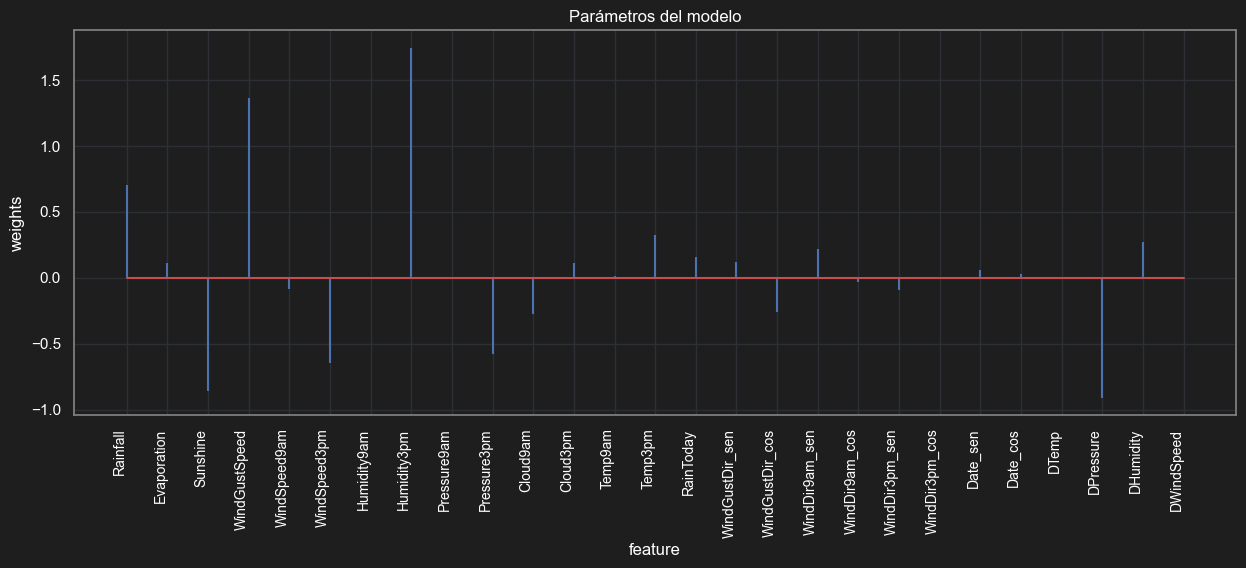

In [92]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame({'predictor': X_train.columns,'coef': mod.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

df_coeficientes[df_coeficientes.coef != 0]

In [93]:
# Se guardan las predicciones del modelo
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Se calcula el error de train del modelo con rmse para mantener la misma escala que la variable a predecir
rmse_lasso_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_lasso_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"El error rmse_lasso_train es: {rmse_lasso_train}")
print(f"El error rmse_lasso_test es: {rmse_lasso_test}")

R2_lasso_train = metrics.r2_score(y_train, y_pred_train)
print(f"El valor de R2_lasso_train: {R2_lasso_train}")
R2_lasso_test = metrics.r2_score(y_test, y_pred_test)
print(f"El valor de R2_lasso_test: {R2_lasso_test}")

El error rmse_lasso_train es: 5.379308724100758
El error rmse_lasso_test es: 6.071117982786203
El valor de R2_lasso_train: 0.21815716004020802
El valor de R2_lasso_test: 0.20098594054107843


#### ElasticNet

Nota: l1_ratio es un parámetro en el modelo de regresión ElasticNet que controla la proporción entre la penalización L1 (norma Lasso) y la penalización L2 (norma Ridge). Cuando l1_ratio es 0, ElasticNet se comporta como una regresión Ridge, y cuando l1_ratio es 1, se comporta como una regresión Lasso.

In [94]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha.
# Previamente se estandarizan los datos.
modelo = make_pipeline(StandardScaler(), 
                        ElasticNetCV(
                              l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas          = np.logspace(-10, 10, 200),
                              cv              = 10
                           )
         )

_ = modelo.fit(X_train, y_train)

mod = modelo.steps[1][1]

In [95]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv

mse_cv   rmse_cv
l1_ratio mod.alphas_                      
0.00     1.000000e+10  37.027459  6.085019
         7.934097e+09  37.027459  6.085019
         6.294989e+09  37.027459  6.085019
         4.994505e+09  37.027459  6.085019
         3.962689e+09  37.027459  6.085019
...                          ...       ...
0.99     2.523539e-10  29.170031  5.400929
         2.002200e-10  29.170031  5.400929
         1.588565e-10  29.170032  5.400929
         1.260383e-10  29.170032  5.400929
         1.000000e-10  29.170032  5.400929

[1400 rows x 2 columns]

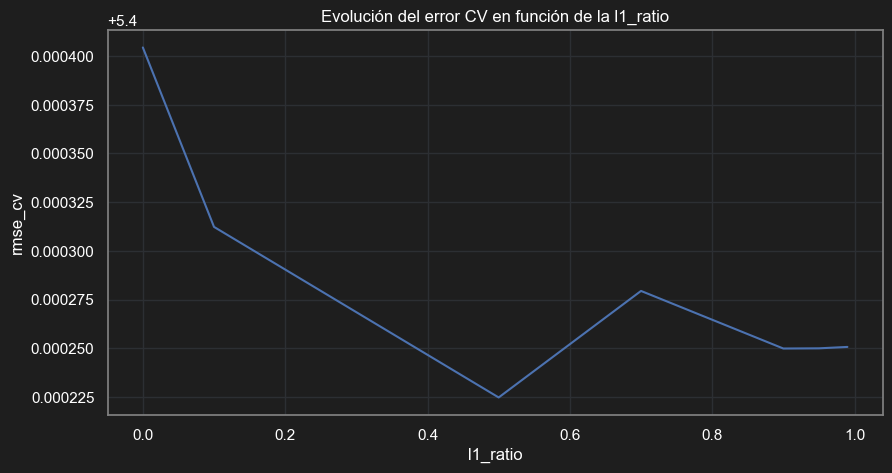

In [96]:
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [97]:
# Mejor valor alpha y l1_ratio_ encontrado
print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

Mejor valor de alpha encontrado: 0.013826221737646593
Mejor valor de l1_ratio encontrado: 0.5


predictor      coef
0          Rainfall  0.701484
1       Evaporation  0.117637
2          Sunshine -0.850381
3     WindGustSpeed  1.351303
4      WindSpeed9am -0.087761
5      WindSpeed3pm -0.635637
6       Humidity9am  0.314097
7       Humidity3pm  1.386908
9       Pressure3pm -0.580836
10         Cloud9am -0.281052
11         Cloud3pm  0.124270
12          Temp9am  0.034924
13          Temp3pm  0.290315
14        RainToday  0.168899
15  WindGustDir_sen  0.127492
16  WindGustDir_cos -0.259250
17   WindDir9am_sen  0.217397
18   WindDir9am_cos -0.030432
19   WindDir3pm_sen -0.097886
21         Date_sen  0.061954
22         Date_cos  0.029697
24        DPressure -0.909807
25        DHumidity  0.540570

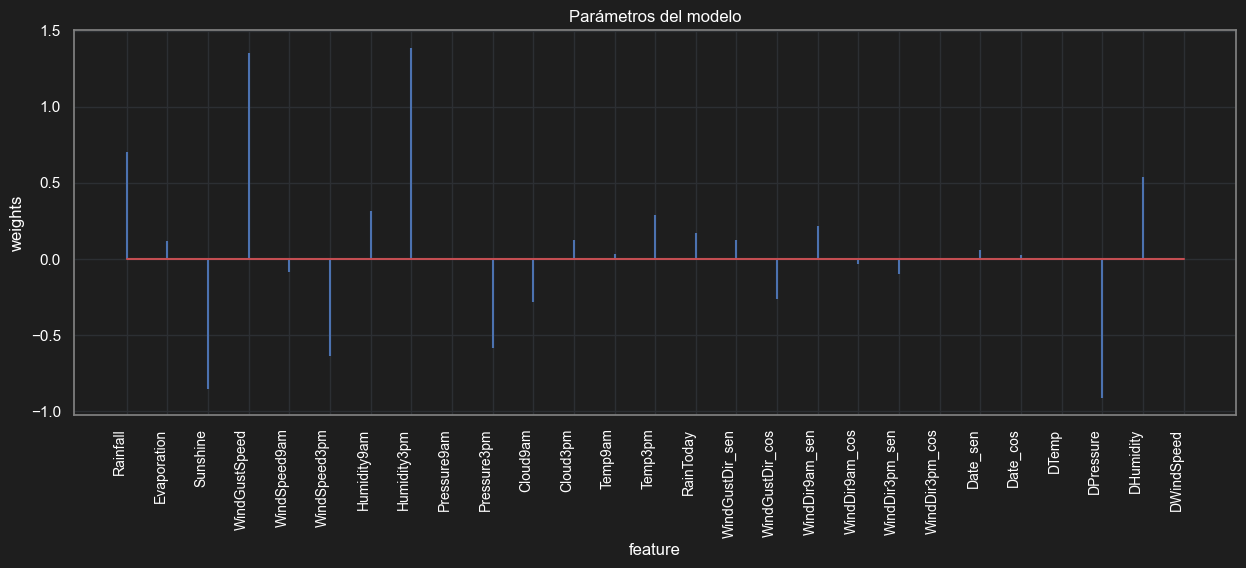

In [98]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame({'predictor': X_train.columns,'coef': mod.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

df_coeficientes[df_coeficientes.coef != 0]

In [99]:
# Se guardan las predicciones del modelo
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Se calcula el error de train del modelo con rmse para mantener la misma escala que la variable a predecir
rmse_elastic_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_elastic_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"El error rmse_elastic_train es: {rmse_elastic_train}")
print(f"El error rmse_elastic_test es: {rmse_elastic_test}")

R2_elastic_train = metrics.r2_score(y_train, y_pred_train)
print(f"El valor de R2_elastic_train: {R2_elastic_train}")
R2_elastic_test = metrics.r2_score(y_test, y_pred_test)
print(f"El valor de R2_elastic_test: {R2_elastic_test}")

El error rmse_elastic_train es: 5.379308724100758
El error rmse_elastic_test es: 6.071117982786203
El valor de R2_elastic_train: 0.21815716004020802
El valor de R2_elastic_test: 0.20098594054107843


#### Resumen de datos de modelos

Se confeccciona una tabla comparativa con los distintos modelos aplicados.

In [245]:
# Crear el DataFrame con los modelos y sus métricas
df_comparacion_probreg = pd.DataFrame({
    'modelo': ['OLS', 'GD', 'GDE', 'GBD', 'Ridge', 'Lasso', 'Elastic-net'],
    'train rmse': [rmse_ols_train, rmse_gd_train, rmse_gde_train, rmse_gdb_train, rmse_ridge_train, rmse_lasso_train, rmse_elastic_train],
    'test rmse': [rmse_ols_test, rmse_gd_test, rmse_gde_test, rmse_gdb_test, rmse_ridge_test, rmse_lasso_test, rmse_elastic_test],
    'train R2': [R2_ols_train, R2_gd_train, R2_gde_train, R2_gdb_train, R2_ridge_train, R2_lasso_train, R2_elastic_train],
    'test R2': [R2_ols_test, R2_gd_test, R2_gde_test, R2_gdb_test, R2_ridge_test, R2_lasso_test, R2_elastic_test]
})

# Mostrar el DataFrame
df_comparacion_probreg

modelo  train rmse  test rmse  train R2   test R2
0          OLS    5.379309   6.071118  0.218157  0.200986
1           GD    5.381305   6.070565  0.217577  0.201131
2          GDE    5.575576   6.353017  0.160064  0.125062
3          GBD    5.379968   6.075078  0.217965  0.199943
4        Ridge    5.379309   6.071118  0.218157  0.200986
5        Lasso    5.379309   6.071118  0.218157  0.200986
6  Elastic-net    5.379309   6.071118  0.218157  0.200986

Conclusiones de los resultados obtenidos:

1. **OLS (Mínimos Cuadrados Ordinarios)**, **Ridge**, **Lasso** y **Elastic-net**: Tienen los mismos valores de RMSE tanto en el conjunto de entrenamiento como en el de prueba. Se entiende entonces que los valores alpha para las regularizaciones no tienen impacto en los modelos de Ridge, Lasso y Elastic-net, lo que se traduce en un comportamiento igual al del modelo de OLS.

2. **GD (Descenso de Gradiente)**: Tiene un valor de RMSE de entrenamiento ligeramente más alto pero un valor de RMSE de testeo ligeramente más bajo en comparación con OLS, lo que sugiere que los datos están menos sobreajustados, consiguiendo un mejor fitting de los datos.

3. **GDE (Descenso de Gradiente Estocástico)**: Tiene el valor más alto de RMSE tanto en el conjunto de entrenamiento como en el de prueba. Esto puede indicar que este modelo está sufriendo de un subajuste (underfitting), lo que significa que no está capturando bien la estructura de los datos y necesita ser mejorado.

4. **GBD (Descenso de Gradiente por Batch)**: Tienen valores de RMSE de entrenamiento ligeramente más altos en comparación con OLS y sus variantes. Esto puede indicar que estos modelos están ligeramente menos sobreajustados que OLS, Ridge, Lasso y Elastic-net, lo que sugiere una mejor capacidad de generalización, pero no tan buena como GD.

En resumen se concluye que el mejor método aplicado fue GD, aunque en sí el modelo no permite explicar correctamente la variabilidad de los datos, si consideramos que el valor de R2 es para todos los casos del 20% aproximadamente.

### 5.Modelos de regresión logística

Se crean los conjuntos de datos para entrenamiento y testeo:
* X_train
* y_train 
* X_test
* y_test

Como se vio anteriormente existe un desbalance entre las clases RainTomorrow=True (llueve) y RainTomorrow=False (no llueve), siendo los valores los siguientes:

In [101]:
conteo_categorias = df_train['RainTomorrow'].value_counts()
rtrain=conteo_categorias[0] /conteo_categorias[1]

print("Proporción de 'RainTomorrow' igual a 0(No llueve):", conteo_categorias[0] / len(df_train))
print("Proporción de 'RainTomorrow' igual a 1(Sí llueve):", conteo_categorias[1] / len(df_train))
print("Relación entre clases rtrain:", rtrain)

Proporción de 'RainTomorrow' igual a 0(No llueve): 0.7650904906370959
Proporción de 'RainTomorrow' igual a 1(Sí llueve): 0.23490950936290406
Relación entre clases rtrain: 3.256958361166778


Se observa que para el conjunto de test el valor rtest es similiar a rtrain, lo cual es un buen indicador de que el desbalance de las clases se mantiene en la misma proporción.
Si bien no se deberían ver los valores del conjunto de test, es una buena práctica hacer este chequeo para no incurrir en errores de predicción.

In [102]:
conteo_categorias = df_test['RainTomorrow'].value_counts()
rtest=conteo_categorias[0] /conteo_categorias[1]

print("Proporción de 'RainTomorrow' igual a 0(No llueve):", conteo_categorias[0] / len(df_test))
print("Proporción de 'RainTomorrow' igual a 1(Sí llueve):", conteo_categorias[1] / len(df_test))
print("Relación entre clases rtest:", rtest)

Proporción de 'RainTomorrow' igual a 0(No llueve): 0.7667832167832168
Proporción de 'RainTomorrow' igual a 1(Sí llueve): 0.2332167832167832
Relación entre clases rtest: 3.287856071964018


Se entrena un modelo de regresión logística con los datos de entrenamiento y se obtienen las métricas precision, TPR, FPR y f1. Además se imprime la matriz de confusión.
La métrica accuracy no es analizada ya que no presenta buenos resultados ante conjuntos de datos con clases desbalanceadas.

Convenciones:
* Caso positivo significa que llueve
* Orden de los valores en la matriz de confusión: [[VN , FN] , [FP , VP]]

Definiciones:
* Recall = TPR = VP / (VP + FN)
* Precision = VP (VP + FP)
* f1 = 2*((recall*precision) / (recall+precision))
* Specificity = VN / (VN + FP)
* FPR = 1- specificity


Se entrena el modelo de regresión logística, previa estandarización de los datos.
Luego se imprimen las métricas de interés y la matriz de confusión para su análisis.

In [103]:
df_test.shape

(2860, 31)

precision: 0.7048192771084337
TPR: 0.5262368815592204
f1: 0.6025751072961374
specificity 0.93296853625171


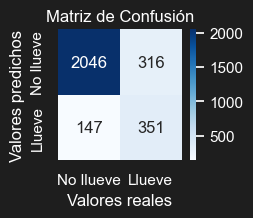

In [104]:
X_train, y_train, X_test, y_test = split(df_train, df_test,'clasificacion')
# Define el modelo de regresión logística
logreg = make_pipeline(StandardScaler(), LogisticRegression(random_state=17))
# Entrenamiento del modelo
logreg.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = logreg.predict(X_test)

precision_dbl, tpr_dbl, f1_dbl, specificity_dbl = logreg_metrics(y_test,y_pred)
matriz_conf (y_test,y_pred)

Primeros análisis:
* Se observa un valor aceptable de precision pero bajo para TPR, es decir FN > FP.
* En nuestro caso es deseable mejorar el valor de TPR para que, del total de días de lluvia, el modelo acierte el mayor número de veces.

Probamos mejorar el entrenamiento del modelo agregando el parámetro 'balanced' a la función LogisticRegression, en busca de ponderar la clase minoritaria (RainTomorrow=True) asignando un peso a la misma, igual a rtrain.

precision: 0.5352260778128286
TPR: 0.7631184407796102
f1: 0.6291718170580964
specificity 0.7984496124031008


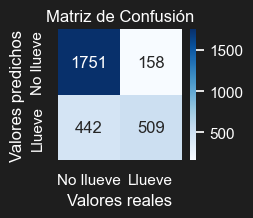

In [105]:
X_train, y_train, X_test, y_test = split(df_train,df_test,'clasificacion')
# Define el modelo de regresión logística con ponderación de clases
logreg_blc = make_pipeline(StandardScaler(), LogisticRegression(random_state=17, class_weight='balanced'))
# Entrenamiento del modelo
logreg_blc.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = logreg_blc.predict(X_test)

precision_blc, tpr_blc, f1_blc, specificity_blc = logreg_metrics(y_test,y_pred)
matriz_conf (y_test,y_pred)

Observaciones:
* Mejora notablemente el valor de TPR, al aumentar VP y disminuir FN.
* Empeora la especificidad al aumentar FP y disminuir VN.
* Empeora la precisión al aumentar FP en mayor proporción que VP.

El modelo acierta en mayor medida cuántos días va a llover, sobre el total de días de lluvia.
Sin embargo, el modelo es menos preciso para predecir, ya que casi la mitad de las veces no acierta.

Se prueba otro modelo utilizando para el entrenamiento un conjunto oversampleado, lo que quiere decir que se incrementa el número de registros de la clase minoritaria para balancear el conjunto de datos de entrenamiento.

precision: 0.5375782881002088
TPR: 0.7721139430284858
f1: 0.6338461538461538
specificity 0.7979936160510716


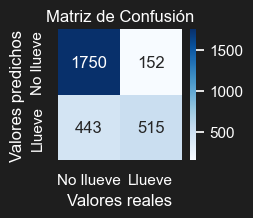

In [106]:
X_train, y_train, X_test, y_test = split(df_train,df_test,'clasificacion')
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Define el modelo de regresión logística
logreg_ovs = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2'))
# Entrenamiento del modelo
logreg_ovs.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = logreg_ovs.predict(X_test)

precision_ovs, tpr_ovs, f1_ovs, specificity_ovs = logreg_metrics(y_test,y_pred)
matriz_conf (y_test,y_pred)

Observaciones:
* Mejora ligeramente el valor de TPR, al aumentar VP y disminuir FN.
* Variación mínima de la especificidad.
* Mejora ligeramente la precisión.

Aunque mejores, las métricas prácticamente no varían en comparación con el modelo anterior que utiliza la ponderación de clases.

Conclusiones: se elige el modelo de regresión logística logreg_ovs con oversampling para la clase minoritaria para continuar con el análisis de optimización de umbral.

#### Optimización del umbral:

Hasta aquí el entrenamiento de los modelos fue con un valor de umbral por defecto de 0.5.

Se grafican las curvas ROC superpuestas para los tres modelos desarrollados en el punto anterior.

Se observa que las diferencias entre ellas son mínimas, y que los valores de auc no varían.


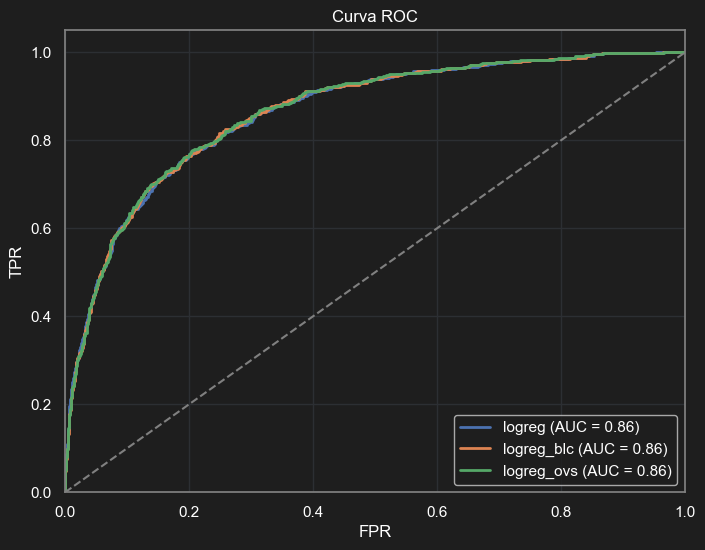

<module 'matplotlib.pyplot' from 'c:\\Users\\julia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [107]:
models = [logreg, logreg_blc, logreg_ovs]
labels = ['logreg', 'logreg_blc', 'logreg_ovs']

ROC(models, X_test, y_test, labels)

Para el modelo logreg_ovs, elegido en el punto anterior, se utiliza la curva ROC para identificar un valor de umbral que permita una combinación de valores para TPR y FPR más adecuada.

Se prueban valores de TPR por encima del ya obtenido, para igualarlo al valor de especificidad, y se obtiene el valor de umbral asociado:

TPR utilizado: 0.7841079460269865
Umbral elegido: 0.48040994851283947
precision: 0.5245737211634904
TPR: 0.7841079460269865
f1: 0.6286057692307693
specificity 0.7838577291381669


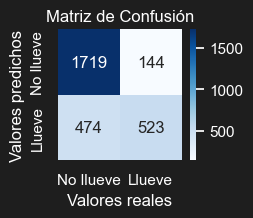

In [108]:
y_pred_proba = logreg_ovs.predict_proba(X_test)[:, 1]
fpr, tpr, umbral = roc_curve(y_test, y_pred_proba)

target_tpr = 0.783
# Buscamos el índice del valor más cercano a target_tpr en el array de TPR
index = np.argmax(tpr >= target_tpr)
umbral_asociado = umbral[index]
fpr_asociado = fpr[index]
tpr_asociado = tpr[index]
print("TPR utilizado:", tpr_asociado)
print("Umbral elegido:", umbral_asociado)

#Se utiliza el umbral calculado para obtener las nuevas predicciones:
y_pred = (y_pred_proba >= umbral_asociado).astype(int)

precision_ovsu, tpr_ovsu, f1_ovsu, specificity_ovsu = logreg_metrics(y_test,y_pred)
matriz_conf (y_test,y_pred)

#### Resumen de datos de modelos

Se confeccciona una tabla comparativa con los distintos modelos aplicados.

In [109]:
# Crear el DataFrame con los modelos y sus métricas
df_comparacion_logreg = pd.DataFrame({
    'modelo': ['logreg', 'logreg_blc', 'logreg_ovs', 'logreg_ovsu'],
    'Umbral': [0.5, 0.5, 0.5,umbral_asociado],
    'Precision': [precision_dbl, precision_blc, precision_ovs, precision_ovsu],
    'TPR': [tpr_dbl, tpr_blc, tpr_ovs,tpr_ovsu],
    'Especificidad': [specificity_dbl, specificity_blc, specificity_ovs,specificity_ovsu],
    'f1': [f1_dbl, f1_blc, f1_ovs,f1_ovsu],
})

# Mostrar el DataFrame
df_comparacion_logreg

modelo   Umbral  Precision       TPR  Especificidad        f1
0       logreg  0.50000   0.704819  0.526237       0.932969  0.602575
1   logreg_blc  0.50000   0.535226  0.763118       0.798450  0.629172
2   logreg_ovs  0.50000   0.537578  0.772114       0.797994  0.633846
3  logreg_ovsu  0.48041   0.524574  0.784108       0.783858  0.628606

#### Conclusiones:
Se obtiene un modelo que acertará en un 78% tanto en los días lluviosos, como en los no lluviosos, a cambio de no ser tan preciso para la clase Lluvia=True, ya que tiene un 52% de tasa de acierto cada vez que prediga que lloverá.

En otras palabras, se prioriza la sensibilidad por sobre la precisión.
Esta elección se fundamenta entendiendo que es más deseable indicar que lloverá aunque no suceda (falsos positivos) en vez de predecir que no lloverá y que sí pase (falsos negativos).

Naturalmente existe un límite para este criterio, ya que si se reducen al mínimo los falsos negativos la mayoría de las predicciones de lluvia serán erradas (aumentan los falsos positivos) y el modelo dejará de ser creíble perdiendo valor.

En definitiva, no hay un criterio único ni un límite establecido en las métricas para el diseño del modelo, sino que se definieron en busca del balance descripto.

El valor de AUC-ROC=0.86 se considera aceptable y sugiere que el modelo tiene una capacidad discriminatoria razonablemente buena, pudiendo clasificar correctamente la mayoría de los ejemplos positivos y negativos.

### 6.Definición de modelos base

#### Modelo base de clasificación

Se define el siguiente modelo para clasificación basándonos en las variables Cloud9am y Cloud3pm.

El criterio de clasificación definido es el siguiente: RainTomorrow será True para todos aquellos días en donde el promedio de estas dos variables supere el umbral de 5.5.

Caso contrario RainTomorrow será False.

Métricas del conjunto de entrenamiento:

precision: 0.39166666666666666
TPR: 0.7011801380538856
f1: 0.5025935679514804
specificity 0.665618376974089


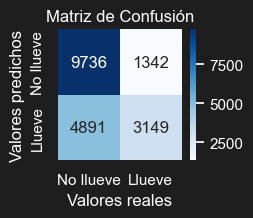

In [110]:
X_train, y_train, X_test, y_test = split(df_train, df_test,'clasificacion')
umbral=5.5
y_train_pred = pd.DataFrame()
cloud_avg=(X_train['Cloud9am'] + X_train['Cloud3pm']) / 2
y_train_pred['RainTomorrow_pred'] = cloud_avg > umbral
logreg_metrics(y_train,y_train_pred)
matriz_conf(y_train,y_train_pred)

Métricas del conjunto de test:

precision: 0.3972153972153972
TPR: 0.7271364317841079
f1: 0.513771186440678
specificity 0.6643866849065208


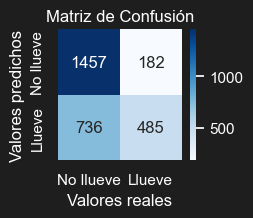

In [111]:
y_test_pred = pd.DataFrame()
cloud_avg=(X_test['Cloud9am'] + X_test['Cloud3pm']) / 2
y_test_pred['RainTomorrow_pred'] = cloud_avg > umbral
precision_base, tpr_base, f1_base, specificity_base = logreg_metrics(y_test,y_test_pred)
matriz_conf(y_test,y_test_pred)

Conclusiones:

Se obtiene un modelo base que, como es de esperar, tiene peores métricas que los modelos anteriores.
En la siguiente tabla se compara las métricas del modelo desbalanceado, del oversampleado con el umbral modificado y del base.
No obstante lo anterior, se considera que por la simplicidad del modelo se obtienen valores satisfactorios tanto de tpr como de especificidad, claro está, a costa de una pérdida de precisión en las predicciones en ambas clases.

In [112]:
df_comparacion_logreg.loc[len(df_comparacion_logreg)] = ['logreg_base', 0.5, precision_base,tpr_base,specificity_base,f1_base]
df_comparacion_logreg

modelo   Umbral  Precision       TPR  Especificidad        f1
0       logreg  0.50000   0.704819  0.526237       0.932969  0.602575
1   logreg_blc  0.50000   0.535226  0.763118       0.798450  0.629172
2   logreg_ovs  0.50000   0.537578  0.772114       0.797994  0.633846
3  logreg_ovsu  0.48041   0.524574  0.784108       0.783858  0.628606
4  logreg_base  0.50000   0.397215  0.727136       0.664387  0.513771

#### Modelo base para regresión

El modelo planteado determina que, RainfallTomorrow será 0 si RainTomorrow es igual a False, según el modelo de clasificación anterior. 

En caso de que RainTomorrow sea True, se tomará el valor de la moda de Rainfall. Se aclara que se descartan para la obtención de la moda los días para los que Rainfall sea 0.

Métricas del conjunto de train:

In [113]:
X_train, y_train, X_test, y_test = split(df_train, df_test,'regresion')
umbral=5.5
# Calcular el promedio de Cloud3pm y Cloud9am
cloud_avg=(X_train['Cloud9am'] + X_train['Cloud3pm']) / 2
# Filtrar las filas donde Rain es True
raintoday_true = df_train[df_train['RainToday']]
# Calcular la moda de Rainfall
rainfall_mode = raintoday_true['Rainfall'].mode()[0]

# Crear y_train_pred
y_train_pred = pd.DataFrame(index=X_train.index)
y_train_pred['Rainfall'] = 0  # Inicialmente, establecemos todos los valores como 0
# Si el promedio de Cloud3pm y Cloud9am es mayor o igual que al umbral, usar la moda de Rainfall
y_train_pred.loc[cloud_avg >= umbral, 'Rainfall'] = rainfall_mode
# Calcular el error
rmse_base_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_base_train

R2_base_train = metrics.r2_score(y_train, y_pred_train)

Métricas del conjunto de test:

In [114]:
umbral=5.5
# Filtrar las filas donde RainToday es True
rain_tomorrow_true = df_test[df_test['RainToday']]
# Calcular la moda de Rainfall
rainfall_tomorrow_mode = rain_tomorrow_true['Rainfall'].mode()[0]
# Calcular el promedio de Cloud3pm y Cloud9am
cloud_avg=(X_test['Cloud9am'] + X_test['Cloud3pm']) / 2
# Crear y_test_pred
y_test_pred = pd.DataFrame(index=X_test.index)
y_test_pred['Rainfall'] = 0  # Inicialmente, establecemos todos los valores como 0
# Si el promedio de Cloud3pm y Cloud9am es mayor o igual que 5, usar la moda de Rainfall
y_test_pred.loc[cloud_avg >= umbral, 'Rainfall'] = rainfall_tomorrow_mode
# Calcular el error
rmse_base_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_base_test

R2_base_test = metrics.r2_score(y_test, y_pred_test)

Conclusiones:

Similar al caso de clasificación, se obtiene un modelo base para el problema de regresión que tiene peores métricas que los modelos planteados anteriormente.
Igualmente, es de destacar que pese a la simplicidad del modelo, su error rmse no difiere demasiado de los de los demás modelos.

In [246]:
df_comparacion_probreg.loc[len(df_comparacion_probreg)] = ['Base', rmse_base_train, rmse_base_test,R2_base_train,R2_base_test]
df_comparacion_probreg

modelo  train rmse  test rmse  train R2   test R2
0          OLS    5.379309   6.071118  0.218157  0.200986
1           GD    5.381305   6.070565  0.217577  0.201131
2          GDE    5.575576   6.353017  0.160064  0.125062
3          GBD    5.379968   6.075078  0.217965  0.199943
4        Ridge    5.379309   6.071118  0.218157  0.200986
5        Lasso    5.379309   6.071118  0.218157  0.200986
6  Elastic-net    5.379309   6.071118  0.218157  0.200986
7         Base    6.144219   6.844988  0.218157  0.200986

### 7.Optimización de hiperparámetros

##### Optimización para modelo de regresión RandomForestRegressor

Para la optimización de hiperparámetros se utilizará un modelo diferente a los antes utilizados.
Esta decisión se basa en la consideración de que ya hubo un proceso de optimización de hiperparámetros (si bien no todos) tanto en los modelos de Gradiente Descendente en sus tres variantes (GD, GDE y GDB), como así también en los modelos de regresión de Ridge, Lasso y ElasticNet.

Se considera entonces entrenar el modelo RandomForestRegressor, para el cual se optimizarán los siguientes hiperparámetros:

* n_estimators: Número de árboles en el bosque. Un mayor número de árboles puede mejorar la precisión, pero también incrementa el tiempo de entrenamiento.
* max_depth: Profundidad máxima de los árboles. Limitar la profundidad puede ayudar a prevenir el sobreajuste.
* min_samples_split: Número mínimo de muestras requeridas para dividir un nodo.
* min_samples_leaf: Número mínimo de muestras que debe tener un nodo hoja.
* max_features: Número de características a considerar al buscar la mejor división.

In [116]:
X_train, y_train, X_test, y_test = split(df_train,df_test,'regresion')

Se definen los valores de los hiperparámetros que se utilizarán, con una breve descripción del por qué de los valores elegidos:

1. **n_estimators**: Un valor más alto generalmente reduce el sobreajuste, pero aumenta el costo computacional. Se han elegido valores relativamente bajos para reducir el tiempo de entrenamiento, pero aún así proporcionar un buen rendimiento.

2. **max_depth**: Un valor más alto permite que los árboles sean más profundos y más complejos, lo que podría llevar al sobreajuste. Se han seleccionado varios valores para explorar diferentes niveles de complejidad del modelo y evitar el sobreajuste.

3. **min_samples_split**: Valores más altos previenen el sobreajuste al requerir que cada división tenga suficientes muestras. Se han elegido valores moderados para permitir una división más flexible pero no demasiado pequeños para evitar el sobreajuste.

4. **min_samples_leaf**: Mismo criterio que para min_samples_split.

5. **max_features**: 'sqrt' y 'log2' son opciones que eligen la raíz cuadrada y el logaritmo base 2 del número total de características, respectivamente. '0.3' indica que el modelo considerará el 30% de las características en cada división. Se han seleccionado estas opciones para proporcionar una exploración exhaustiva de las diferentes combinaciones de características para cada división.

In [117]:
# Parámetros para utilizar en grid search y random search
params = {
    'n_estimators': [40, 50, 70],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [30, 40, 60],
    'min_samples_leaf': [15, 20, 30],
    'max_features': ['sqrt','log2', 0.3]
}

Se analizará grid_search, random_search y optuna, y se contrastarán los resultados.

###### Grid Search:

In [118]:
start_time = time.time()

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), params, cv=5, scoring=make_scorer(r2_score), n_jobs=-1)
grid_search.fit(X_train, y_train)
best_grid_params = grid_search.best_params_
best_grid_model = RandomForestRegressor(**best_grid_params, random_state=42)
best_grid_model.fit(X_train, y_train)
grid_search_rmse_train = np.sqrt(mean_squared_error(y_train, best_grid_model.predict(X_train)))
grid_search_rmse_test = np.sqrt(mean_squared_error(y_test, best_grid_model.predict(X_test)))
y_pred_test = best_grid_model.predict(X_test)

end_time = time.time()
execution_time_grid = end_time - start_time

print("Mejores hiperparámetros:", best_grid_params)
print("Tiempo de ejecución:", execution_time_grid, "segundos")

Mejores hiperparámetros: {'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 15, 'min_samples_split': 30, 'n_estimators': 70}
Tiempo de ejecución: 443.63120198249817 segundos


In [119]:
print("Grid Search RMSE train:", grid_search_rmse_train)
print("Grid Search RMSE test:", grid_search_rmse_test)
y_pred_train = best_grid_model.predict(X_train)
R2_grid_search_train = metrics.r2_score(y_train, y_pred_train)
print(f"El valor de R2_grid_search_train: {R2_grid_search_train}")
R2_grid_search_test = metrics.r2_score(y_test, y_pred_test)
print(f"El valor de R2_grid_search_test: {R2_grid_search_test}")

Grid Search RMSE train: 4.434029032364255
Grid Search RMSE test: 5.8230212766370295
El valor de R2_grid_search_train: 0.46879324521662336
El valor de R2_grid_search_test: 0.2649551661124202


###### Random Search:

In [120]:
start_time = time.time()

# random search
random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), params, n_iter=4, cv=3, scoring=make_scorer(r2_score), n_jobs=-1)
random_search.fit(X_train, y_train)
best_random_params = random_search.best_params_
best_random_model = RandomForestRegressor(**best_random_params, random_state=42)
best_random_model.fit(X_train, y_train)
random_search_rmse_train = np.sqrt(mean_squared_error(y_train, best_random_model.predict(X_train)))
random_search_rmse_test = np.sqrt(mean_squared_error(y_test, best_random_model.predict(X_test)))
y_pred_test = best_random_model.predict(X_test)

end_time = time.time()
execution_time_random = end_time - start_time

best_random_params
print("Mejores hiperparámetros:", best_random_params)
print("Tiempo de ejecución:", execution_time_random, "segundos")

Mejores hiperparámetros: {'n_estimators': 70, 'min_samples_split': 40, 'min_samples_leaf': 20, 'max_features': 0.3, 'max_depth': 15}
Tiempo de ejecución: 21.665097951889038 segundos


In [121]:
print("Random Search RMSE train:", random_search_rmse_train)
print("Random Search RMSE test:", random_search_rmse_test)
y_pred_train = best_random_model.predict(X_train)
R2_random_search_train = metrics.r2_score(y_train, y_pred_train)
print(f"El valor de R2_random_train: {R2_random_search_train}")
R2_random_search_test = metrics.r2_score(y_test, y_pred_test)
print(f"El valor de R2_random_search_test: {R2_random_search_test}")

Random Search RMSE train: 4.590892722222686
Random Search RMSE test: 5.815750381081583
El valor de R2_random_train: 0.4305431609776744
El valor de R2_random_search_test: 0.2667896425147186


###### Optuna:

In [122]:
start_time = time.time()

# Función para entrenar y evaluar un modelo con hiperparámetros dados utilizando validación cruzada
def train_evaluate_model_cv(params, X, y, cv=5):
    model = RandomForestRegressor(**params, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return scores.mean()

# Definición de la función objetivo para Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 40, 70)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 30, 60)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 15, 30)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3])

    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features
    }

    r2 = train_evaluate_model_cv(params, X_train, y_train, cv=5)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
best_optuna_params = study.best_params
best_optuna_model = RandomForestRegressor(**best_optuna_params, random_state=42)
best_optuna_model.fit(X_train, y_train)
optuna_rmse_train = np.sqrt(mean_squared_error(y_train, best_optuna_model.predict(X_train)))
optuna_rmse_test = np.sqrt(mean_squared_error(y_test, best_optuna_model.predict(X_test)))
y_pred_test = best_optuna_model.predict(X_test)

end_time = time.time()
execution_time_optuna = end_time - start_time

print("Mejores hiperparámetros:", best_optuna_params)
print("Tiempo de ejecución:", execution_time_optuna, "segundos")

[I 2024-06-08 14:06:31,495] A new study created in memory with name: no-name-6ce9f7b8-c103-436f-b6b1-cec36604e1c3
[I 2024-06-08 14:06:36,554] Trial 0 finished with value: 0.27496935382396376 and parameters: {'n_estimators': 44, 'max_depth': 9, 'min_samples_split': 52, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 0 with value: 0.27496935382396376.
[I 2024-06-08 14:06:49,625] Trial 1 finished with value: 0.28389078060773515 and parameters: {'n_estimators': 65, 'max_depth': 9, 'min_samples_split': 30, 'min_samples_leaf': 26, 'max_features': 0.3}. Best is trial 1 with value: 0.28389078060773515.
[I 2024-06-08 14:07:07,066] Trial 2 finished with value: 0.2862507702733536 and parameters: {'n_estimators': 63, 'max_depth': 16, 'min_samples_split': 44, 'min_samples_leaf': 26, 'max_features': 0.3}. Best is trial 2 with value: 0.2862507702733536.
[I 2024-06-08 14:07:31,199] Trial 3 finished with value: 0.28790431618180345 and parameters: {'n_estimators': 64, 'max_depth': 19, 'mi

Mejores hiperparámetros: {'n_estimators': 64, 'max_depth': 19, 'min_samples_split': 35, 'min_samples_leaf': 23, 'max_features': 0.3}
Tiempo de ejecución: 177.64812111854553 segundos


In [123]:
print("Optuna RMSE train:", optuna_rmse_train)
print("Optuna RMSE test:", optuna_rmse_test)
y_pred_train = best_optuna_model.predict(X_train)
R2_optuna_train = metrics.r2_score(y_train, y_pred_train)
print(f"El valor de R2_optuna_train: {R2_optuna_train}")
R2_optuna_test = metrics.r2_score(y_test, y_pred_test)
print(f"El valor de R2_optuna_test: {R2_optuna_test}")

Optuna RMSE train: 4.643306898861464
Optuna RMSE test: 5.82583428312424
El valor de R2_optuna_train: 0.41746596745293085
El valor de R2_optuna_test: 0.2642448182635956


Comparación entre los tres métodos de optimización:

In [124]:
# Crear el DataFrame con los modelos y sus RMSE
df_comparacion = pd.DataFrame({
    'modelo': ['Grid', 'Random', 'Optuna'],
    'train rmse': [grid_search_rmse_train, random_search_rmse_train, optuna_rmse_train],
    'test rmse': [grid_search_rmse_test, random_search_rmse_test, optuna_rmse_test],
    'train R2': [R2_grid_search_train,R2_random_search_train,R2_optuna_train],
    'test R2': [R2_grid_search_test,R2_random_search_test,R2_optuna_test],
    'execution time': [execution_time_grid,execution_time_random,execution_time_optuna]
})

# Mostrar el DataFrame
df_comparacion

modelo  train rmse  test rmse  train R2   test R2  execution time
0    Grid    4.434029   5.823021  0.468793  0.264955      443.631202
1  Random    4.590893   5.815750  0.430543  0.266790       21.665098
2  Optuna    4.643307   5.825834  0.417466  0.264245      177.648121

Conclusiones:

Con los tres métodos se obtienen valores de rmse y R2 similares. La mayor diferencia se encuentra en los tiempos de ejecución, siendo marcadamente el método grid_search el más lento de todos. 

En cuanto a los valores de R2, tanto para train como para test el desempeño de los modelos no es bueno, ya que capturan una baja proporción de la variabilidad de los datos. Además la diferencia entre R2 de entrenamiento y R2 de prueba sugiere que los modelos están sobreajustando a los datos de entrenamiento. Esto significa que los modelos están capturando demasiado ruido y detalles específicos del conjunto de entrenamiento, lo que no se generaliza bien a nuevos datos.

Se concluye que si bien se mejoran las métricas, los nuevos modelos planteados no logran explicar correctamente la captura de todas las relaciones importantes en los datos.

En el contexto de este trabajo, se eligen los hiperparámetros obtenidos con grid search, ya que con ellos se consiguen las mejores métricas en un tiempo de ejecución razonable.

**Comparación de todos los modelos para el problema de regresión lineal**

Se elige como modelo para el problema de regresión a RandomForestRegressor con optimización por grid search.

In [247]:
df_comparacion_probreg.loc[len(df_comparacion_probreg)] = ['RFR_Grid', grid_search_rmse_train, grid_search_rmse_test,R2_grid_search_train,R2_grid_search_test]
df_comparacion_probreg.loc[len(df_comparacion_probreg)] = ['RFR_Search', random_search_rmse_train, random_search_rmse_test,R2_random_search_train,R2_random_search_test]
df_comparacion_probreg.loc[len(df_comparacion_probreg)] = ['RFR_Optuna', optuna_rmse_train, optuna_rmse_test,R2_optuna_train,R2_optuna_test]
df_comparacion_probreg

modelo  train rmse  test rmse  train R2   test R2
0           OLS    5.379309   6.071118  0.218157  0.200986
1            GD    5.381305   6.070565  0.217577  0.201131
2           GDE    5.575576   6.353017  0.160064  0.125062
3           GBD    5.379968   6.075078  0.217965  0.199943
4         Ridge    5.379309   6.071118  0.218157  0.200986
5         Lasso    5.379309   6.071118  0.218157  0.200986
6   Elastic-net    5.379309   6.071118  0.218157  0.200986
7          Base    6.144219   6.844988  0.218157  0.200986
8      RFR_Grid    4.434029   5.823021  0.468793  0.264955
9    RFR_Search    4.590893   5.815750  0.430543  0.266790
10   RFR_Optuna    4.643307   5.825834  0.417466  0.264245

##### Optimización para modelo de clasificación: LogisticRegression

Se utiliza el modelo de regresión logística oversampleado para optimizar los siguientes hiperparámetros. Luego se hará el ajuste del umbral según la curva ROC.

1. **C**: Este parámetro controla la fuerza de regularización en el modelo. Un valor más pequeño de C indica una regularización más fuerte, lo que significa que se penaliza más fuertemente los coeficientes grandes en la función de pérdida. Por el contrario, un valor más grande de C indica una regularización más débil, lo que permite a los coeficientes tener valores más grandes.

2. **penalty**: Este hiperparámetro especifica la norma utilizada en la penalización. l2 significa que se aplica la norma L2, que penaliza la suma de los cuadrados de los coeficientes en la función de pérdida. Otra opción común es l1, que aplica la norma L1 y conduce a la selección de características esparsas.

3. **solver**: Este parámetro especifica el algoritmo a utilizar en el problema de optimización. lbfgs, liblinear y newton-cg son diferentes algoritmos de optimización utilizados para encontrar los coeficientes óptimos. lbfgs y newton-cg son métodos quasi-Newton, mientras que liblinear es un solver específico para penalidades l1 y l2.

4. **max_iter**: Este hiperparámetro establece el número máximo de iteraciones que el algoritmo de optimización permite antes de detenerse, incluso si no ha convergido. Si el modelo no converge antes de alcanzar este número máximo de iteraciones, se generará una advertencia indicando que el modelo no ha convergido.

Mejores hiperparámetros: {'logisticregression__C': 1, 'logisticregression__max_iter': 200, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
precision: 0.5375782881002088
TPR: 0.7721139430284858
f1: 0.6338461538461538
specificity 0.7979936160510716


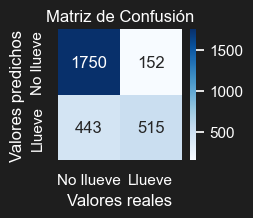

In [126]:
X_train, y_train, X_test, y_test = split(df_train, df_test, 'clasificacion')

# Aplicar sobremuestreo
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Definir la canalización y los hiperparámetros a optimizar
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

param_grid = {
    'logisticregression__C': [0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs', 'liblinear','newton-cg'],
    'logisticregression__max_iter': [200, 300]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
precision_ohp, tpr_ohp, f1_ohp, specificity_ohp = logreg_metrics(y_test, y_pred)
matriz_conf(y_test, y_pred)

Se prueban valores de umbrales para mejorar, sobre el modelo anterior, las métricas TPR y especificidad, sin éxito.

TPR utilizado: 0.7901049475262368
Umbral elegido: 0.47006413465902963
precision: 0.5131450827653359
TPR: 0.7901049475262368
f1: 0.6221959858323495
specificity 0.7720018239854081


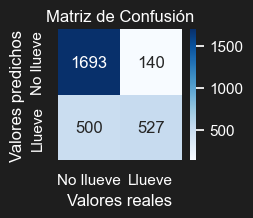

In [127]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, umbral = roc_curve(y_test, y_pred_proba)

target_tpr = 0.79
# Buscamos el índice del valor más cercano a target_tpr en el array de TPR
index = np.argmax(tpr >= target_tpr)
umbral_asociado = umbral[index]
fpr_asociado = fpr[index]
tpr_asociado = tpr[index]
print("TPR utilizado:", tpr_asociado)
print("Umbral elegido:", umbral_asociado)

#Se utiliza el umbral calculado para obtener las nuevas predicciones:
y_pred = (y_pred_proba >= umbral_asociado).astype(int)

precision_ohp, tpr_ohp, f1_ohp, specificity_ohp = logreg_metrics(y_test,y_pred)
matriz_conf (y_test,y_pred)

Conclusiones:

La optimización de hiperparámetros no permitió obtener un modelo con mejores métricas a las ya obtenidas, esto es, mayores valores tando de TPR como de la especificidad.

In [128]:
df_comparacion_logreg.loc[len(df_comparacion_logreg)] = ['logreg_grid',umbral_asociado, precision_ohp,tpr_ohp,specificity_ohp,f1_ohp]
df_comparacion_logreg

modelo    Umbral  Precision       TPR  Especificidad        f1
0       logreg  0.500000   0.704819  0.526237       0.932969  0.602575
1   logreg_blc  0.500000   0.535226  0.763118       0.798450  0.629172
2   logreg_ovs  0.500000   0.537578  0.772114       0.797994  0.633846
3  logreg_ovsu  0.480410   0.524574  0.784108       0.783858  0.628606
4  logreg_base  0.500000   0.397215  0.727136       0.664387  0.513771
5  logreg_grid  0.470064   0.513145  0.790105       0.772002  0.622196

### 8.Explicabilidad del modelo

Se utiliza SHAP para explicar las variables de los modelos para regresión y clasificación.

Modelo elegido para el problema de regresión:
* RandomForestRegressor con grid search

Modelo elegido para el problema de clasificación:
* Regresión logística con oversampleo de muestras, y ajuste de umbral.

#### Explicabilidad para regresión:

In [129]:
#Para el problema de regresión
X_train, y_train, X_test, y_test = split(df_train,df_test,'regresion')
y_pred = best_grid_model.predict(X_test)

feature_names=X_train.columns.values
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
# Crea un objeto explainer SHAP
explainer = shap.TreeExplainer(best_grid_model, data=X_train_scaled, feature_names=feature_names)
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)

In [130]:
# Restablece el estilo de matplotlib
plt.rcdefaults()
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
})

plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)


##### Interpretabilidad local

Se construyen dos gráficas para la interpretación de la explicabilidad a nivel local, en nuestro caso para el elemento index del conjunto de datos.

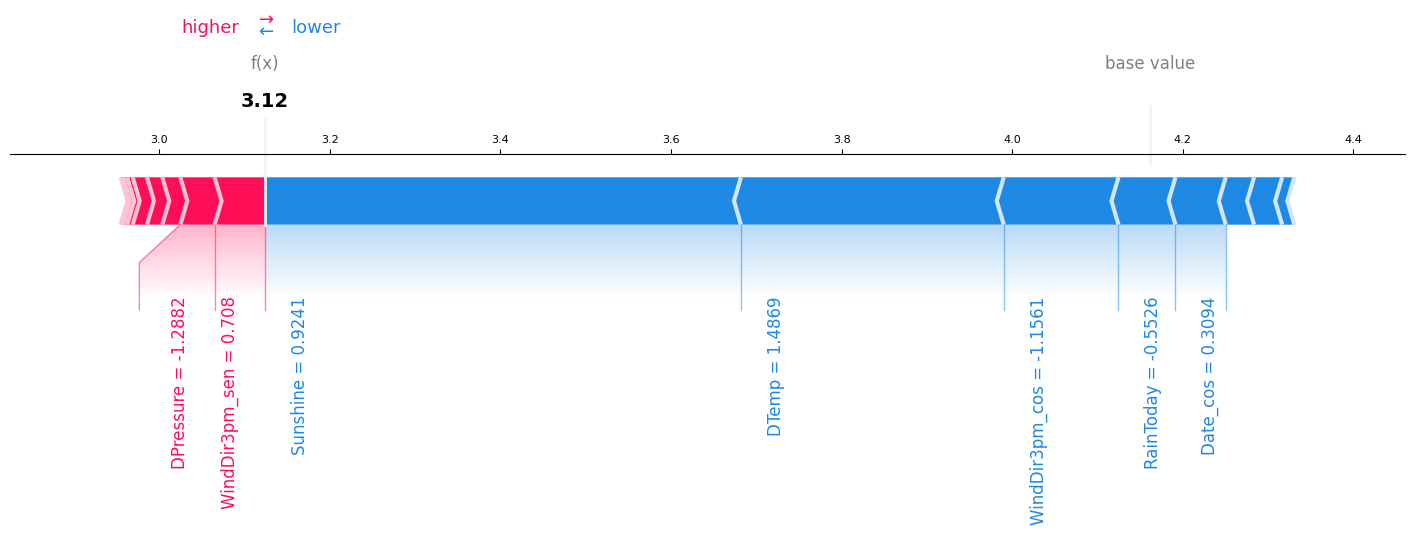

In [131]:
index=10
best_grid_model.predict(X_test_scaled)[index]
shap_values[index]

rounded_shap_values = np.round(shap_values[index], 4)
rounded_X_test = np.round(X_test_scaled[index], 4)

# Genera el gráfico de SHAP con valores redondeados
shap.force_plot(explainer.expected_value, rounded_shap_values, rounded_X_test, 
                feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=90)



El gráfico anterior es un gráfico de fuerza, que muestra cómo las características contribuyen a la predicción del valor de la variable target RainfallTomorrow. Se puede observar cómo impactan las distintas variables de manera positiva (en rojo) y negativa (en azul).
Las variables con mayor incidencia son las descritas en el gráfico, para el caso particular del elemento en la posición index.

Es mayor la cantidad variables que empujan la predicción hacia valores más bajos.

Principales 2 variables con incidencia positiva:
* WindDir3pm_sen
* DPressure

Principales variables con incidencia negativa:
* Sunshine
* DTemp
* WindDir3pm_cos
* RainToday
* Date_cos

Es así que, por ejemplo, valores más altos de DPressure tienen un peso positivo sobre la variable RainfallTomorrow.

En contraposición, valores altos para Sunshine o DTemp incidirán de manera negativa en en valor de la variable objetivo.

Gráfico de valores SHAP*100


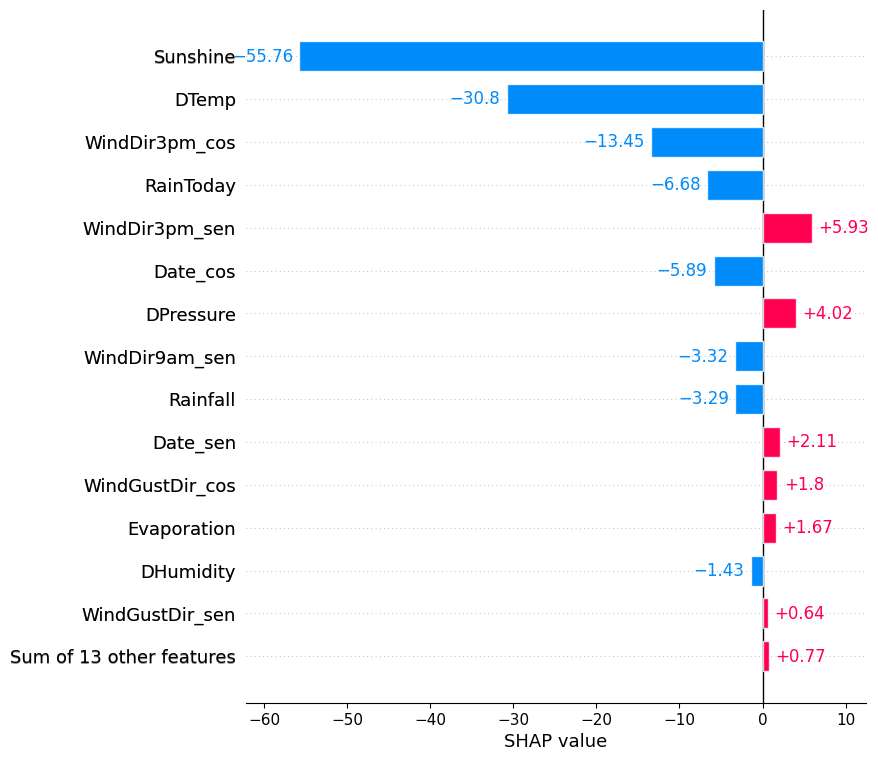

In [132]:
explanation = shap.Explanation(rounded_shap_values*100, base_values=explainer.expected_value, feature_names=feature_names)
print("Gráfico de valores SHAP*100")
shap.plots.bar(explanation, max_display=15)

El gráfico anterior es un gráfico de resumen de SHAP para la instancia individual elegida, donde se muestra cómo las características específicas contribuyen a la predicción en particular.
Este gráfico permite observar de manera más detallada el mismo comportamiento de las variables explicativas.

Nota: por una cuestión de visualización los valores shap se encuentran multiplicados por 100.

##### Interpretabilidad global

Se analiza la incidencia de las variables explicativas a nivel global, es decir para todas las muestras del conjunto de datos.

Gráfico de valores SHAP*100


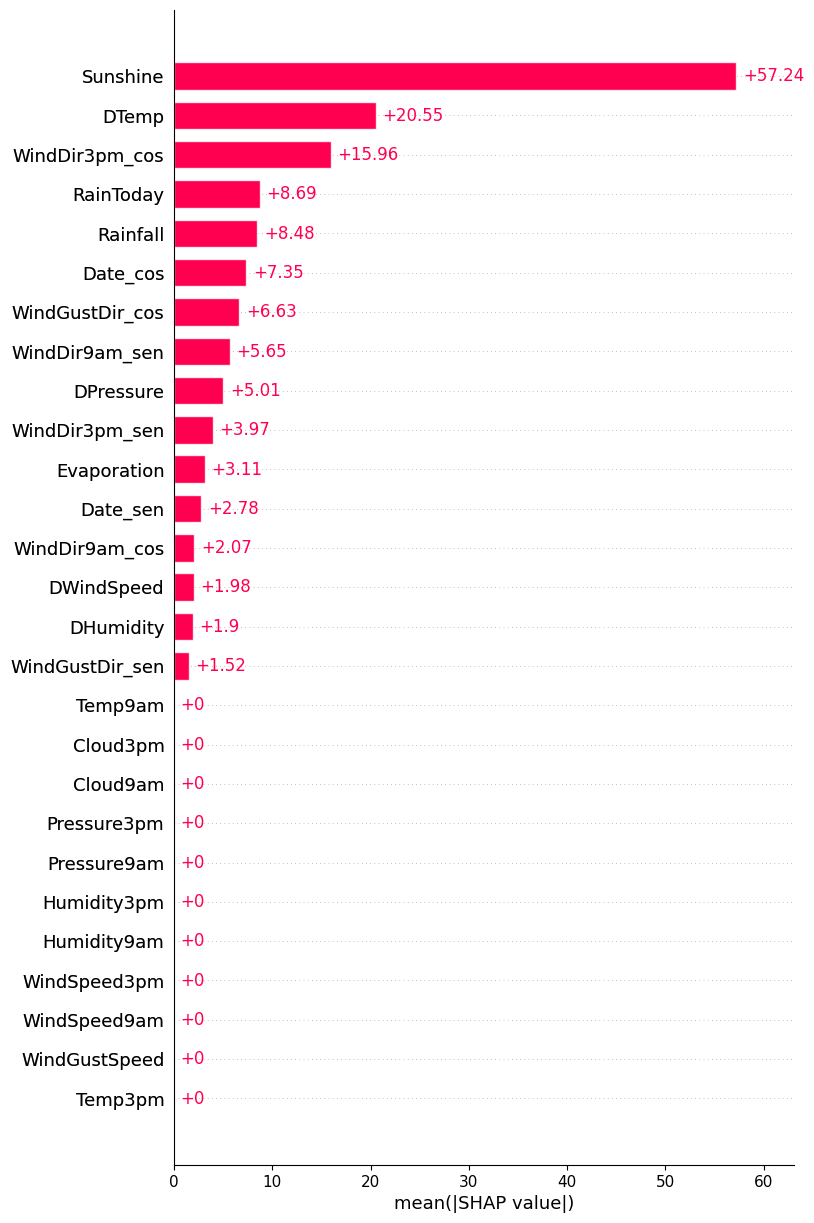

In [133]:
explanation = shap.Explanation(values=shap_values*100, base_values=explainer.expected_value, feature_names=feature_names, data=X_test)
print('Gráfico de valores SHAP*100')
shap.plots.bar(explanation, max_display=27)

Se observan diferencias con respecto a la interpretabilidad global comparada con la interpretabilidad local. En el gráfico de importancia global de las variables, todas las variables explicativas están ordenadas según su contribución promedio al modelo, medida por los valores SHAP.
En primer lugar todas las variables inciden de manera positiva en el valor de la variable objetivo.

Además desaparece DPressure como variable principal, quedando como las 5 variables principales:

Principales 5 variables con incidencia positiva:
* WindDir9am_cos (nueva)
* WindGustDir_cos (nueva)
* Date_cos (nueva)
* Rainfall (nueva)
* WindDir3pm_sen

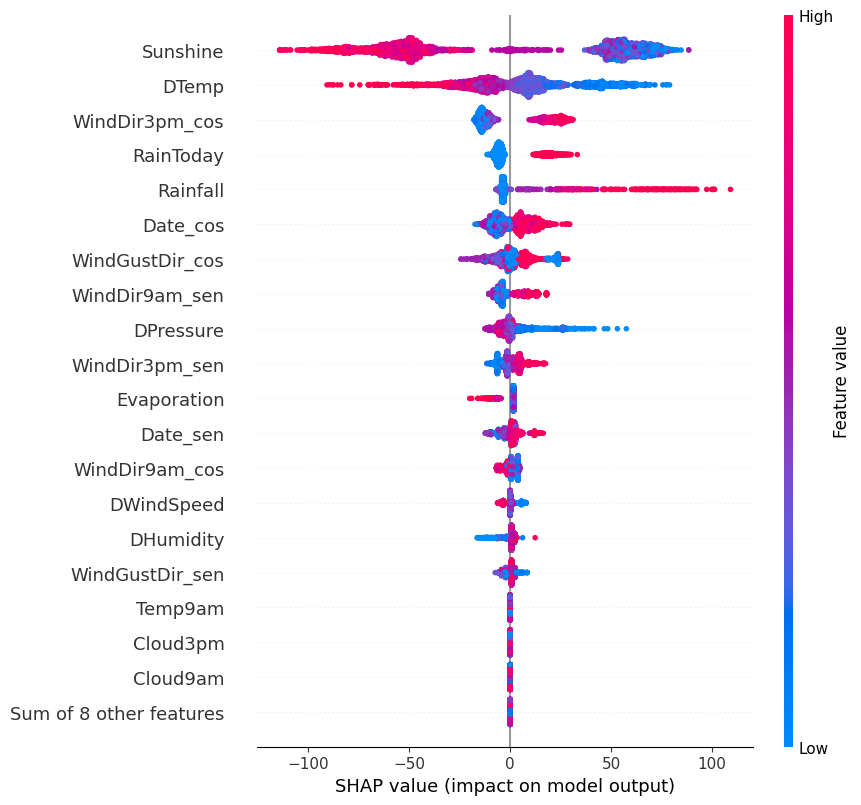

In [134]:
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 'large', 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium'})
shap.plots.beeswarm(explanation, max_display=20)

La gráfica anterior muestra las variables explicativas, ordenadas según su importancia global en el modelo, es decir considerando el impacto en la predicción de la probabilidad de lluvia para el día siguiente ("RainfallTomorrow"). Se analizan las cinco variables principales:

En primer lugar se encuentra la variable Sunshine, donde los valores más altos tienen una incidencia negativa en el valor de RainfallTomorrow, y en contraposición valores más bajos de Sunshine tienen un peso positivo en la variable target. Esto es lógico ya que es esperable que en días más soleados sea menos probable que llueva al día siguiente y viceversa.

En segundo lugar aparece la variable DTemp, con el mismo comportamiento que Sunshine, es decir que valores altos tienen un peso negativo en el valor de la variable target, y valores bajos una incidencia positiva.

La interpretación del coseno de la dirección del viento a las 3 PM (WindDir3pm_cos) es más compleja, pero se observa que valores más altos tienen una incidencia positiva en la variable target y viceversa. Se puede pensar entonces que valores altos se corresponden con direcciones direcciones de viento predominantemente hacia el norte, y que valores bajos se relacionen con direcciones de viento orientadas predomimantemente hacia el sur.

La variable RainToday tiene, para valores altos, un peso positivo sobre la variable target, y negativo para valores bajos. Resulta llamativa la dispersión de datos siendo que RainToday es una variable de tipo booleana. La alta dispersión de los valores SHAP para RainToday refleja la variabilidad en cómo esta característica influye en la predicción de RainfallTomorrow en diferentes contextos y condiciones meteorológicas. Esta variabilidad es capturada por el modelo y se expresa en los valores SHAP, que muestran cómo la contribución de RainToday a la predicción puede cambiar significativamente de una instancia a otra debido a interacciones complejas con otras características y a la naturaleza no lineal del modelo.

Por último la variable Rainfall tiende a aumentar, para valores altos, la probabilidad de lluvia al día siguiente, mientras que valores bajos (azul) tienen el efecto contrario.



#### Explicabilidad para clasificación:

In [135]:
#Para el problema de clasificación
X_train, y_train, X_test, y_test = split(df_train,df_test,'clasificacion')
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Define el modelo de regresión logística
logreg_ovs = LogisticRegression(penalty='l2')

# Entrenamiento del modelo
logreg_ovs.fit(X_train_scaled, y_train)


y_pred_proba = logreg_ovs.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.48040994851283947).astype(int)

feature_names=X_train.columns.values

# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(logreg_ovs, X_train_scaled, feature_names=feature_names)

# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)
shap_values.shape

(2860, 27)

##### Interpretabilidad local

In [136]:
index=10
logreg_ovs.predict_proba(X_test_scaled)[index]
logreg_ovs.predict(X_test_scaled)[index]

0.0

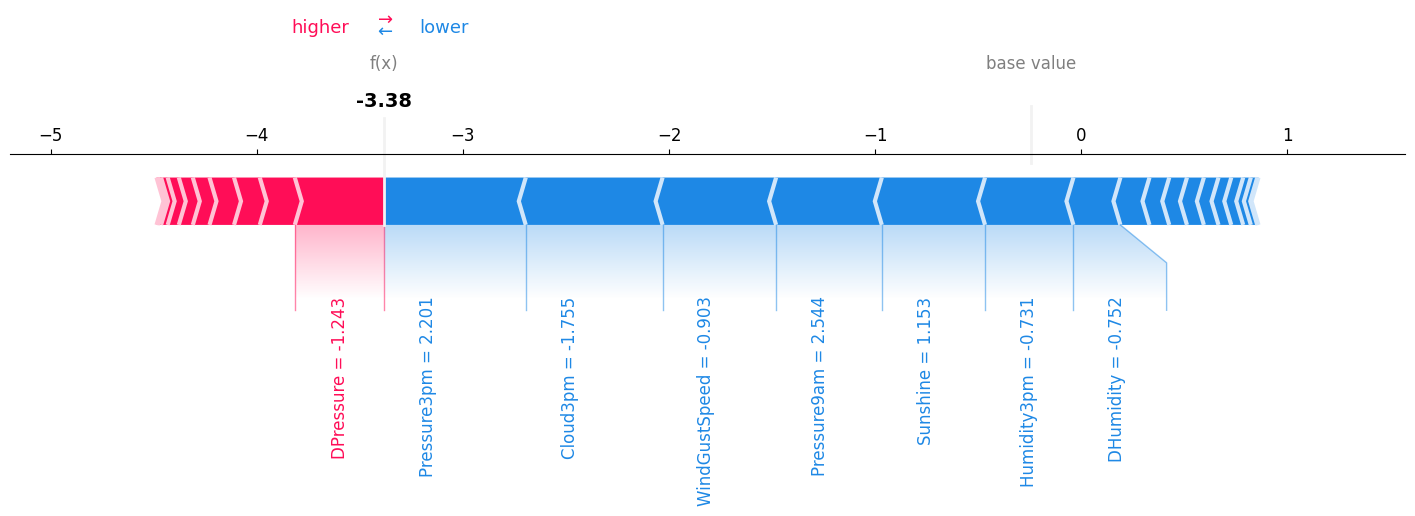

In [137]:
shap_values[index]

rounded_shap_values = np.round(shap_values[index], 3)
rounded_X_test = np.round(X_test_scaled[index], 3)

# Genera el gráfico de SHAP con valores redondeados
shap.force_plot(explainer.expected_value, rounded_shap_values, rounded_X_test, 
                feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=90)

Del gráfico de fuerza anterior se puede observar cómo impactan las variables de manera positiva (en rojo) y negativa (en azul).
Las variables con mayor incidencia son las descritas en el gráfico, para el caso particular del elemento en la posición index.

Resultan más las variables que empujan la predicción hacia la clase 0 (RainTomorrow=False).

Principal variable con incidencia positiva:
* DPressure(*)

Principales 5 variables con incidencia negativa:
* Pressure3pm       
* Cloud3pm
* WindGustSpeed
* Pressure9am
* Sunshine(*)

Si bien la muestra es la misma que se analizó en la intrepretabilidad local para el modelo de regresión, se observan que la mayoría de las variables principales no se mantienen, excepto DPressure y Sunshine.

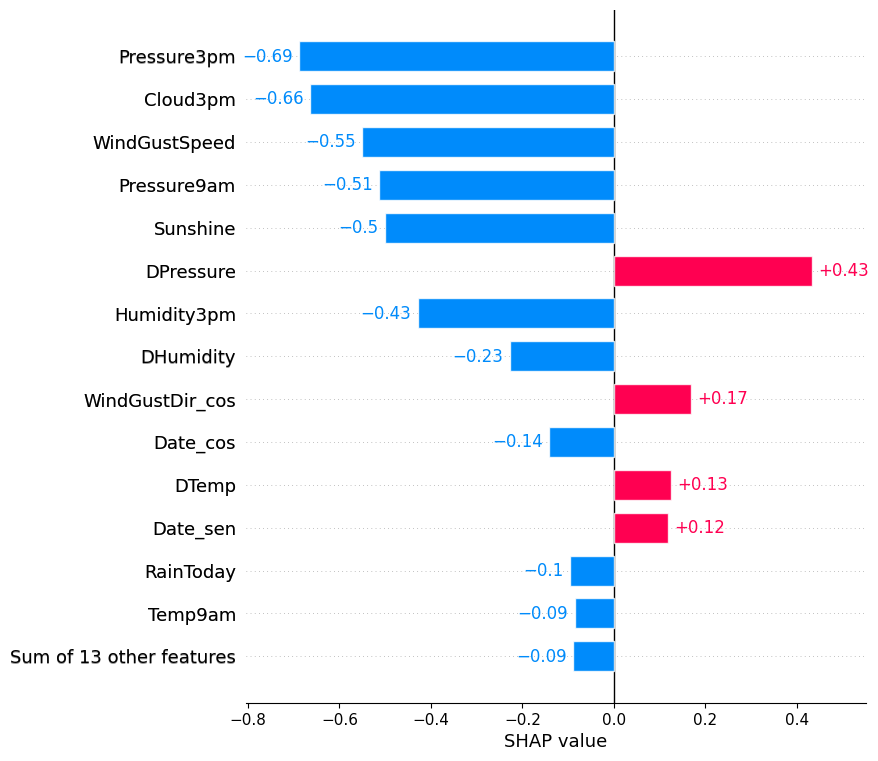

In [138]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.bar(explanation, max_display=15)

La gráfica anterior permite observar con más detalle lo expuesto previamente.

##### Interpretabilidad global

Gráfico de valores SHAP*100


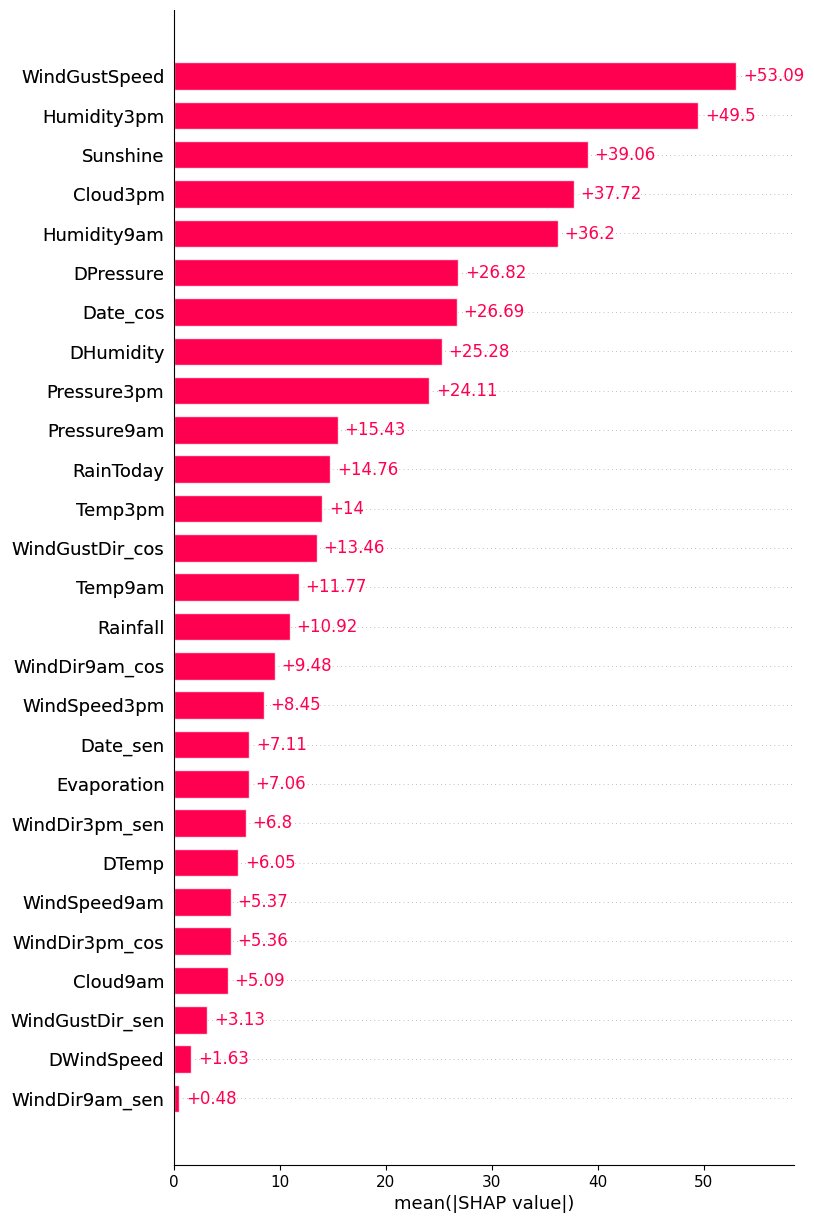

In [139]:
explanation = shap.Explanation(values=shap_values*100, base_values=explainer.expected_value, feature_names=feature_names, data=X_test)
print('Gráfico de valores SHAP*100')
shap.plots.bar(explanation, max_display=27)

Se observan diferencias con respecto a la interpretabilidad global comparada con la interpretabilidad local. En el gráfico de importancia global de las variables, todas las variables explicativas están ordenadas según su contribución promedio al modelo, medida por los valores SHAP.

Todas las variables explicativas empujan la predicción hacia la clase 1 (probabilidad de lluvia al día siguiente) en diferentes magnitudes, según los valores SHAP.

Además desaparece DPressure como una de las variables principales en comparación con la interpretación local anterior. En su lugar, las cinco variables con mayor incidencia positiva son:

* WindDir9am_cos
* WindGustDir_cos
* Date_cos
* Rainfall
* WindDir3pm_sen

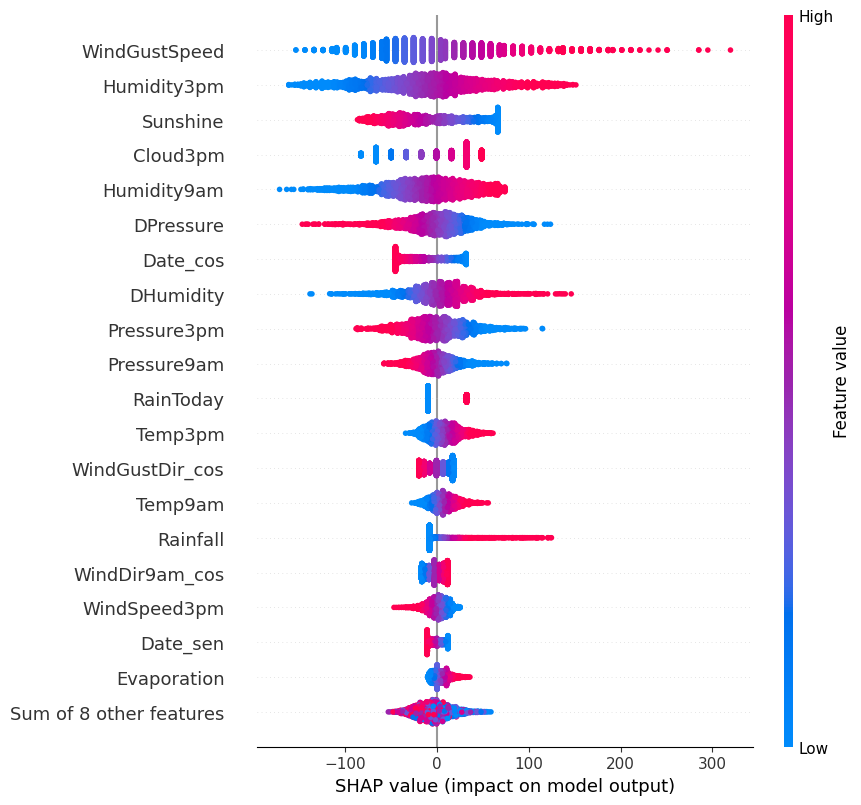

In [140]:
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 'large', 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium'})
shap.plots.beeswarm(explanation, max_display=20)

Para este gráfico de abejas se observa que las variables principales (excepto Sunshine) varían respecto al gráfico construido para el modelo de regresión.
En este caso se puede observar que WindGustSpeed empuja para valores altos hacia la clase 1 (RainTomorrow=True), y para valores bajos hacia la clase 0.

Un comportamiento similar se da para los valores de humedad a las 9am y 3pm, y para la variable Cloud3pm.

Sucede lo contrario para Sunshine, donde valores más altos tienen mayor peso para la clase 0, y viceversa.

#### Conclusiones generales sobre la explicabilidad:

En primer lugar se observa que la interpretabilidad local difiere de la global, para ambos casos de regresión y clasificación.
Esto es coherente con los valores de R2 obtenidos para regresión, que indican que el modelo obtenido no logra explicar de manera correcta la variabilidad de los datos.

En cuanto al análisis global, son lógicas las incidencias de las variables de mayor peso en las variables target. Por ejemplo, es razonable suponer que valores mayores de Sunshine empujen a que no llueva al día siguiente.

Por otro lado se observa que las variables de mayor peso para predecir las variables target no son las mismas para el modelo de regresión y comparación.

Sunshine es la única variable con alta incidencia común en ambos modelos. Esto indica que esta variable es consistentemente importante para predecir la probabilidad de lluvia en ambos enfoques (regresión y clasificación).

Variables con Menor Incidencia:
* WindGustDir_sen
* WindDir9am_sen
* DWindSpeed
* Temp3pm

Son variables que tienen menor incidencia en ambos modelos. Estas variables tienen un impacto relativamente bajo en la predicción de la probabilidad de lluvia en ambos modelos.

Estos hallazgos sugieren que la mayoría de las variables importantes difieren entre los modelos de regresión y clasificación, lo cual es esperado debido a las diferentes naturalezas de estos enfoques de modelado.

### 9.Redes neuronales

#### 9.1. Entrenamiento de modelos para Clasificación y Regresión

Se entrenan redes neuronales para resolver los problemas de clsificación y predicción.
Se definen previamente las siguientes funciones:

In [141]:
# Función para la fijación de la semilla
def set_seed(seed=50):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(50)

In [142]:
# Crear y entrenar el modelo final con los mejores hiperparámetros
def create_best_model(best_params, metodo='clasificacion'):
    num_layers = best_params['num_layers']
    epochs = best_params['epochs']
    batch_size = best_params['batch_size']
    optimizer = best_params.get('optimizer', 'adam')
    
    if metodo == 'clasificacion':
        loss = BinaryCrossentropy()
        metrics = [recall_min]
        output_units = best_params.get('output_units', 1)
        output_activation = 'sigmoid'
    elif metodo == 'regresion':
        loss = MeanSquaredError()
        metrics = [MSE()]
        output_units = best_params.get('output_units', 1)
        output_activation = 'linear'
    else:
        raise ValueError("problem_type debe ser 'clasificacion' o 'regresion'")

    model = Sequential()
    for i in range(num_layers):
        num_units = best_params[f'n_units_layer_{i}']
        dropout_rate = best_params[f'dropout_rate_layer_{i}']
        model.add(Dense(num_units, activation='relu'))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(output_units, activation=output_activation))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model, epochs, batch_size

In [191]:
# Función general para el entrenamiento de redes neuronales
def nn_model(X_train, y_train,X_test, y_test,metodo='clasificacion'): 
    set_seed(50) 

    if metodo=='clasificacion':
        direccion='maximize'
    elif metodo=='regresion':
        direccion='minimize'

    # crear un estudio de Optuna
    study = optuna.create_study(direction=direccion, sampler=optuna.samplers.TPESampler(seed=50))
    if metodo == 'clasificacion':
        study.optimize(objective_clasificador, n_trials=10)
    elif metodo == 'regresion':
        study.optimize(objective_regresor, n_trials=10)
    # obtener los mejores hiperparámetros
    best_params = study.best_params

    # Crear y entrenar el modelo final
    best_model, best_epochs, best_batch_size = create_best_model(best_params,metodo)
    best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=best_epochs, batch_size=best_batch_size, verbose=1)

    return best_model, study

En ningún caso se utilizará validaciones cruzadas k-folds en el entrenamiento de las redes. Si bien no es incorrecta su utlización, no se recomienda debido a que generalmente no se obtienen mejoras relevantes en comparación con el aumento en los tiempos de procesamiento.

La optimización de hiperparámetros se realiza con Optuna. Este método se elige por sobre Grid Search y Random Search por ser el más eficiente de los tres.

#### Resolución del problema de Clasificación

In [198]:
def objective_clasificador(trial):
    set_seed(50) 
    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()
    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 10, 100) # la cantidad de neuronas de cada capa tambien se puede pasar como hiperparámetro
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='relu')) # capas densas con activacion ReLU 
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0.4, 0.6)
        model.add(Dropout(dropout_rate))
    # capa de salida
    model.add(Dense(1, activation='sigmoid'))
    # compilar
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[recall_min])
    # entrenar
    epochs = trial.suggest_int('epochs', 10, 100)
    batch_size = trial.suggest_int('batch_size', 2048, 2048)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluar
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [199]:
X_train, y_train, X_test, y_test = split(df_train, df_test,'clasificacion')
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test) 
y_train = y_train.astype(float)
y_test = y_test.astype(float)
best_model_nn_clas, study = nn_model(X_train, y_train,X_test, y_test,'clasificacion')

[I 2024-06-08 15:29:49,084] A new study created in memory with name: no-name-7349a9d2-86ab-4ee6-ba30-6df2d5c85020


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7620 - recall_min: 0.5017 - val_loss: 0.6057 - val_recall_min: 0.6458
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6593 - recall_min: 0.5895 - val_loss: 0.5456 - val_recall_min: 0.6926
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5983 - recall_min: 0.6707 - val_loss: 0.5109 - val_recall_min: 0.7039
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5665 - recall_min: 0.7007 - val_loss: 0.4967 - val_recall_min: 0.7313
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5406 - recall_min: 0.7159 - val_loss: 0.4846 - val_recall_min: 0.7378
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5224 - recall_min: 0.7356 - val_loss: 0.4755 - val_recall_min: 0.7452
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5179 - recall_min: 0.7411 - val_loss: 0.4733 - val_recall_min: 0.7498
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5117 - recall_min: 0.

[I 2024-06-08 15:30:01,852] Trial 0 finished with value: 0.6764079332351685 and parameters: {'num_layers': 2, 'n_units_layer_0': 30, 'dropout_rate_layer_0': 0.45109478475144227, 'n_units_layer_1': 46, 'dropout_rate_layer_1': 0.4754630195382248, 'epochs': 100, 'batch_size': 2048}. Best is trial 0 with value: 0.6764079332351685.


Epoch 1/42
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7063 - recall_min: 0.5149 - val_loss: 0.5565 - val_recall_min: 0.6534
Epoch 2/42
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5887 - recall_min: 0.6736 - val_loss: 0.5080 - val_recall_min: 0.6946
Epoch 3/42
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5525 - recall_min: 0.7264 - val_loss: 0.4828 - val_recall_min: 0.6898
Epoch 4/42
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5270 - recall_min: 0.7404 - val_loss: 0.4777 - val_recall_min: 0.7303
Epoch 5/42
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5102 - recall_min: 0.7513 - val_loss: 0.4708 - val_recall_min: 0.7334
Epoch 6/42
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4942 - recall_min: 0.7626 - val_loss: 0.4634 - val_recall_min: 0.7303
Epoch 7/42
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4871 - recall_min: 0.7613 - val_loss: 0.4609 - val_recall_min: 0.7352
Epoch 8/42
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4793 - recall_min: 0.7697 - v

[I 2024-06-08 15:30:08,985] Trial 1 finished with value: 0.6760088801383972 and parameters: {'num_layers': 2, 'n_units_layer_0': 80, 'dropout_rate_layer_0': 0.5521073376017769, 'n_units_layer_1': 38, 'dropout_rate_layer_1': 0.4693082409125395, 'epochs': 42, 'batch_size': 2048}. Best is trial 0 with value: 0.6764079332351685.


Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7533 - recall_min: 0.3920 - val_loss: 0.5137 - val_recall_min: 0.5706
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5803 - recall_min: 0.6389 - val_loss: 0.4905 - val_recall_min: 0.6888
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5244 - recall_min: 0.7294 - val_loss: 0.4819 - val_recall_min: 0.7248
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5034 - recall_min: 0.7488 - val_loss: 0.4704 - val_recall_min: 0.7427
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4863 - recall_min: 0.7610 - val_loss: 0.4648 - val_recall_min: 0.7468
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4779 - recall_min: 0.7666 - val_loss: 0.4606 - val_recall_min: 0.7489
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4705 - recall_min: 0.7670 - val_loss: 0.4558 - val_recall_min: 0.7468
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4724 - recall_min: 0.7724 - v

[I 2024-06-08 15:30:16,960] Trial 2 finished with value: 0.6706509590148926 and parameters: {'num_layers': 1, 'n_units_layer_0': 98, 'dropout_rate_layer_0': 0.581835687598498, 'epochs': 60, 'batch_size': 2048}. Best is trial 0 with value: 0.6764079332351685.


Epoch 1/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8414 - recall_min: 0.2988 - val_loss: 0.5481 - val_recall_min: 0.4449
Epoch 2/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6207 - recall_min: 0.6095 - val_loss: 0.5132 - val_recall_min: 0.6551
Epoch 3/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5463 - recall_min: 0.7186 - val_loss: 0.4948 - val_recall_min: 0.7352
Epoch 4/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5143 - recall_min: 0.7462 - val_loss: 0.4788 - val_recall_min: 0.7482
Epoch 5/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4986 - recall_min: 0.7511 - val_loss: 0.4715 - val_recall_min: 0.7582
Epoch 6/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4901 - recall_min: 0.7560 - val_loss: 0.4652 - val_recall_min: 0.7582
Epoch 7/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4804 - recall_min: 0.7617 - val_loss: 0.4599 - val_recall_min: 0.7568
Epoch 8/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4738 - recall_min: 0.7642 - v

[I 2024-06-08 15:30:22,385] Trial 3 finished with value: 0.6733530163764954 and parameters: {'num_layers': 1, 'n_units_layer_0': 90, 'dropout_rate_layer_0': 0.5349146131644528, 'epochs': 45, 'batch_size': 2048}. Best is trial 0 with value: 0.6764079332351685.


Epoch 1/14
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7658 - recall_min: 0.5005 - val_loss: 0.5556 - val_recall_min: 0.6084
Epoch 2/14
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6258 - recall_min: 0.6370 - val_loss: 0.5002 - val_recall_min: 0.6987
Epoch 3/14
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5701 - recall_min: 0.6994 - val_loss: 0.4803 - val_recall_min: 0.7128
Epoch 4/14
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5370 - recall_min: 0.7265 - val_loss: 0.4706 - val_recall_min: 0.7073
Epoch 5/14
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5201 - recall_min: 0.7371 - val_loss: 0.4709 - val_recall_min: 0.7180
Epoch 6/14
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5058 - recall_min: 0.7501 - val_loss: 0.4652 - val_recall_min: 0.7245
Epoch 7/14
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4983 - recall_min: 0.7548 - val_loss: 0.4611 - val_recall_min: 0.7245
Epoch 8/14
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4941 - recall_min: 0.7588 - v

[I 2024-06-08 15:30:25,483] Trial 4 finished with value: 0.650144636631012 and parameters: {'num_layers': 2, 'n_units_layer_0': 57, 'dropout_rate_layer_0': 0.5856001855633105, 'n_units_layer_1': 61, 'dropout_rate_layer_1': 0.5336675137553359, 'epochs': 14, 'batch_size': 2048}. Best is trial 0 with value: 0.6764079332351685.


Epoch 1/94
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7657 - recall_min: 0.5559 - val_loss: 0.6221 - val_recall_min: 0.5998
Epoch 2/94
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7014 - recall_min: 0.6080 - val_loss: 0.5810 - val_recall_min: 0.6527
Epoch 3/94
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6422 - recall_min: 0.6436 - val_loss: 0.5509 - val_recall_min: 0.6819
Epoch 4/94
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6107 - recall_min: 0.6685 - val_loss: 0.5278 - val_recall_min: 0.7090
Epoch 5/94
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5880 - recall_min: 0.6928 - val_loss: 0.5123 - val_recall_min: 0.7214
Epoch 6/94
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5685 - recall_min: 0.7084 - val_loss: 0.5010 - val_recall_min: 0.7293
Epoch 7/94
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5501 - recall_min: 0.7191 - val_loss: 0.4920 - val_recall_min: 0.7307
Epoch 8/94
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5359 - recall_min: 0.7312 - v

[I 2024-06-08 15:30:38,255] Trial 5 finished with value: 0.6681042313575745 and parameters: {'num_layers': 1, 'n_units_layer_0': 15, 'dropout_rate_layer_0': 0.4359655388127575, 'epochs': 94, 'batch_size': 2048}. Best is trial 0 with value: 0.6764079332351685.


Epoch 1/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.8363 - recall_min: 0.3778 - val_loss: 0.6346 - val_recall_min: 0.5229
Epoch 2/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6978 - recall_min: 0.5138 - val_loss: 0.6135 - val_recall_min: 0.6513
Epoch 3/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6393 - recall_min: 0.5777 - val_loss: 0.5669 - val_recall_min: 0.6744
Epoch 4/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5946 - recall_min: 0.6594 - val_loss: 0.5175 - val_recall_min: 0.6685
Epoch 5/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5672 - recall_min: 0.6994 - val_loss: 0.4938 - val_recall_min: 0.6613
Epoch 6/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5483 - recall_min: 0.7167 - val_loss: 0.4887 - val_recall_min: 0.6713
Epoch 7/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5310 - recall_min: 0.7331 - val_loss: 0.4777 - val_recall_min: 0.6819
Epoch 8/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5201 - recall_min: 0.7

[I 2024-06-08 15:31:06,299] Trial 6 finished with value: 0.6804112195968628 and parameters: {'num_layers': 3, 'n_units_layer_0': 74, 'dropout_rate_layer_0': 0.5465375217813033, 'n_units_layer_1': 52, 'dropout_rate_layer_1': 0.5862658535211897, 'n_units_layer_2': 46, 'dropout_rate_layer_2': 0.536641154105469, 'epochs': 69, 'batch_size': 2048}. Best is trial 6 with value: 0.6804112195968628.


Epoch 1/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8086 - recall_min: 0.4524 - val_loss: 0.6208 - val_recall_min: 0.6239
Epoch 2/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6694 - recall_min: 0.5885 - val_loss: 0.5564 - val_recall_min: 0.6744
Epoch 3/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6132 - recall_min: 0.6608 - val_loss: 0.5174 - val_recall_min: 0.6946
Epoch 4/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5732 - recall_min: 0.7011 - val_loss: 0.4963 - val_recall_min: 0.7063
Epoch 5/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5515 - recall_min: 0.7220 - val_loss: 0.4845 - val_recall_min: 0.7150
Epoch 6/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5290 - recall_min: 0.7392 - val_loss: 0.4761 - val_recall_min: 0.7263
Epoch 7/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5169 - recall_min: 0.7455 - val_loss: 0.4743 - val_recall_min: 0.7385
Epoch 8/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5096 - recall_min: 0.7517 - v

[I 2024-06-08 15:31:13,606] Trial 7 finished with value: 0.6622656583786011 and parameters: {'num_layers': 2, 'n_units_layer_0': 30, 'dropout_rate_layer_0': 0.5364714338272758, 'n_units_layer_1': 89, 'dropout_rate_layer_1': 0.5593434526562137, 'epochs': 49, 'batch_size': 2048}. Best is trial 6 with value: 0.6804112195968628.


Epoch 1/66
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.8542 - recall_min: 0.2165 - val_loss: 0.6790 - val_recall_min: 0.5412
Epoch 2/66
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7056 - recall_min: 0.5025 - val_loss: 0.6285 - val_recall_min: 0.4913
Epoch 3/66
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6690 - recall_min: 0.5372 - val_loss: 0.5900 - val_recall_min: 0.6019
Epoch 4/66
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6314 - recall_min: 0.5944 - val_loss: 0.5384 - val_recall_min: 0.6833
Epoch 5/66
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6010 - recall_min: 0.6512 - val_loss: 0.5061 - val_recall_min: 0.7262
Epoch 6/66
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5801 - recall_min: 0.6895 - val_loss: 0.4932 - val_recall_min: 0.7156
Epoch 7/66
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5639 - recall_min: 0.7019 - val_loss: 0.4862 - val_recall_min: 0.7166
Epoch 8/66
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5508 - recall_min: 0.7131 - v

[I 2024-06-08 15:31:23,931] Trial 8 finished with value: 0.6719837188720703 and parameters: {'num_layers': 3, 'n_units_layer_0': 81, 'dropout_rate_layer_0': 0.5451500556698543, 'n_units_layer_1': 21, 'dropout_rate_layer_1': 0.5832616898705822, 'n_units_layer_2': 45, 'dropout_rate_layer_2': 0.45898590910540565, 'epochs': 66, 'batch_size': 2048}. Best is trial 6 with value: 0.6804112195968628.


Epoch 1/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7877 - recall_min: 0.4716 - val_loss: 0.6194 - val_recall_min: 0.5716
Epoch 2/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6929 - recall_min: 0.5740 - val_loss: 0.5921 - val_recall_min: 0.6765
Epoch 3/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6456 - recall_min: 0.6097 - val_loss: 0.5659 - val_recall_min: 0.6873
Epoch 4/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6142 - recall_min: 0.6510 - val_loss: 0.5406 - val_recall_min: 0.7041
Epoch 5/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5846 - recall_min: 0.6844 - val_loss: 0.5212 - val_recall_min: 0.7176
Epoch 6/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5674 - recall_min: 0.7040 - val_loss: 0.5116 - val_recall_min: 0.7331
Epoch 7/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5465 - recall_min: 0.7167 - val_loss: 0.5015 - val_recall_min: 0.7342
Epoch 8/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5367 - recall_min: 0.7314 - v

[I 2024-06-08 15:31:33,887] Trial 9 finished with value: 0.6665549278259277 and parameters: {'num_layers': 2, 'n_units_layer_0': 33, 'dropout_rate_layer_0': 0.5677991777408355, 'n_units_layer_1': 26, 'dropout_rate_layer_1': 0.4454228341393782, 'epochs': 70, 'batch_size': 2048}. Best is trial 6 with value: 0.6804112195968628.


Epoch 1/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.8036 - recall_min: 0.4534 - val_loss: 0.6338 - val_recall_min: 0.6965
Epoch 2/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6820 - recall_min: 0.5518 - val_loss: 0.5897 - val_recall_min: 0.7082
Epoch 3/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6244 - recall_min: 0.6363 - val_loss: 0.5396 - val_recall_min: 0.7218
Epoch 4/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5814 - recall_min: 0.6816 - val_loss: 0.5071 - val_recall_min: 0.7372
Epoch 5/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5504 - recall_min: 0.7018 - val_loss: 0.4985 - val_recall_min: 0.7490
Epoch 6/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5334 - recall_min: 0.7276 - val_loss: 0.4973 - val_recall_min: 0.7535
Epoch 7/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5147 - recall_min: 0.7419 - val_loss: 0.4930 - val_recall_min: 0.7605
Epoch 8/69
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5079 - recall_min: 0.7491 - v

In [234]:
# Optimización del umbral
def mejor_umbral(model, X_test, y_test, thresholds):
    best_threshold = None
    best_specificity = 0.78
    best_tpr = 0.78
    
    for threshold in thresholds:
        y_pred_proba = model.predict(X_test).flatten()
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        precision, recall, f1, specificity = logreg_metrics(y_test, y_pred)
        
        # Guardar el mejor umbral basado en el mínimo valor de especificidad y TPR
        if specificity > best_specificity and recall > best_tpr:
            best_specificity = specificity
            best_tpr = recall
            best_threshold = threshold     
    return best_threshold

In [236]:
# Definir un rango de umbrales para probar
thresholds = np.arange(0.40, 0.6, 0.001)

best_threshold = mejor_umbral(best_model_nn_clas, X_test, y_test, thresholds)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
precision: 0.4593114241001565
TPR: 0.8800599700149925
f1: 0.603598971722365
specificity 0.684906520747834
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
precision: 0.46003134796238243
TPR: 0.8800599700149925
f1: 0.6042202779207411
specificity 0.6858185134518924
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
precision: 0.46075353218210363
TPR: 0.8800599700149925
f1: 0.6048428645028336
specificity 0.6867305061559508
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
precision: 0.4606918238993711
TPR: 0.8785607196401799
f1: 0.6044352759154203
specificity 0.68718650250798
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
precision: 0.46105428796223447
TPR: 0.8785607196401799
f1: 0.6047471620227038
specificity 0.6876424988600092
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
precision: 0.4628751974723539
TPR: 0.8785607196401799
f1: 0.6063114330056907
specificity 0.689922480620155
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
precision: 0.46281645569620256
TPR: 0.8770614692653673
f1: 0.6059036768

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
{'num_layers': 3, 'n_units_layer_0': 74, 'dropout_rate_layer_0': 0.5465375217813033, 'n_units_layer_1': 52, 'dropout_rate_layer_1': 0.5862658535211897, 'n_units_layer_2': 46, 'dropout_rate_layer_2': 0.536641154105469, 'epochs': 69, 'batch_size': 2048}
precision: 0.5243296921549155
TPR: 0.7916041979010495
f1: 0.6308243727598566
specificity 0.781577747378021
Recall: 0.7916041979010495


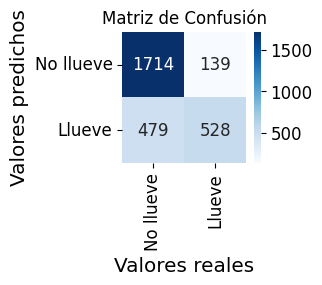

In [237]:
y_pred = best_model_nn_clas.predict(X_test)
y_pred = (y_pred >= best_threshold).astype(int)

best_params = study.best_params
print(best_params)
recall_nn = recall_score(y_test, y_pred)
precision_nn, tpr_nn, f1_nn, specificity_nn = logreg_metrics(y_test,y_pred)
print("Recall:", recall_nn)
matriz_conf(y_test,y_pred)

##### Conclusiones:

Se obtiene un modelo superador a los ya obtenidos que acertará en un 82% tanto en los días lluviosos, como en los no lluviosos, a cambio de no ser tan preciso para la clase Lluvia=True, ya que tiene un 51% de tasa de acierto cada vez que prediga que lloverá.

En otras palabras, se prioriza la sensibilidad por sobre la precisión.
Esta elección se fundamenta entendiendo que es más deseable indicar que lloverá aunque no suceda (falsos positivos) en vez de predecir que no lloverá y que sí pase (falsos negativos).

Naturalmente existe un límite para este criterio, ya que si se reducen al mínimo los falsos negativos la mayoría de las predicciones de lluvia serán erradas (aumentan los falsos positivos) y el modelo dejará de ser creíble perdiendo valor.

En definitiva, no hay un criterio único ni un límite establecido en las métricas para el diseño del modelo, sino que se definieron en busca del balance descripto.

#### Resolución del problema de Regresión

In [147]:
def objective_regresor(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()
    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 10, 100) # la cantidad de neuronas de cada capa tambien se puede pasar como hiperparámetro
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='relu')) # capas densas con activacion ReLU 
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0.4, 0.6)
        model.add(Dropout(dropout_rate))
    # capa de salida
    model.add(Dense(1, activation='linear'))
    # compilar
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    # entrenar
    epochs = trial.suggest_int('epochs', 10, 100)
    batch_size = trial.suggest_int('batch_size', 256, 512)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluar
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [148]:
X_train, y_train, X_test, y_test = split(df_train, df_test,'regresion')
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

best_model_nn_reg, study = nn_model(X_train, y_train,X_test, y_test,'regresion')

[I 2024-06-08 14:12:32,856] A new study created in memory with name: no-name-922c4a59-c0be-4a58-ba93-22b6d8567665


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 39.6395 - mean_squared_error: 39.6395 - val_loss: 43.1446 - val_mean_squared_error: 43.1446
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.2455 - mean_squared_error: 34.2455 - val_loss: 39.1200 - val_mean_squared_error: 39.1200
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.0577 - mean_squared_error: 32.0577 - val_loss: 37.7905 - val_mean_squared_error: 37.7905
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.2974 - mean_squared_error: 30.2974 - val_loss: 36.9941 - val_mean_squared_error: 36.9941
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.5624 - mean_squared_error: 30.5624 - val_loss: 36.6222 - val_mean_squared_error: 36.6222
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.3246 - mean_squared_error: 29.3246 - val_loss: 36.1840 - val_mean_squared_error: 36.1840
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.1143 - mean_squared_error: 29.11

[I 2024-06-08 14:13:07,856] Trial 0 finished with value: 34.38817596435547 and parameters: {'num_layers': 2, 'n_units_layer_0': 30, 'dropout_rate_layer_0': 0.45109478475144227, 'n_units_layer_1': 46, 'dropout_rate_layer_1': 0.4754630195382248, 'epochs': 100, 'batch_size': 360}. Best is trial 0 with value: 34.38817596435547.


Epoch 1/92
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 39.8803 - mean_squared_error: 39.8803 - val_loss: 43.6598 - val_mean_squared_error: 43.6598
Epoch 2/92
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34.9529 - mean_squared_error: 34.9529 - val_loss: 39.3137 - val_mean_squared_error: 39.3137
Epoch 3/92
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.6992 - mean_squared_error: 32.6992 - val_loss: 38.0665 - val_mean_squared_error: 38.0665
Epoch 4/92
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.0510 - mean_squared_error: 32.0510 - val_loss: 37.2549 - val_mean_squared_error: 37.2549
Epoch 5/92
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.4145 - mean_squared_error: 31.4145 - val_loss: 37.1350 - val_mean_squared_error: 37.1350
Epoch 6/92
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.2490 - mean_squared_error: 30.2490 - val_loss: 36.4403 - val_mean_squared_error: 36.4403
Epoch 7/92
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.9845 - mean_squared_error: 29.9845 - v

[I 2024-06-08 14:13:35,224] Trial 1 finished with value: 34.31277084350586 and parameters: {'num_layers': 3, 'n_units_layer_0': 79, 'dropout_rate_layer_0': 0.4620018697370664, 'n_units_layer_1': 41, 'dropout_rate_layer_1': 0.4703529634993125, 'n_units_layer_2': 23, 'dropout_rate_layer_2': 0.59453293694349, 'epochs': 92, 'batch_size': 399}. Best is trial 1 with value: 34.31277084350586.


Epoch 1/45
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 37.2164 - mean_squared_error: 37.2164 - val_loss: 39.0983 - val_mean_squared_error: 39.0983
Epoch 2/45
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.7865 - mean_squared_error: 30.7865 - val_loss: 36.7003 - val_mean_squared_error: 36.7003
Epoch 3/45
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.3635 - mean_squared_error: 29.3635 - val_loss: 35.9543 - val_mean_squared_error: 35.9543
Epoch 4/45
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.4144 - mean_squared_error: 28.4144 - val_loss: 35.4324 - val_mean_squared_error: 35.4324
Epoch 5/45
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.2970 - mean_squared_error: 28.2970 - val_loss: 35.1974 - val_mean_squared_error: 35.1974
Epoch 6/45
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.1425 - mean_squared_error: 28.1425 - val_loss: 35.0820 - val_mean_squared_error: 35.0820
Epoch 7/45
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.6582 - mean_squared_error: 27.6582 - va

[I 2024-06-08 14:13:46,775] Trial 2 finished with value: 33.91464614868164 and parameters: {'num_layers': 1, 'n_units_layer_0': 90, 'dropout_rate_layer_0': 0.5349146131644528, 'epochs': 45, 'batch_size': 386}. Best is trial 2 with value: 33.91464614868164.


Epoch 1/39
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 35.7893 - mean_squared_error: 35.7893 - val_loss: 37.3049 - val_mean_squared_error: 37.3049
Epoch 2/39
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.9846 - mean_squared_error: 29.9846 - val_loss: 36.1203 - val_mean_squared_error: 36.1203
Epoch 3/39
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.9481 - mean_squared_error: 28.9481 - val_loss: 35.2117 - val_mean_squared_error: 35.2117
Epoch 4/39
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.7149 - mean_squared_error: 27.7149 - val_loss: 35.0896 - val_mean_squared_error: 35.0896
Epoch 5/39
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.8356 - mean_squared_error: 27.8356 - val_loss: 34.6237 - val_mean_squared_error: 34.6237
Epoch 6/39
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.6640 - mean_squared_error: 27.6640 - val_loss: 34.6396 - val_mean_squared_error: 34.6396
Epoch 7/39
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.3076 - mean_squared_error: 27.3076 - va

[I 2024-06-08 14:13:59,904] Trial 3 finished with value: 34.17800521850586 and parameters: {'num_layers': 2, 'n_units_layer_0': 94, 'dropout_rate_layer_0': 0.5142746138077853, 'n_units_layer_1': 70, 'dropout_rate_layer_1': 0.4104517382213019, 'epochs': 39, 'batch_size': 270}. Best is trial 2 with value: 33.91464614868164.


Epoch 1/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 41.8237 - mean_squared_error: 41.8237 - val_loss: 42.4637 - val_mean_squared_error: 42.4637
Epoch 2/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.2301 - mean_squared_error: 33.2301 - val_loss: 38.3944 - val_mean_squared_error: 38.3944
Epoch 3/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.6562 - mean_squared_error: 30.6562 - val_loss: 37.0364 - val_mean_squared_error: 37.0364
Epoch 4/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.6619 - mean_squared_error: 29.6619 - val_loss: 36.3762 - val_mean_squared_error: 36.3762
Epoch 5/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.6932 - mean_squared_error: 28.6932 - val_loss: 35.9776 - val_mean_squared_error: 35.9776
Epoch 6/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.6681 - mean_squared_error: 28.6681 - val_loss: 35.6635 - val_mean_squared_error: 35.6635
Epoch 7/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.1162 - mean_squared_error: 28.1162 - v

[I 2024-06-08 14:14:13,885] Trial 4 finished with value: 33.56740188598633 and parameters: {'num_layers': 1, 'n_units_layer_0': 94, 'dropout_rate_layer_0': 0.5876030445884783, 'epochs': 74, 'batch_size': 444}. Best is trial 4 with value: 33.56740188598633.


Epoch 1/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 38.5863 - mean_squared_error: 38.5863 - val_loss: 38.4054 - val_mean_squared_error: 38.4054
Epoch 2/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30.8698 - mean_squared_error: 30.8698 - val_loss: 36.6132 - val_mean_squared_error: 36.6132
Epoch 3/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.4833 - mean_squared_error: 29.4833 - val_loss: 35.6306 - val_mean_squared_error: 35.6306
Epoch 4/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.3565 - mean_squared_error: 28.3565 - val_loss: 34.9897 - val_mean_squared_error: 34.9897
Epoch 5/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.7299 - mean_squared_error: 27.7299 - val_loss: 34.8215 - val_mean_squared_error: 34.8215
Epoch 6/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.5869 - mean_squared_error: 27.5869 - val_loss: 34.5386 - val_mean_squared_error: 34.5386
Epoch 7/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.2395 - mean_squared_error: 27.2395 - va

[I 2024-06-08 14:14:31,655] Trial 5 finished with value: 34.069908142089844 and parameters: {'num_layers': 2, 'n_units_layer_0': 94, 'dropout_rate_layer_0': 0.4812840486681615, 'n_units_layer_1': 72, 'dropout_rate_layer_1': 0.5299831736178124, 'epochs': 64, 'batch_size': 313}. Best is trial 4 with value: 33.56740188598633.


Epoch 1/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 41.6214 - mean_squared_error: 41.6214 - val_loss: 41.7580 - val_mean_squared_error: 41.7580
Epoch 2/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34.5711 - mean_squared_error: 34.5711 - val_loss: 38.7088 - val_mean_squared_error: 38.7088
Epoch 3/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.5948 - mean_squared_error: 32.5948 - val_loss: 37.3977 - val_mean_squared_error: 37.3977
Epoch 4/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.9320 - mean_squared_error: 30.9320 - val_loss: 37.4124 - val_mean_squared_error: 37.4124
Epoch 5/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.5567 - mean_squared_error: 30.5567 - val_loss: 36.3563 - val_mean_squared_error: 36.3563
Epoch 6/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.1346 - mean_squared_error: 30.1346 - val_loss: 36.0539 - val_mean_squared_error: 36.0539
Epoch 7/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.9079 - mean_squared_error: 28.9079 - v

[I 2024-06-08 14:14:42,849] Trial 6 finished with value: 35.072444915771484 and parameters: {'num_layers': 3, 'n_units_layer_0': 89, 'dropout_rate_layer_0': 0.5593434526562137, 'n_units_layer_1': 49, 'dropout_rate_layer_1': 0.5835756438316779, 'n_units_layer_2': 81, 'dropout_rate_layer_2': 0.5451500556698543, 'epochs': 21, 'batch_size': 491}. Best is trial 4 with value: 33.56740188598633.


Epoch 1/86
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 38.5305 - mean_squared_error: 38.5305 - val_loss: 39.8433 - val_mean_squared_error: 39.8433
Epoch 2/86
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33.0295 - mean_squared_error: 33.0295 - val_loss: 38.0533 - val_mean_squared_error: 38.0533
Epoch 3/86
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.3270 - mean_squared_error: 31.3270 - val_loss: 37.0534 - val_mean_squared_error: 37.0534
Epoch 4/86
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.2777 - mean_squared_error: 30.2777 - val_loss: 36.5464 - val_mean_squared_error: 36.5464
Epoch 5/86
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.3673 - mean_squared_error: 29.3673 - val_loss: 36.0652 - val_mean_squared_error: 36.0652
Epoch 6/86
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.1375 - mean_squared_error: 29.1375 - val_loss: 35.6555 - val_mean_squared_error: 35.6555
Epoch 7/86
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.1652 - mean_squared_error: 29.1652 - va

[I 2024-06-08 14:15:08,254] Trial 7 finished with value: 33.87382125854492 and parameters: {'num_layers': 2, 'n_units_layer_0': 36, 'dropout_rate_layer_0': 0.5233462829445028, 'n_units_layer_1': 52, 'dropout_rate_layer_1': 0.4510677828689127, 'epochs': 86, 'batch_size': 301}. Best is trial 4 with value: 33.56740188598633.


Epoch 1/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 38.4023 - mean_squared_error: 38.4023 - val_loss: 39.1528 - val_mean_squared_error: 39.1528
Epoch 2/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.9286 - mean_squared_error: 30.9286 - val_loss: 36.9471 - val_mean_squared_error: 36.9471
Epoch 3/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.4606 - mean_squared_error: 29.4606 - val_loss: 36.1390 - val_mean_squared_error: 36.1390
Epoch 4/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.7992 - mean_squared_error: 28.7992 - val_loss: 35.7211 - val_mean_squared_error: 35.7211
Epoch 5/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.3122 - mean_squared_error: 28.3122 - val_loss: 35.4145 - val_mean_squared_error: 35.4145
Epoch 6/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.9661 - mean_squared_error: 27.9661 - val_loss: 35.1795 - val_mean_squared_error: 35.1795
Epoch 7/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.8293 - mean_squared_error: 27.8293 - va

[I 2024-06-08 14:15:13,026] Trial 8 finished with value: 34.45884704589844 and parameters: {'num_layers': 1, 'n_units_layer_0': 70, 'dropout_rate_layer_0': 0.4958232490085906, 'epochs': 16, 'batch_size': 291}. Best is trial 4 with value: 33.56740188598633.


Epoch 1/97
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 42.9569 - mean_squared_error: 42.9569 - val_loss: 43.0917 - val_mean_squared_error: 43.0917
Epoch 2/97
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.7420 - mean_squared_error: 34.7420 - val_loss: 38.4835 - val_mean_squared_error: 38.4835
Epoch 3/97
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.5069 - mean_squared_error: 31.5069 - val_loss: 36.9719 - val_mean_squared_error: 36.9719
Epoch 4/97
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.3572 - mean_squared_error: 30.3572 - val_loss: 36.3979 - val_mean_squared_error: 36.3979
Epoch 5/97
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.0565 - mean_squared_error: 29.0565 - val_loss: 36.0503 - val_mean_squared_error: 36.0503
Epoch 6/97
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.5999 - mean_squared_error: 28.5999 - val_loss: 35.7973 - val_mean_squared_error: 35.7973
Epoch 7/97
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.1553 - mean_squared_error: 28.1553 - v

[I 2024-06-08 14:15:37,255] Trial 9 finished with value: 33.622501373291016 and parameters: {'num_layers': 1, 'n_units_layer_0': 53, 'dropout_rate_layer_0': 0.5080592458540844, 'epochs': 97, 'batch_size': 406}. Best is trial 4 with value: 33.56740188598633.


Epoch 1/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 37.9359 - mean_squared_error: 37.9359 - val_loss: 40.7355 - val_mean_squared_error: 40.7355
Epoch 2/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.4419 - mean_squared_error: 32.4419 - val_loss: 37.9838 - val_mean_squared_error: 37.9838
Epoch 3/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.2687 - mean_squared_error: 30.2687 - val_loss: 36.8267 - val_mean_squared_error: 36.8267
Epoch 4/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.4113 - mean_squared_error: 29.4113 - val_loss: 36.1518 - val_mean_squared_error: 36.1518
Epoch 5/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.7493 - mean_squared_error: 28.7493 - val_loss: 35.7292 - val_mean_squared_error: 35.7292
Epoch 6/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.5683 - mean_squared_error: 28.5683 - val_loss: 35.4507 - val_mean_squared_error: 35.4507
Epoch 7/74
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.1699 - mean_squared_error: 28.1699 - v

In [149]:
best_params = study.best_params
print(best_params)
# Se guardan las predicciones del modelo
y_pred_train = best_model_nn_reg.predict(X_train)
y_pred_test = best_model_nn_reg.predict(X_test)

# Se calcula el error de train del modelo con rmse para mantener la misma escala que la variable a predecir
rmse_nn_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_nn_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"El error rmse_nn_train es: {rmse_nn_train}")
print(f"El error rmse_nn_test es: {rmse_nn_test}")

R2_nn_train = metrics.r2_score(y_train, y_pred_train)
print(f"El valor de R2_nn_train: {R2_nn_train}")
R2_nn_test = metrics.r2_score(y_test, y_pred_test)
print(f"El valor de R2_nn_test: {R2_nn_test}")

{'num_layers': 1, 'n_units_layer_0': 94, 'dropout_rate_layer_0': 0.5876030445884783, 'epochs': 74, 'batch_size': 444}
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
El error rmse_nn_train es: 4.960243868982988
El error rmse_nn_test es: 5.810716685276149
El valor de R2_nn_train: 0.33522820934940567
El valor de R2_nn_test: 0.26805832168138377


#### 9.2. Explicabilidad de los modelos mediante SHAP

Se utiliza SHAP para explicar las variables de los modelos para regresión y clasificación en los modelos de redes entrenados.

In [150]:
# Restablece el estilo de matplotlib
plt.rcdefaults()
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
})

plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)

##### Explicabilidad para regresión:

In [151]:
#Para el problema de regresión
X_train, y_train, X_test, y_test = split(df_train, df_test, 'regresion')
feature_names = X_train.columns.values

# Reducir la cantidad de muestras para reducir el tiempo de ejecución de SHAP,
# se resetea el índice para que sean consecutivos y comiencen en cero
n_train = int(len(df_train) * 0.02)
n_test = int(len(df_test) * 0.02)
X_train = X_train.sample(n=n_train, random_state=42).reset_index(drop=True)
X_test = X_test.sample(n=n_test, random_state=42).reset_index(drop=True)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir los arrays escalados de nuevo a DataFrames de pandas utilizando los nombres de las características
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Crear un objeto explainer SHAP usando KernelExplainer
explainer = shap.KernelExplainer(best_model_nn_reg, X_train_scaled.values, feature_names=feature_names)

# Calcular los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled.values)

shap_values = np.squeeze(shap_values)

# Verificar la forma de los valores SHAP
print(shap_values.shape)

Using 382 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 57/57 [04:47<00:00,  5.05s/it]

(57, 27)


###### Interpretabilidad local

Se construyen dos gráficas para la interpretación de la explicabilidad a nivel local, en nuestro caso para el elemento index del conjunto de datos.

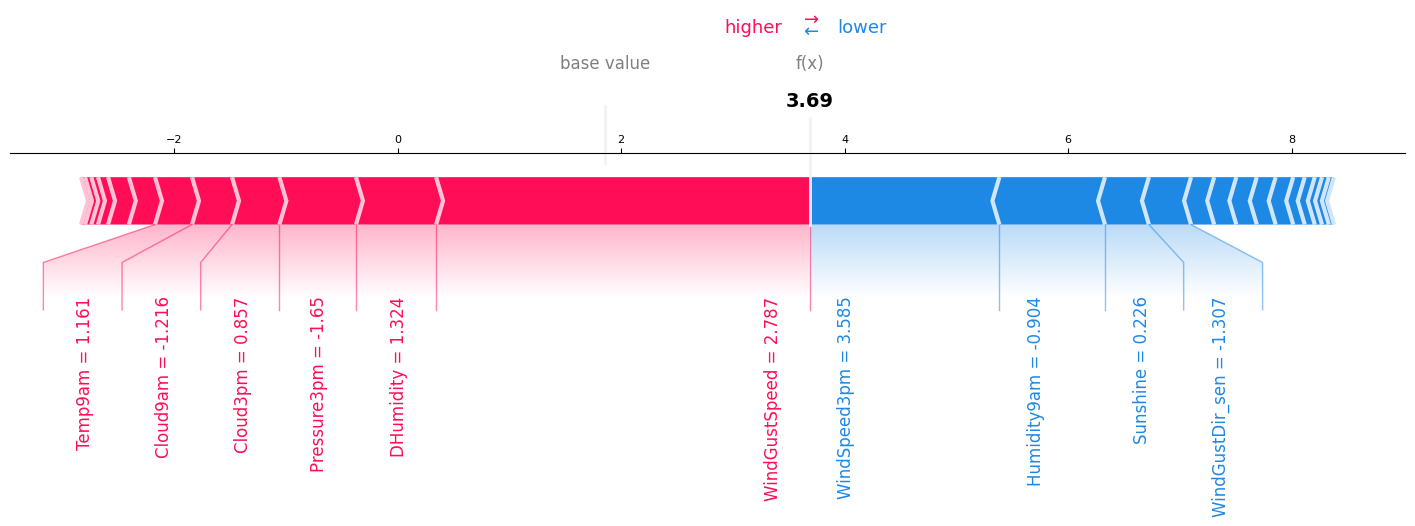

In [152]:
index=10
shap_values[index]

rounded_shap_values = np.round(shap_values[index], 3)
rounded_X_test = np.round(X_test_scaled.iloc[index], 3)

# Genera el gráfico de SHAP con valores redondeados
shap.force_plot(explainer.expected_value, rounded_shap_values, rounded_X_test, 
                feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=90)


El gráfico anterior es un gráfico de fuerza, que muestra cómo las características contribuyen a la predicción del valor de la variable target RainfallTomorrow. Se puede observar cómo impactan las distintas variables de manera positiva (en rojo) y negativa (en azul).
Las variables con mayor incidencia son las descritas en el gráfico, para el caso particular del elemento en la posición index.

Si bien el gráfico se encuentra bastante balanceado, se observa un mayor peso de las variables que empujan hacia valores más altos.

Principales variables con incidencia positiva:
* WindGustSpeed
* DHumidity
* Pressure3pm
* Cloud3pm
* Cloud9am

Principales variables con incidencia negativa:
* WindSpeed3pm
* Humidity9am
* Sunshine
* WindGustDir_sen

Es así que, por ejemplo, valores más altos de WindGustSpeed tienen un peso positivo sobre la variable RainfallTomorrow.

En contraposición, valores altos para WindSpeed3pm o Humidity9am incidirán de manera negativa en en valor de la variable objetivo.

Gráfico de valores SHAP


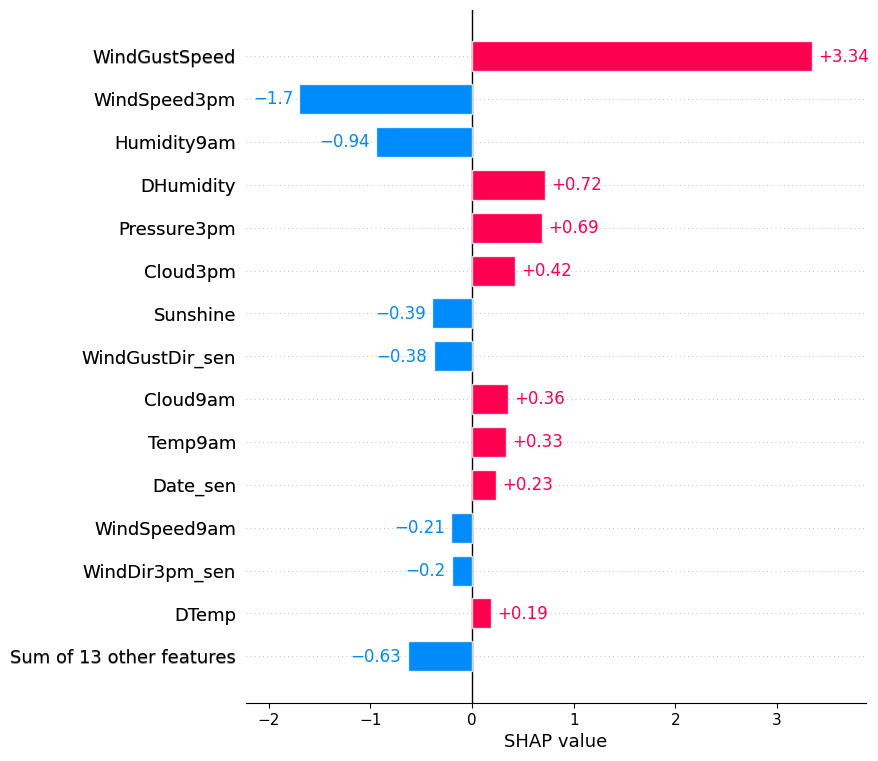

In [153]:
explanation = shap.Explanation(rounded_shap_values, base_values=explainer.expected_value, feature_names=feature_names)
print("Gráfico de valores SHAP")
shap.plots.bar(explanation, max_display=15)

El gráfico anterior es un gráfico de resumen de SHAP para la instancia individual elegida, donde se muestra cómo las características específicas contribuyen a la predicción en particular.
Este gráfico permite observar de manera más detallada el mismo comportamiento de las variables explicativas.

###### Interpretabilidad global

Se analiza la incidencia de las variables explicativas a nivel global, es decir para todas las muestras del conjunto de datos.

Gráfico de valores SHAP


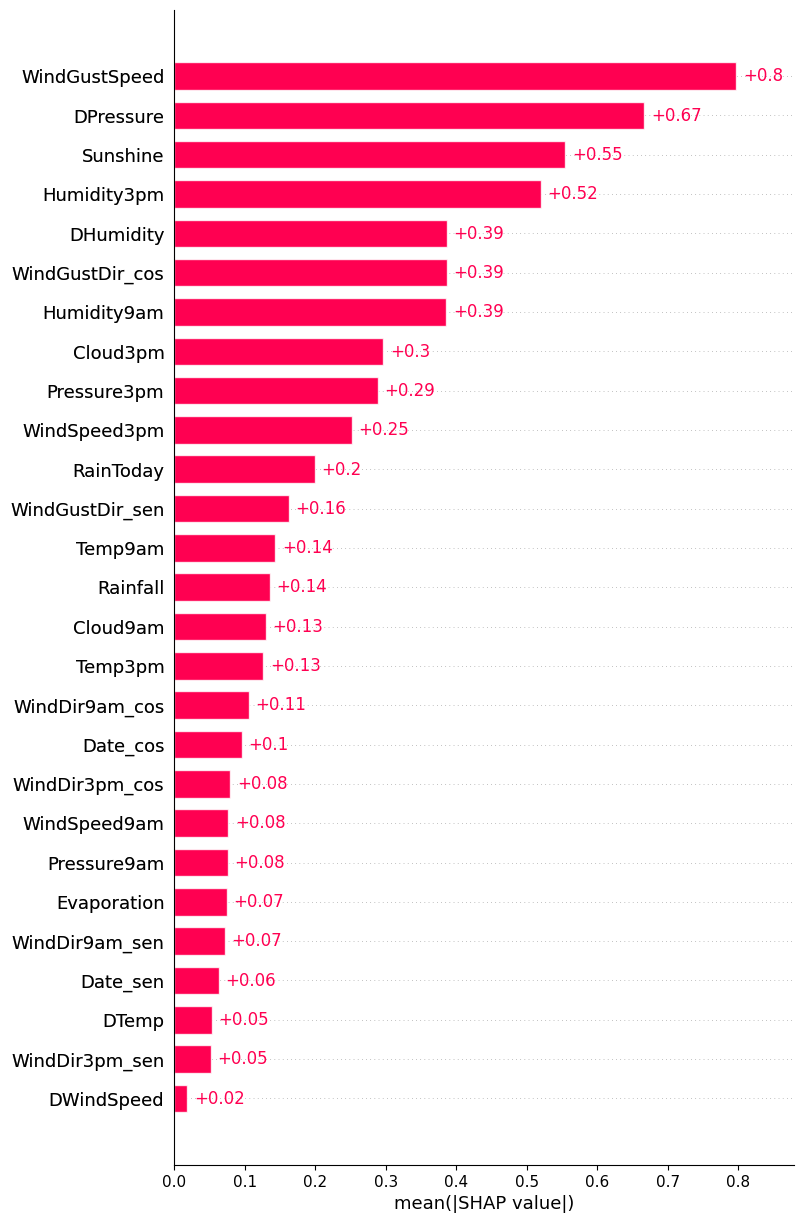

In [154]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test)
print('Gráfico de valores SHAP')
shap.plots.bar(explanation, max_display=27)

Se observan diferencias con respecto a la interpretabilidad global comparada con la interpretabilidad local. En el gráfico de importancia global de las variables, todas las variables explicativas están ordenadas según su contribución promedio al modelo, medida por los valores SHAP.
En primer lugar todas las variables inciden de manera positiva en el valor de la variable objetivo.

Además las principales variables no son las mismas que para el análisis local. La única que se mantiene es WindGustSpeed, que resulta la de mayor peso en ambos análisis.

Principales variables con incidencia positiva:
* WindGustSpeed
* DPressure (nueva)
* Sunshine (nueva)
* Humidity3pm (nueva)
* WindGustDir_cos (nueva)

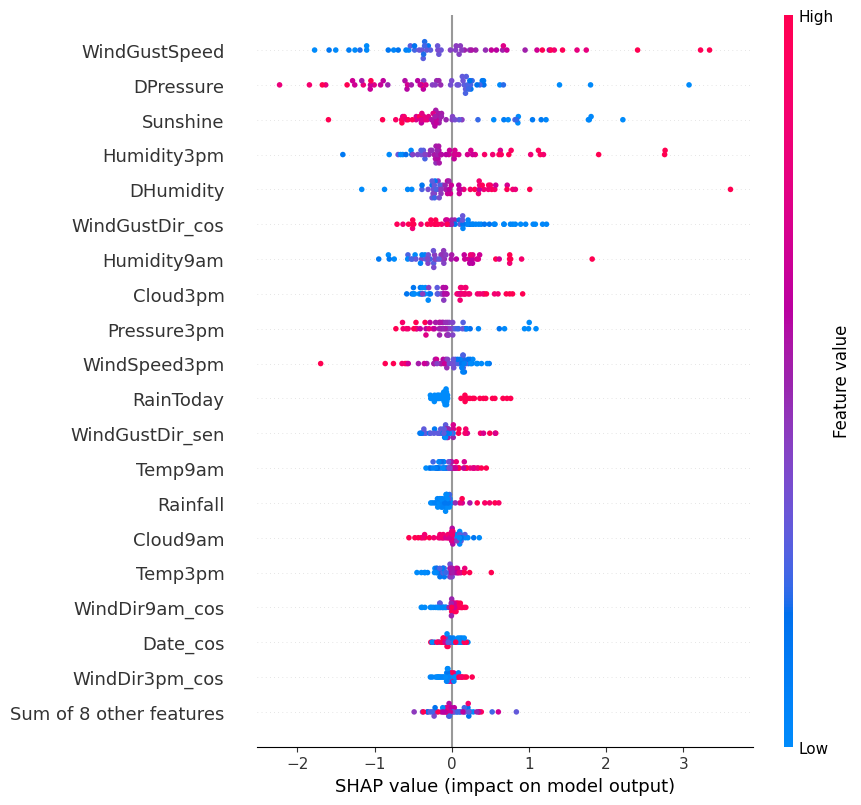

In [155]:
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 'large', 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium'})
shap.plots.beeswarm(explanation, max_display=20)

La gráfica anterior muestra las variables explicativas, ordenadas según su importancia global en el modelo, es decir considerando el impacto en la predicción de la probabilidad de lluvia para el día siguiente ("RainfallTomorrow"). Se analizan las cinco variables principales:

En primer lugar se encuentra la variable WindGustSpeed, donde los valores más altos tienen una incidencia positiva en el valor de RainfallTomorrow, y en contraposición, valores más bajos de WindGustSpeed tienen un peso negativo en la variable target.

En segundo lugar aparece la variable DPressure, donde los valores más altos tienen una incidencia negativa en el valor de RainfallTomorrow, y valores más bajos tienen una incidencia positiva. Esto sugiere que una mayor diferencia de presión puede estar asociada con un menor riesgo de lluvia al día siguiente.

La variable Sunshine sigue un patrón similar al de DPressure. Los valores más altos de Sunshine tienen una incidencia negativa en la probabilidad de lluvia al día siguiente, mientras que los valores más bajos tienen una incidencia positiva. Esto es coherente con la expectativa de que días soleados son menos propensos a ser seguidos por lluvia.

Humidity3pm tiene una incidencia positiva en la probabilidad de lluvia al día siguiente cuando sus valores son altos, y una incidencia negativa cuando sus valores son bajos.

La interpretación del coseno de la dirección del viento (WindGustDir_cos) es más compleja, pero se observa que valores más altos tienen una incidencia negativa en la variable target y viceversa. Se puede pensar entonces que valores altos se corresponden con direcciones de viento predominantes hacia el norte, y que valores bajos se relacionen con direcciones de viento orientadas predominantemente hacia el sur.

La variable RainToday tiene, para valores altos, un peso positivo sobre la variable target, y negativo para valores bajos. Resulta llamativa la dispersión de datos siendo que RainToday es una variable de tipo booleana. La alta dispersión de los valores SHAP para RainToday refleja la variabilidad en cómo esta característica influye en la predicción de RainfallTomorrow en diferentes contextos y condiciones meteorológicas. Esta variabilidad es capturada por el modelo y se expresa en los valores SHAP, que muestran cómo la contribución de RainToday a la predicción puede cambiar significativamente de una instancia a otra debido a interacciones complejas con otras características y a la naturaleza no lineal del modelo.

Por último, la variable Rainfall tiende a aumentar, para valores altos, la probabilidad de lluvia al día siguiente, mientras que valores bajos (azul) tienen el efecto contrario.

##### Explicabilidad del modelo de redes para clasificación

In [156]:
X_train, y_train, X_test, y_test = split(df_train, df_test, 'clasificacion')

feature_names = X_train.columns.values

# Aplicar oversampling
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Reducir la cantidad de muestras para reducir el tiempo de ejecución de SHAP,
# se resetea el índice para que sean consecutivos y comiencen en cero
n_train = int(len(df_train) * 0.02)
n_test = int(len(df_test) * 0.02)
X_train = X_train.sample(n=n_train, random_state=42).reset_index(drop=True)
X_test = X_test.sample(n=n_test, random_state=42).reset_index(drop=True)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir los arrays escalados de nuevo a DataFrames de pandas utilizando los nombres de las características
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Crear un objeto explainer SHAP usando KernelExplainer
explainer = shap.KernelExplainer(best_model_nn_clas, X_train_scaled.values)

# Calcular los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled.values)

# Eliminar dimensión de tamaño 1
shap_values = np.squeeze(shap_values)

# Verificar la forma de los valores SHAP
print(shap_values.shape)

Using 382 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 57/57 [04:22<00:00,  4.60s/it]

(57, 27)


###### Interpretabilidad local

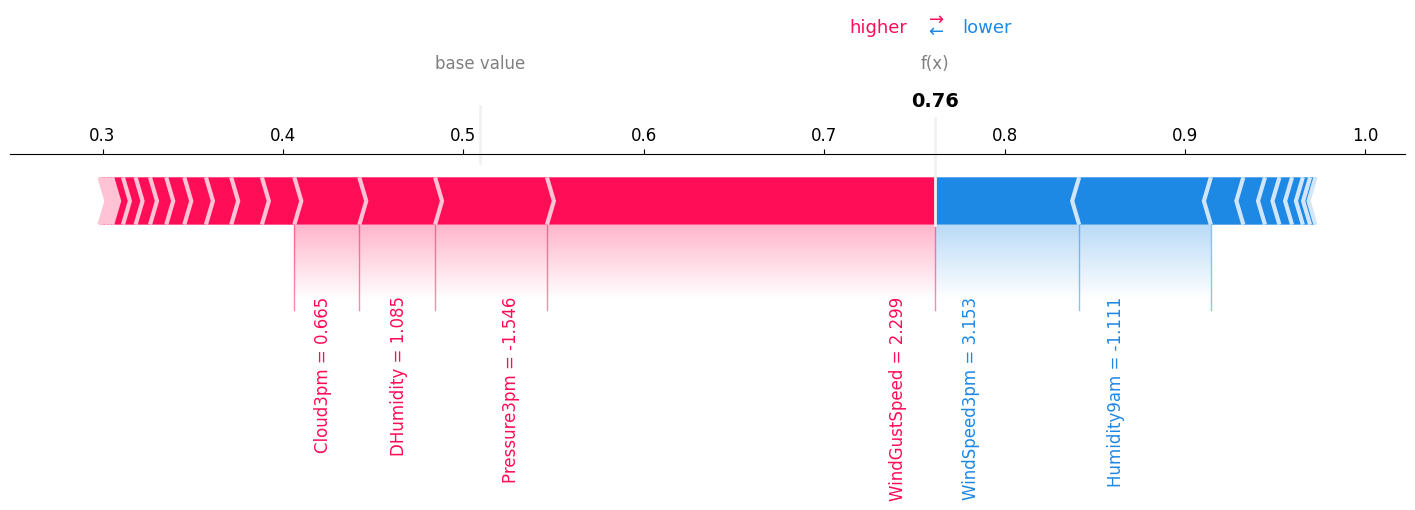

In [157]:
index=10
shap_values[index]

rounded_shap_values = np.round(shap_values[index], 3)
rounded_X_test = np.round(X_test_scaled.iloc[index], 3)

# Genera el gráfico de SHAP con valores redondeados
shap.force_plot(explainer.expected_value, rounded_shap_values, rounded_X_test, 
                feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=90)

Del gráfico de fuerza anterior se puede observar cómo impactan las variables de manera positiva (en rojo) y negativa (en azul).
Las variables con mayor incidencia son las descritas en el gráfico, para el caso particular del elemento en la posición index.

Resultan más las variables que empujan la predicción hacia la clase 1 (RainTomorrow=True).

Principales variables con incidencia positiva:
* WindGustSpeed
* Pressure3pm
* DHumidity
* Cloud3pm

Principales variables con incidencia negativa:
* WindSpeed3pm
* Humidity9am       

Es importante destacar que las principales variables obtenidas también lo son para el análisis local en el modelo de regresión.

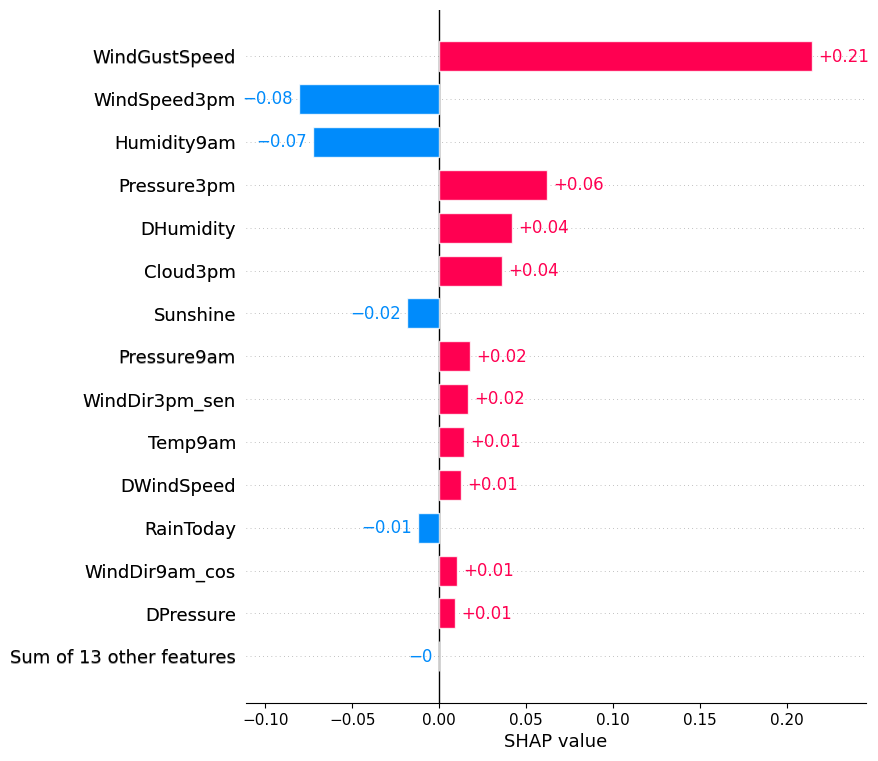

In [158]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.bar(explanation, max_display=15)

La gráfica anterior permite observar con más detalle lo expuesto previamente.

###### Interpretabilidad global

Gráfico de valores SHAP*100


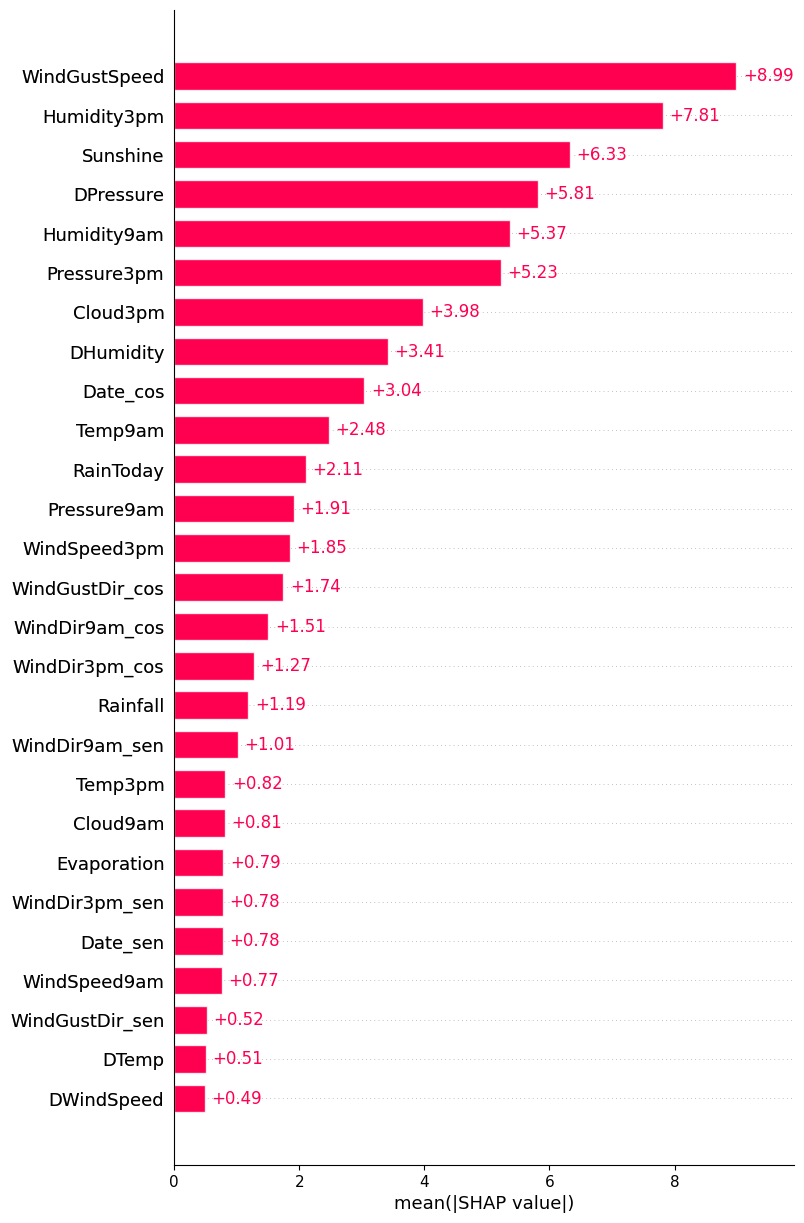

In [159]:
explanation = shap.Explanation(values=shap_values*100, base_values=explainer.expected_value, feature_names=feature_names, data=X_test)
print('Gráfico de valores SHAP*100')
shap.plots.bar(explanation, max_display=27)

Se observan diferencias con respecto a la interpretabilidad global comparada con la interpretabilidad local. En el gráfico de importancia global de las variables, todas las variables explicativas están ordenadas según su contribución promedio al modelo, medida por los valores SHAP.

Todas las variables explicativas empujan la predicción hacia la clase 1 (probabilidad de lluvia al día siguiente) en diferentes magnitudes, según los valores SHAP.

Además sólo se conserva WindGustSpeed como una de las 5 variables principales en comparación con la interpretación local anterior.
Las cinco variables con mayor incidencia positiva son:

* Humidity3pm
* WindGustSpeed
* DPressure
* Sunshine
* Humidity9am

Si se compara con el análisis global para el modelo de regresión, se observa nuevamente que se repiten las variables principales, excepto WindGustDir_cos que es reemplazada por Humidity9am.

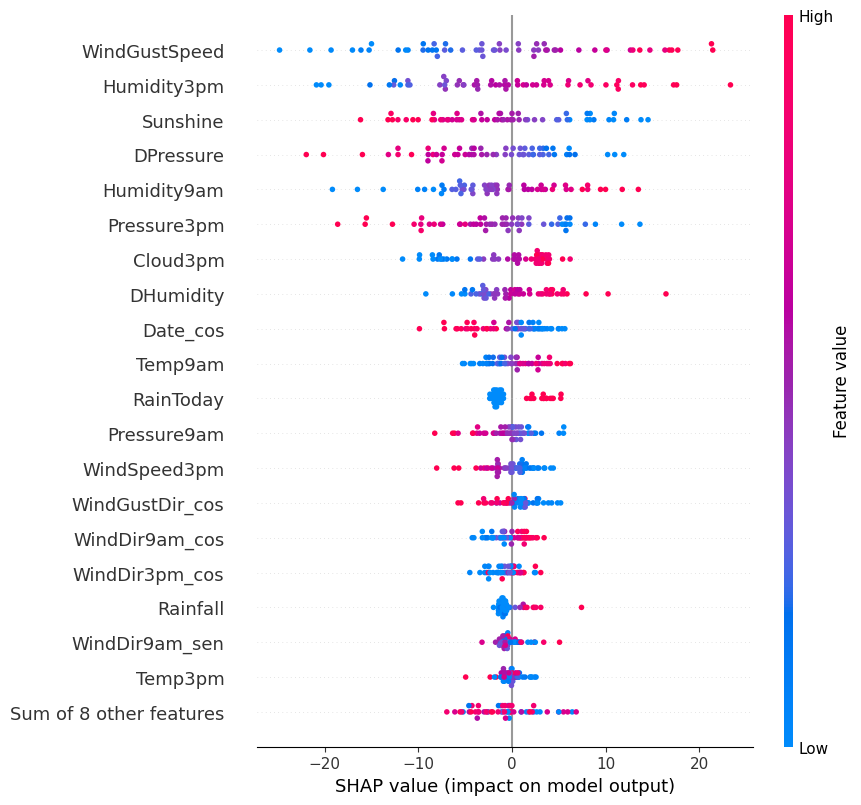

In [160]:
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 'large', 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium'})
shap.plots.beeswarm(explanation, max_display=20)

Para este gráfico de abejas se observa que las variables principales varían respecto al gráfico construido para el modelo de regresión.

En este caso, se puede observar que WindGustSpeed empuja los valores altos hacia la clase 1 (RainTomorrow=True), y los valores bajos hacia la clase 0.

Un comportamiento similar se da para los valores de Humidity3pm y Humidity9am.

Por otro lado, sucede lo contrario para Sunshine y DPressure, donde valores más altos tienen mayor peso para la clase 0 (RainTomorrow=False), y valores más bajos empujan hacia la clase 1.

### 10.Comparación de modelos

#### Regresión

In [248]:
# Crear el DataFrame con los modelos y sus métricas
df_comparacion_reg = df_comparacion_probreg.copy()
df_comparacion_reg.loc[len(df_comparacion_reg)] = ['Redes Neuronales', rmse_nn_train, rmse_nn_test,R2_nn_train,R2_nn_test]
df_comparacion_reg

modelo  train rmse  test rmse  train R2   test R2
0                OLS    5.379309   6.071118  0.218157  0.200986
1                 GD    5.381305   6.070565  0.217577  0.201131
2                GDE    5.575576   6.353017  0.160064  0.125062
3                GBD    5.379968   6.075078  0.217965  0.199943
4              Ridge    5.379309   6.071118  0.218157  0.200986
5              Lasso    5.379309   6.071118  0.218157  0.200986
6        Elastic-net    5.379309   6.071118  0.218157  0.200986
7               Base    6.144219   6.844988  0.218157  0.200986
8           RFR_Grid    4.434029   5.823021  0.468793  0.264955
9         RFR_Search    4.590893   5.815750  0.430543  0.266790
10        RFR_Optuna    4.643307   5.825834  0.417466  0.264245
11  Redes Neuronales    4.960244   5.810717  0.335228  0.268058

En la tabla anterior se resumen todos los modelos desarrollados, con las métricas rmse y R2 de entrenamiento y prueba.
Rmse tienen la ventaja de ser un valor fácilmente interpretable al tratarse de mm de lluvia.
La métrica R2 también es sencilla de analizar, ya que su variación es de 0 a 1, siendo R2=1 el valor para un modelo con una capacidad perfecta de predicción.

En nuestro análisis interesa particularmente el valor de test R2, y por ello se elige al modelo de redes neuronales es el mejor de todos, aunque por poco margen.

Por lo antes mencionado, ningún modelo logra una calidad aceptable de predicción (R2>0.6 por ejemplo), pero el modelo de redes es el que mejor R2 test arroja y además tiene menos sobreajuste, si comparamos por ejemplo con los modelos de RandomForestRegressor.

#### Clasificación

In [251]:
# Crear el DataFrame con los modelos y sus métricas
df_comparacion_clas = df_comparacion_logreg.copy()
df_comparacion_clas.loc[len(df_comparacion_clas)] = ['Redes Neuronales',best_threshold, precision_nn,tpr_nn,specificity_nn,f1_nn]
df_comparacion_clas.drop(columns=['f1'])

modelo    Umbral  Precision       TPR  Especificidad
0            logreg  0.500000   0.704819  0.526237       0.932969
1        logreg_blc  0.500000   0.535226  0.763118       0.798450
2        logreg_ovs  0.500000   0.537578  0.772114       0.797994
3       logreg_ovsu  0.480410   0.524574  0.784108       0.783858
4       logreg_base  0.500000   0.397215  0.727136       0.664387
5       logreg_grid  0.470064   0.513145  0.790105       0.772002
6  Redes Neuronales  0.517000   0.524330  0.791604       0.781578

En la tabla anterior se resumen todos los modelos desarrollados, con los valores de umbral asociados y las métricas precision, TPR y especificidad.

En particular interesa maximizar tanto TPR como la espcificidad, cuidando de que el valor de precision no baje de 0.5.

Considerando lo antes expuesto el modelo de Redes Neuronales resulta el mejor de todos, aunque también por una escasa diferencia.

Se consigue así un modelo que para la clase minoritaria (lluvia mañana) no posee una buena precisión, pero que en contraposición ajusta las predicciones a los valores reales con una tasa de aproximadamente el 80%, para ambas clases.